# Tl;dr
This notebook builds on 05/06/2025 and attempts multi-class classification of MHD. Did not continue/no results due to pivot in research direction.

**Version of dataset produced here saved as .pkl and used for all subsequent notebooks**

# Import libraries

In [2]:
import pandas as pd
import numpy as np

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sklearn.preprocessing import (
    MinMaxScaler
)

# sklearn Imputer (for MICE)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# sklearn Model selection and evaluation
from sklearn.model_selection import (
    train_test_split
)

# sklearn Model evaluation
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
)

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV

from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)

from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMClassifier

# Reading in Data

In [3]:
master_path = '/Users/daisyliu/Desktop/Care4Minds/dataset/master_df_checkpoint.pkl'

with open(master_path, 'rb') as file:
    master_df = pickle.load(file)

print(master_df.shape)
master_df.head(10)

(352161, 42)


Patient_ID     Sex  BirthYear  DeceasedYear   Age PatientStatus_calc  \
0  1002000000000009  Female     2010.0           NaN  15.0             Active   
1  1002000000000010  Female     2007.0           NaN  18.0             Active   
2  1002000000000015    Male     1972.0           NaN  53.0             Active   
3  1002000000000016    Male     1965.0           NaN  60.0             Active   
4  1002000000000020    Male     1999.0           NaN  26.0             Active   
5  1002000000000024  Female     1955.0           NaN  70.0             Active   
6  1002000000000039    Male     1999.0           NaN  26.0             Active   
7  1002000000000044  Female     1949.0           NaN  76.0             Active   
8  1002000000000046    Male     2010.0           NaN  15.0             Active   
9  1002000000000049    Male     1965.0           NaN  60.0             Active   

   Total_Overall_Diagnoses                                  Overall_Diagnosis  \
0                        0                                                NaN   
1                        0                                                NaN   
2                        0                                                 []   
3                        3  [CATARACT, BENIGN NEOPLASM OF SKIN, ACUTE MYOC...   
4                        0                                                NaN   
5                        2  [DISORDER OF BONE AND CARTILAGE, UNSPECIFIED, ...   
6                        0                                                NaN   
7                        1  [DIVERTICULOSIS OF COLON (WITHOUT MENTION OF H...   
8                        0                                                NaN   
9                        5  [GENERAL SYMPTOMS, OVERWEIGHT AND OBESITY, OST...   

                              Overall_Diagnosis_List  \
0                                                NaN   
1                                                NaN   
2                                                 []   
3  [CATARACT, ACUTE MYOCARDIAL INFARCTION, BENIGN...   
4                                                NaN   
5  [DISORDER OF BONE AND CARTILAGE, UNSPECIFIED, ...   
6                                                NaN   
7  [DIVERTICULOSIS OF COLON (WITHOUT MENTION OF H...   
8                                                NaN   
9  [GENERAL SYMPTOMS, OVERWEIGHT AND OBESITY, AST...   

  DateOfOnset_Overall_Diagnosis  ...  \
0                           NaN  ...   
1                           NaN  ...   
2                            []  ...   
3               [nan, nan, nan]  ...   
4                           NaN  ...   
5             [2010-01-02, nan]  ...   
6                           NaN  ...   
7                         [nan]  ...   
8                           NaN  ...   
9     [nan, nan, nan, nan, nan]  ...   

                                            LabTests  \
0                                            [HBA1C]   
1                                                NaN   
2  [TOTAL CHOLESTEROL, TRIGLYCERIDES, HDL, LDL, L...   
3  [TOTAL CHOLESTEROL, TRIGLYCERIDES, HDL, LDL, F...   
4                                                NaN   
5  [TOTAL CHOLESTEROL, HDL, TRIGLYCERIDES, LDL, G...   
6                                                NaN   
7  [TRIGLYCERIDES, FASTING GLUCOSE, TOTAL CHOLEST...   
8                                                NaN   
9  [GFR, FASTING GLUCOSE, TRIGLYCERIDES, LDL, TOT...   

                                 Lab_Performed_Dates  \
0                                       [2013-05-30]   
1                                                NaN   
2  [2010-05-06, 2010-05-06, 2010-05-06, 2010-05-0...   
3  [2012-04-19, 2012-04-19, 2012-04-19, 2012-04-1...   
4                                                NaN   
5  [2007-07-11, 2007-07-11, 2007-07-11, 2007-07-1...   
6                                                NaN   
7  [2009-12-11, 2009-12-11, 2009-12-11, 2009-12-1...   
8                                             

In [4]:
print(master_df.columns)

Index(['Patient_ID', 'Sex', 'BirthYear', 'DeceasedYear', 'Age',
       'PatientStatus_calc', 'Total_Overall_Diagnoses', 'Overall_Diagnosis',
       'Overall_Diagnosis_List', 'DateOfOnset_Overall_Diagnosis',
       'Health_condition_Encounter_IDs', 'ICD-9', 'Total_Risks', 'Risk_List',
       'Risks', 'Risks_orig', 'Total_Encounters', 'EncounterDates',
       'Encounter_IDs', 'EncounterDiagnosisTexts', 'EncounterDiagnosisCodes',
       'EncounterReasonTexts', 'Total_Medications', 'Medications',
       'Med_Start_Dates', 'Med_Durations', 'Med_Reasons', 'Med_Frequencies',
       'Med_Strengths', 'Med_Doses', 'Med_UnitOfMeasures', 'Total_LabTests',
       'LabTests', 'Lab_Performed_Dates', 'Lab_Test_Results',
       'Lab_Upper_Normal', 'Lab_Lower_Normal', 'Lab_Normal_Range',
       'Lab_UnitOfMeasure', 'Total_MedProcs', 'MedProcs_List',
       'MedProcs_Date'],
      dtype='object')


In [5]:
df = master_df.dropna(subset=['ICD-9']) # assume NAs mean "missing" 
print(df.shape)
df.head(10)

(262760, 42)


Patient_ID     Sex  BirthYear  DeceasedYear   Age  \
2   1002000000000015    Male     1972.0           NaN  53.0   
3   1002000000000016    Male     1965.0           NaN  60.0   
5   1002000000000024  Female     1955.0           NaN  70.0   
7   1002000000000044  Female     1949.0           NaN  76.0   
9   1002000000000049    Male     1965.0           NaN  60.0   
11  1002000000000065  Female     1962.0           NaN  63.0   
12  1002000000000072    Male     1972.0           NaN  53.0   
13  1002000000000075  Female     1988.0           NaN  37.0   
14  1002000000000078    Male     1953.0           NaN  72.0   
16  1002000000000087  Female     1953.0           NaN  72.0   

   PatientStatus_calc  Total_Overall_Diagnoses  \
2              Active                        0   
3              Active                        3   
5              Active                        2   
7              Active                        1   
9              Active                        5   
11             Active                        2   
12             Active                        0   
13             Active                        4   
14             Active                        3   
16             Active                        4   

                                    Overall_Diagnosis  \
2                                                  []   
3   [CATARACT, BENIGN NEOPLASM OF SKIN, ACUTE MYOC...   
5   [DISORDER OF BONE AND CARTILAGE, UNSPECIFIED, ...   
7   [DIVERTICULOSIS OF COLON (WITHOUT MENTION OF H...   
9   [GENERAL SYMPTOMS, OVERWEIGHT AND OBESITY, OST...   
11  [OTHER AND UNSPECIFIED HYPERLIPIDEMIA, ATTENTI...   
12                                                 []   
13  [BACKACHE, UNSPECIFIED, DEPRESSIVE TYPE PSYCHO...   
14  [PAIN IN JOINT, ALCOHOL ABUSE, POISONING BY UN...   
16  [ANXIETY STATES, URETHRAL STRICTURE, UNSPECIFI...   

                               Overall_Diagnosis_List  \
2                                                  []   
3   [CATARACT, ACUTE MYOCARDIAL INFARCTION, BENIGN...   
5   [DISORDER OF BONE AND CARTILAGE, UNSPECIFIED, ...   
7   [DIVERTICULOSIS OF COLON (WITHOUT MENTION OF H...   
9   [GENERAL SYMPTOMS, OVERWEIGHT AND OBESITY, AST...   
11  [OTHER AND UNSPECIFIED HYPERLIPIDEMIA, ATTENTI...   
12                                                 []   
13  [OVERWEIGHT AND OBESITY, FRACTURE OF ANKLE, BA...   
14  [ALCOHOL ABUSE, PAIN IN JOINT, ALCOHOL ABUSE, ...   
16  [UNSPECIFIED VIRAL HEPATITIS WITHOUT MENTION O...   

         DateOfOnset_Overall_Diagnosis  ...  \
2                                   []  ...   
3                      [nan, nan, nan]  ...   
5                    [2010-01-02, nan]  ...   
7                                [nan]  ...   
9            [nan, nan, nan, nan, nan]  ...   
11                          [nan, nan]  ...   
12                                  []  ...   
13                [nan, nan, nan, nan]  ...   
14                [nan, nan, nan, nan]  ...   
16  [2008-01-13, 2007-07-13, nan, nan]  ...   

                                             LabTests  \
2   [TOTAL CHOLESTEROL, TRIGLYCERIDES, HDL, LDL, L...   
3   [TOTAL CHOLESTEROL, TRIGLYCERIDES, HDL, LDL, F...   
5   [TOTAL CHOLESTEROL, HDL, TRIGLYCERIDES, LDL, G...   
7   [TRIGLYCERIDES, FASTING GLUCOSE, TOTAL CHOLEST...   
9   [GFR, FASTING GLUCOSE, TRIGLYCERIDES, LDL, TOT...   
11  [TRIGLYCERIDES, TOTAL CHOLESTEROL, HDL, LDL, F...   
12  [GFR, FASTING GLUCOSE, TOTAL CHOLESTEROL, TRIG...   
13  [FASTING GLUCOSE, FASTING GLUCOSE, HBA1C, GFR,...   
14  [GFR, GFR, GFR, GFR, GFR, GFR, GFR, GFR, GFR, ...   
16  [INR, TOTAL CHOLESTEROL, TRIGLYCERIDES, HDL, L...   

                                  Lab_Performed_Dates  \
2   [2010-05-06, 2010-05-06, 2010-05-06, 2010-05-0...   
3   [2012-04-19, 2012-04-19, 2012-04-19, 2012-04-1...   
5   [2007-07-11, 2007-07-11, 2007-07-11, 2007-07-1...   
7   [2009-12-11, 2009-12-11, 2009-12-11, 2009-12-1...   
9   [2007-07-03, 2007-07-03, 2007-07-03, 2007-07-0...   
11  [2012-01-12, 2012

# Feature engineering

## Binary MHD indicator (y/n)

ICD-9 codes by DSM-5 category:
- Neurodevelopmental disorders (NDDs): ('299', '315', '317', '318', '319', '314', '307')
- Schizhophrenia spectrum and other psychotic disorders: ('295', '297', '298')
- Bipolar and related disorders: ('296')
- Depressive disorders: ('311')
- Anxiety disorders: ('300', '313')
- Trauma- and Stressor-related disorders: ('308', '309')
- Sleep-wake disorders: ('327', '347')
- Sexual dysfunctions: ('302')
- Substance-related and addictive disorders: ('305', '303', '304', '291', '292')
- Personality disorders: ('301')
- Neurocognitive disorders: ('294', '333', '331')

In [ ]:
### Candidate for refactoring: this code defines a dictionary to map mental health disorders to their respective ICD codes
### This allows for easy retrieval and categorization of disorders based on their ICD codes
## Includes following code for making binary labels

mhd_dict = {'NDD': ['299', '315', '317', '318', '319', '314', '307'],
            'SCHIZ': ['295', '297', '298'],
            'BPD': ['296'],
            'MDD': ['311'],
            'GAD': ['300', '313'],
            'TSD': ['308', '309'],
            'SWD': ['327', '347'],
            'SD': ['302'],
            'SUD': ['305', '303', '304', '291', '292'],
            'PD': ['301'],
            'NCD': ['294', '333', '331',
                    '366']}

mhd_icds = []

for k in mhd_dict:
    mhd_icds = mhd_icds + mhd_dict[k]

print(type(mhd_icds))
print(f'All ICDs: {mhd_icds}')

<class 'list'>
All ICDs: ['299', '315', '317', '318', '319', '314', '307', '295', '297', '298', '296', '311', '300', '313', '308', '309', '327', '347', '302', '305', '303', '304', '291', '292', '301', '294', '333', '331', '366']


In [36]:
import ast

df['Clean_ICD'] = df['Clean_ICD'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

def is_mh(codes, icds):
    return int(bool(set(codes) & set(icds)))

In [37]:
df['Clean_ICD'].iloc[1]

['366', '410', '216']

In [8]:
def is_mh(codes, icds):
    return int(bool(set(codes) & set(icds)))

# df['HasMHD'] = df['Clean_ICD'].apply(lambda x: is_mh(x, mhd_icds))
df['HasMHD'] = df['ICD-9'].apply(lambda x: is_mh(x, mhd_icds))
print(df['HasMHD'].value_counts())
df.head(5)

HasMHD
0    212405
1     50355
Name: count, dtype: int64


/var/folders/yb/n93q7gbn67v_pbwyvgl9kgy80000gn/T/ipykernel_1823/3603270340.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HasMHD'] = df['ICD-9'].apply(lambda x: is_mh(x, mhd_icds))


Patient_ID     Sex  BirthYear  DeceasedYear   Age PatientStatus_calc  \
2  1002000000000015    Male     1972.0           NaN  53.0             Active   
3  1002000000000016    Male     1965.0           NaN  60.0             Active   
5  1002000000000024  Female     1955.0           NaN  70.0             Active   
7  1002000000000044  Female     1949.0           NaN  76.0             Active   
9  1002000000000049    Male     1965.0           NaN  60.0             Active   

   Total_Overall_Diagnoses                                  Overall_Diagnosis  \
2                        0                                                 []   
3                        3  [CATARACT, BENIGN NEOPLASM OF SKIN, ACUTE MYOC...   
5                        2  [DISORDER OF BONE AND CARTILAGE, UNSPECIFIED, ...   
7                        1  [DIVERTICULOSIS OF COLON (WITHOUT MENTION OF H...   
9                        5  [GENERAL SYMPTOMS, OVERWEIGHT AND OBESITY, OST...   

                              Overall_Diagnosis_List  \
2                                                 []   
3  [CATARACT, ACUTE MYOCARDIAL INFARCTION, BENIGN...   
5  [DISORDER OF BONE AND CARTILAGE, UNSPECIFIED, ...   
7  [DIVERTICULOSIS OF COLON (WITHOUT MENTION OF H...   
9  [GENERAL SYMPTOMS, OVERWEIGHT AND OBESITY, AST...   

  DateOfOnset_Overall_Diagnosis  ...  \
2                            []  ...   
3               [nan, nan, nan]  ...   
5             [2010-01-02, nan]  ...   
7                         [nan]  ...   
9     [nan, nan, nan, nan, nan]  ...   

                                 Lab_Performed_Dates  \
2  [2010-05-06, 2010-05-06, 2010-05-06, 2010-05-0...   
3  [2012-04-19, 2012-04-19, 2012-04-19, 2012-04-1...   
5  [2007-07-11, 2007-07-11, 2007-07-11, 2007-07-1...   
7  [2009-12-11, 2009-12-11, 2009-12-11, 2009-12-1...   
9  [2007-07-03, 2007-07-03, 2007-07-03, 2007-07-0...   

                                    Lab_Test_Results  \
2  [4.02, 0.83, 1.23, 2.41, 2.62, 1.66, 1.6, 4.97...   
3  [4.22, 0.98, 1.56, 2.21, 5.7, 0.94, 4.24, 1.57...   
5          [4.43, 1.29, 1.26, 2.6, 77, 5.1, 68, 5.6]   
7               [1.81, 5.1, 4.9, 1.38, 2.7, 72, 5.7]   
9  [61, 5.5, 1.35, 3.6, 5.38, 1.19, 58, 5, 1.87, ...   

                                    Lab_Upper_Normal  \
2  [5.2, 2.3, 0.91, 3.4, 3.4, 2.3, 0.91, 5.2, 6.1...   
3  [5.2, 2.3, 0.91, 3.4, 6.1, 2.3, 5.2, 0.91, 3.4...   
5       [5.21, 2.4, 2.31, 3.4, 59.0, 6.0, 59.0, 6.0]   
7             [2.31, 6.0, 5.21, 2.4, 3.4, 59.0, 6.0]   
9  [59.0, 6.0, 2.31, 3.4, 5.21, 1.6, 59.0, 6.0, 2...   

                                    Lab_Lower_Normal  \
2  [3.8, 0.6, 0.91, 2.0, 2.0, 0.6, 0.91, 3.8, 4.3...   
3  [3.8, 0.6, 0.91, 2.0, 3.9, 0.6, 3.8, 0.91, 2.0...   
5           [5.21, 0.9, 2.31, 2.2, 59.0, 4.0, 59, 4]   
7                 [2.31, 4.0, 5.21, 0.9, 2.2, 59, 4]   
9  [59.0, 4.0, 2.31, 2.0, 5.21, 0.9, 59, 4, 2.31,...   

                                    Lab_Normal_Range  \
2  [3.80-5.20, 0.60-2.30, >=0.91, 2.00-3.40, 2.00...   
3  [3.80-5.20, 0.60-2.30, >=0.91, 2.00-3.40, 3.9-...   
5  [< 5.21, 0.90-2.40, < 2.31, 2.2-3.4, > 59, 4.0...   
7  [< 2.31, 4.0-6.0, < 5.21, 0.90-2.40, 2.2-3.4, ...   
9  [> 59, 4.0-6.0, < 2.31, 2.0-3.4, < 5.21, 0.90-...   

                                   Lab_UnitOfMeasure  Total_MedProcs  \
2  [mmol/L, mmol/L, mmol/L, mmol/L, mmol/L, mmol/...               0   
3  [mmol/L, mmol/L, mmol/L, mmol/L, mmol/L, mmol/...               0   
5  [mmol/L, mmol/L, mmol/L, mmol/L, mL/min/1.73m^...               1   
7  [mmol/L, mmol/L, mmol/L, mmol/L, mmol/L, mL/mi...               2   
9  [mL/min/1.73m^2, mmol/L, mmol/L, mmol/L, mmol/...               2   

                           MedProcs_List             MedProcs_Date HasMHD  
2                                    NaN                       NaN      0  
3                                    NaN                       NaN      1  
5                     [Cesarean Section]                     [nan]      0  
7            [Hysterectomy, Colonos

## Making labels for multiple binary classifications

In [9]:
for k, v in mhd_dict.items():
    df[f'{k}_Bin'] = df['ICD-9'].apply(lambda x: is_mh(x, v))
print(list(df.columns))

/var/folders/yb/n93q7gbn67v_pbwyvgl9kgy80000gn/T/ipykernel_1823/590333955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{k}_Bin'] = df['ICD-9'].apply(lambda x: is_mh(x, v))
/var/folders/yb/n93q7gbn67v_pbwyvgl9kgy80000gn/T/ipykernel_1823/590333955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{k}_Bin'] = df['ICD-9'].apply(lambda x: is_mh(x, v))
/var/folders/yb/n93q7gbn67v_pbwyvgl9kgy80000gn/T/ipykernel_1823/590333955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy o

['Patient_ID', 'Sex', 'BirthYear', 'DeceasedYear', 'Age', 'PatientStatus_calc', 'Total_Overall_Diagnoses', 'Overall_Diagnosis', 'Overall_Diagnosis_List', 'DateOfOnset_Overall_Diagnosis', 'Health_condition_Encounter_IDs', 'ICD-9', 'Total_Risks', 'Risk_List', 'Risks', 'Risks_orig', 'Total_Encounters', 'EncounterDates', 'Encounter_IDs', 'EncounterDiagnosisTexts', 'EncounterDiagnosisCodes', 'EncounterReasonTexts', 'Total_Medications', 'Medications', 'Med_Start_Dates', 'Med_Durations', 'Med_Reasons', 'Med_Frequencies', 'Med_Strengths', 'Med_Doses', 'Med_UnitOfMeasures', 'Total_LabTests', 'LabTests', 'Lab_Performed_Dates', 'Lab_Test_Results', 'Lab_Upper_Normal', 'Lab_Lower_Normal', 'Lab_Normal_Range', 'Lab_UnitOfMeasure', 'Total_MedProcs', 'MedProcs_List', 'MedProcs_Date', 'HasMHD', 'NDD_Bin', 'SCHIZ_Bin', 'BPD_Bin', 'MDD_Bin', 'GAD_Bin', 'TSD_Bin', 'SWD_Bin', 'SD_Bin', 'SUD_Bin', 'PD_Bin', 'NCD_Bin']


/var/folders/yb/n93q7gbn67v_pbwyvgl9kgy80000gn/T/ipykernel_1823/590333955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{k}_Bin'] = df['ICD-9'].apply(lambda x: is_mh(x, v))


In [42]:
proportions = {}

MHDs = ['NDD_Bin', 'SCHIZ_Bin', 'BPD_Bin', 'MDD_Bin', 'GAD_Bin', 'TSD_Bin', 
        'SWD_Bin', 'SD_Bin', 'SUD_Bin', 'PD_Bin', 'NCD_Bin']

for col in MHDs:
    counts = df[col].value_counts(normalize=True)  # gives proportions
    proportions[col] = {
        'Proportion_0': counts.get(0, 0),
        'Proportion_1': counts.get(1, 0)
    }

proportions_df = pd.DataFrame.from_dict(proportions, orient='index')
print(proportions_df)

              Proportion_0  Proportion_1
NDD_OneHot        0.974353      0.025647
SCHIZ_OneHot      0.993937      0.006063
BPD_OneHot        0.996103      0.003897
MDD_OneHot        0.880754      0.119246
GAD_OneHot        0.883837      0.116163
TSD_OneHot        0.988077      0.011923
SWD_OneHot        0.999315      0.000685
SD_OneHot         0.999402      0.000598
SUD_OneHot        0.970848      0.029152
PD_OneHot         0.998900      0.001100
NCD_OneHot        0.987353      0.012647


In [10]:
proportions = {}

MHDs = ['NDD_Bin', 'SCHIZ_Bin', 'BPD_Bin', 'MDD_Bin', 'GAD_Bin', 'TSD_Bin', 
        'SWD_Bin', 'SD_Bin', 'SUD_Bin', 'PD_Bin', 'NCD_Bin']

for col in MHDs:
    counts = df[col].value_counts(normalize=True)  # gives proportions
    proportions[col] = {
        'Proportion_0': counts.get(0, 0),
        'Proportion_1': counts.get(1, 0)
    }

proportions_df = pd.DataFrame.from_dict(proportions, orient='index')
print(proportions_df)

           Proportion_0  Proportion_1
NDD_Bin        0.985089      0.014911
SCHIZ_Bin      0.997051      0.002949
BPD_Bin        0.996198      0.003802
MDD_Bin        0.880754      0.119246
GAD_Bin        0.965307      0.034693
TSD_Bin        0.994425      0.005575
SWD_Bin        0.999794      0.000206
SD_Bin         0.999418      0.000582
SUD_Bin        0.975065      0.024935
PD_Bin         0.998972      0.001028
NCD_Bin        0.990276      0.009724


In [43]:
df.to_csv('/Users/daisyliu/Desktop/Care4Minds/DataFrames/master_df_05082025.csv')

## Clean ICD-9 column
- Some non-diagnostic codes (e.g., 'V...', 'E...')
- Some trailing 0s etc.

In [11]:
def clean_icd9(row, n):
    # Drop codes that start with a letter
    row = [code for code in row if not str(code)[0].isalpha()]
    
    if len(row) == 0:
        return n  # signal this row as problematic
    else:
        try:
            num_row = [float(code) for code in row]
            str_row = [clean_icd_code(code) for code in num_row]
            return str_row
        except:
            return n

def clean_icd_code(code):
    try:
        # Convert to float in case it's a string like '250.00'
        code_float = float(code)
        # Convert back to string, drop trailing zeros *after* decimal
        code_str = str(code_float).rstrip('0').rstrip('.')
        return code_str
    except ValueError:
        return None  # or handle as needed (e.g., log bad value)

In [12]:
cleaned_icds = []
problem_row = []

for n in range(len(df['ICD-9'])):
    cleaned_row = clean_icd9(df['ICD-9'].iloc[n], n)
    
    if isinstance(cleaned_row, list):
        cleaned_icds.append(cleaned_row)
    else:
        cleaned_icds.append(df['ICD-9'].iloc[n])
        problem_row.append(n)

df['Clean_ICD'] = df['ICD-9'].apply(
    lambda code_list: [
        clean_icd_code(code)
        for code in code_list
        if not str(code)[0].isalpha()
    ] if isinstance(code_list, list) else code_list
)

df['Clean_ICD'].head(5)

/var/folders/yb/n93q7gbn67v_pbwyvgl9kgy80000gn/T/ipykernel_1823/793370380.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Clean_ICD'] = df['ICD-9'].apply(


2                           []
3              [366, 410, 216]
5                 [733.9, 995]
7                      [562.1]
9    [780, 278, 493, 715, 275]
Name: Clean_ICD, dtype: object

## Binary encoding gender

In [13]:
def encode_sex(value):
    """
    Converts sex to binary: male = 0, female = 1.
    Returns None for unrecognized values.
    """
    if isinstance(value, str):
        value = value.strip().lower()
        if value in ['male', 'm']:
            return 0
        elif value in ['female', 'f']:
            return 1
    return None  # handle unknowns, missing, or unrecognized values

df['Sex_Bin'] = df['Sex'].apply(encode_sex)

/var/folders/yb/n93q7gbn67v_pbwyvgl9kgy80000gn/T/ipykernel_1823/1526264233.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sex_Bin'] = df['Sex'].apply(encode_sex)


## One-hot encoding patient status

In [ ]:
### Candidate for refactoring: this code calculates the PatientStatus based on various health indicators and medications

df[['PatientStatus_calc']].value_counts()

PatientStatus_calc
Active                176896
Inactive               15467
Deceased                6487
External                 250
Unknown                   89
Duplicate                  1
Name: count, dtype: int64

In [15]:
df['PatientStatus_calc_NoNaN'] = df['PatientStatus_calc'].fillna('Unknown')
df['PatientStatus_calc_NoNaN'].value_counts()

/var/folders/yb/n93q7gbn67v_pbwyvgl9kgy80000gn/T/ipykernel_1823/29615799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PatientStatus_calc_NoNaN'] = df['PatientStatus_calc'].fillna('Unknown')


PatientStatus_calc_NoNaN
Active       176896
Unknown       63659
Inactive      15467
Deceased       6487
External        250
Duplicate         1
Name: count, dtype: int64

In [16]:
df = pd.get_dummies(df, columns=['PatientStatus_calc_NoNaN'], prefix='Status')
df = df.drop(columns=['Status_External', 'Status_Duplicate'], axis=1) # too few, not meaningful
print(list(df.columns))

['Patient_ID', 'Sex', 'BirthYear', 'DeceasedYear', 'Age', 'PatientStatus_calc', 'Total_Overall_Diagnoses', 'Overall_Diagnosis', 'Overall_Diagnosis_List', 'DateOfOnset_Overall_Diagnosis', 'Health_condition_Encounter_IDs', 'ICD-9', 'Total_Risks', 'Risk_List', 'Risks', 'Risks_orig', 'Total_Encounters', 'EncounterDates', 'Encounter_IDs', 'EncounterDiagnosisTexts', 'EncounterDiagnosisCodes', 'EncounterReasonTexts', 'Total_Medications', 'Medications', 'Med_Start_Dates', 'Med_Durations', 'Med_Reasons', 'Med_Frequencies', 'Med_Strengths', 'Med_Doses', 'Med_UnitOfMeasures', 'Total_LabTests', 'LabTests', 'Lab_Performed_Dates', 'Lab_Test_Results', 'Lab_Upper_Normal', 'Lab_Lower_Normal', 'Lab_Normal_Range', 'Lab_UnitOfMeasure', 'Total_MedProcs', 'MedProcs_List', 'MedProcs_Date', 'HasMHD', 'NDD_Bin', 'SCHIZ_Bin', 'BPD_Bin', 'MDD_Bin', 'GAD_Bin', 'TSD_Bin', 'SWD_Bin', 'SD_Bin', 'SUD_Bin', 'PD_Bin', 'NCD_Bin', 'Clean_ICD', 'Sex_Bin', 'Status_Active', 'Status_Deceased', 'Status_Inactive', 'Status_Unkn

In [17]:
df = df.replace({True: 1, False: 0})
df[['Status_Active', 'Status_Deceased', 'Status_Inactive', 'Status_Unknown']]

/var/folders/yb/n93q7gbn67v_pbwyvgl9kgy80000gn/T/ipykernel_1823/3740744860.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})


Status_Active  Status_Deceased  Status_Inactive  Status_Unknown
2                   1                0                0               0
3                   1                0                0               0
5                   1                0                0               0
7                   1                0                0               0
9                   1                0                0               0
...               ...              ...              ...             ...
352149              0                0                0               1
352153              0                0                0               1
352156              0                0                0               1
352158              0                0                0               1
352160              0                0                0               1

[262760 rows x 4 columns]

## Chronic Disease

In [19]:
chronic_path = '/Users/daisyliu/Desktop/Care4Minds/ChronicDisease/chronic_icd9.csv'
chronic_df = pd.read_csv(chronic_path)

def clean_icd_code(code):
    # If the code ends in '.0', drop the decimal; else, keep it
    return str(int(code)) if code == int(code) else str(code)

chronic_df['Str_Code'] = chronic_df['Code'].apply(clean_icd_code)

print(chronic_df.shape)
chronic_df.head(5)

(90, 3)


Condition   Code Str_Code
0  ACUTE MYOCARDIAL INFARCTION  410.0      410
1                HEART FAILURE  428.0      428
2           LEFT HEART FAILURE  428.1    428.1
3       ESSENTIAL HYPERTENSION  401.0      401
4          SPECIFIED AS BENIGN  401.1    401.1

In [20]:
def check_overlap(codes, chronic_icd_set):
    overlap = set(codes) & chronic_icd_set
    return list(overlap), len(overlap)

chronic_icd = list(chronic_df['Str_Code'])
chronic_icd[0:5]

chronic_icd_set = set(chronic_icd)

#df = df.drop(['chronic_diagnoses', 'num_chronic'], axis=1
df['Chronic_Diagnoses'], df['Num_Chronic'] = zip(*df['Clean_ICD'].apply(lambda codes: check_overlap(codes, chronic_icd_set)))

## Risks

In [ ]:
### Candidate for refactoring: this code identifies individual risks from a list of risks, handling NaN values, and creates a new column for the number of risks

df['Risks_noNaN'] = df['Risks'].apply(
    lambda x: [] if isinstance(x, float) and pd.isna(x) else x
)
df[['Risks_noNaN']].head(5)

Risks_noNaN
2      [Smoking, Diet]
3         [Diet, Diet]
5            [Smoking]
7  [Smoking, Exercise]
9                   []

In [ ]:
### Candidate for refactoring: this code counts the number of risks for each patient based on the cleaned risks column

df['Num_Risks'] = df['Risks_noNaN'].apply(lambda x: len(x))
df[['Num_Risks']].head(5)

Num_Risks
2          2
3          2
5          1
7          2
9          0

## Lab Results

In [23]:
# checking if we have any missing lab test result values
missing_result = []
for r in range(0, len(df)):
    if len(df['LabTests']) == len(df['Lab_Test_Results']):
        pass
    else:
        missing_result.append(r)
len(missing_result)

0

In [ ]:
labs_combined = {}

# Candidate for refactoring: this code is repeated in multiple places
#### This code combines lab test data into a structured format for each patient
#### It creates a dictionary where each key is a patient ID and the value is another dictionary
#### containing the patient's demographic and lab test information
for _, row in df.iterrows():
    patient_id = row['Patient_ID']
    sex = row['Sex']
    
    if (
        isinstance(row['LabTests'], list) and
        isinstance(row['Lab_Performed_Dates'], list) and
        isinstance(row['Lab_Test_Results'], list) and
        isinstance(row['Lab_UnitOfMeasure'], list)
    ):
        labs = [
            {'test': t, 'date': d, 'result': r, 'units': u}
            for t, d, r, u in zip(
                row['LabTests'],
                row['Lab_Performed_Dates'],
                row['Lab_Test_Results'],
                row['Lab_UnitOfMeasure']
            )
        ]
    else:
        labs = []

    labs_combined[patient_id] = {
        'sex': sex,
        'labs': labs
    }

In [25]:
labs_combined[1002000000000049]

{'sex': 'Male',
 'labs': [{'test': 'GFR',
   'date': '2007-07-03',
   'result': '61',
   'units': 'mL/min/1.73m^2'},
  {'test': 'FASTING GLUCOSE',
   'date': '2007-07-03',
   'result': '5.5',
   'units': 'mmol/L'},
  {'test': 'TRIGLYCERIDES',
   'date': '2007-07-03',
   'result': '1.35',
   'units': 'mmol/L'},
  {'test': 'LDL', 'date': '2007-07-03', 'result': '3.6', 'units': 'mmol/L'},
  {'test': 'TOTAL CHOLESTEROL',
   'date': '2007-07-03',
   'result': '5.38',
   'units': 'mmol/L'},
  {'test': 'HDL', 'date': '2007-07-03', 'result': '1.19', 'units': 'mmol/L'},
  {'test': 'GFR',
   'date': '2009-09-14',
   'result': '58',
   'units': 'mL/min/1.73m^2'},
  {'test': 'FASTING GLUCOSE',
   'date': '2009-09-14',
   'result': '5',
   'units': 'mmol/L'},
  {'test': 'TRIGLYCERIDES',
   'date': '2009-09-14',
   'result': '1.87',
   'units': 'mmol/L'},
  {'test': 'LDL', 'date': '2009-09-14', 'result': '3.8', 'units': 'mmol/L'},
  {'test': 'TOTAL CHOLESTEROL',
   'date': '2009-09-14',
   'result':

In [ ]:
# Get unique lab tests done

### Candidate for refactoring: this code extracts unique lab tests from the combined lab data
lab_series = df['LabTests'].dropna()
unique_tests = set(test for row in lab_series for test in row)
print(unique_tests)

{'FASTING GLUCOSE', 'GLUCOSE TOLERANCE', 'URINE ALBUMIN CREATININE RATIO', 'LDL', 'TRIGLYCERIDES', 'INR', 'GFR', 'MICROALBUMIN', 'HBA1C', 'TOTAL CHOLESTEROL', 'HDL'}


In [27]:
def clean_lab_value(value): # some lab values have characters, not just num
    if isinstance(value, (int, float)):
        return float(value)
    
    if isinstance(value, str):
        value = value.strip()
        for symbol in ['>', '<', '=', '~']:
            value = value.replace(symbol, '')
        try:
            return float(value.strip())
        except ValueError:
            return None
    return None

In [26]:
# All functions to ID abnormal values of lab tests based on Canadian thresholds
## In general: 0 = normal, 1 = bordering problematic, 2 = problematic

def check_fasting_glucose(test):
    result = clean_lab_value(test['result'])
    if result is None:
        return None
    if result >= 7.0:
        return 2
    elif result > 6.1:
        return 1
    else:
        return 0

def check_egfr(test):
    result = clean_lab_value(test['result'])
    if result is None:
        return None
    if result >= 90:
        return 0
    elif result >= 60:
        return 1
    else:
        return 2

def check_glucose_tolerance(test):
    result = clean_lab_value(test['result'])
    if result is None:
        return None
    if result >= 11.1:
        return 2
    elif result >= 7.8:
        return 1
    else:
        return 0

def check_hba1c(test):
    result = clean_lab_value(test['result'])
    if result is None:
        return None
    if result >= 6.5:
        return 2
    elif result >= 6.0:
        return 1
    else:
        return 0

def check_hdl(test, sex):
    result = clean_lab_value(test['result'])
    if result is None or not isinstance(sex, str):
        return None
    if sex.lower() == 'male':
        return 0 if result >= 1.0 else 2
    elif sex.lower() == 'female':
        return 0 if result >= 1.3 else 2
    else:
        return None

def check_inr(test):
    result = clean_lab_value(test['result'])
    if result is None:
        return None
    if result <= 1.1:
        return 0
    elif 2.0 <= result <= 3.0:
        return 1
    else:
        return 2

def check_ldl(test):
    result = clean_lab_value(test['result'])
    if result is None:
        return None
    if result < 2.0:
        return 0
    elif result < 3.5:
        return 1
    else:
        return 2

def check_microalbumin(test):
    result = clean_lab_value(test['result'])
    if result is None:
        return None
    if result < 30:
        return 0
    elif result <= 300:
        return 1
    else:
        return 2

def check_total_cholesterol(test):
    result = clean_lab_value(test['result'])
    if result is None:
        return None
    if result < 5.2:
        return 0
    elif result < 6.2:
        return 1
    else:
        return 2

def check_triglycerides(test):
    result = clean_lab_value(test['result'])
    if result is None:
        return None
    if result < 1.7:
        return 0
    elif result < 2.3:
        return 1
    else:
        return 2

def check_uacr(test):
    result = clean_lab_value(test['result'])
    if result is None:
        return None
    if result < 3.0:
        return 0
    elif result <= 30.0:
        return 1
    else:
        return 2

In [ ]:
# Candidate for refactoring: this code defines a dictionary to map lab tests 
# to their respective functions, then applies these functions to the lab results 
# for each patient

### Dictionary to map lab tests to their respective functions
#### This allows for easy retrieval and execution of the appropriate function based on the lab test name

lab_result_functions = {
    'FASTING GLUCOSE': check_fasting_glucose,
    'GFR': check_egfr,
    'GLUCOSE TOLERANCE': check_glucose_tolerance,
    'HBA1C': check_hba1c,
    'HDL': check_hdl,
    'INR': check_inr,
    'LDL': check_ldl,
    'MICROALBUMIN': check_microalbumin,
    'TOTAL CHOLESTEROL': check_total_cholesterol,
    'TRIGLYCERIDES': check_triglycerides,
    'URINE ALBUMIN CREATININE RATIO': check_uacr
}

for pid, data in labs_combined.items():
    sex = data['sex']
    for lab in data['labs']:
        test_name = lab['test'].strip().upper()  # Normalize the name
        checker = lab_result_functions.get(test_name)

        if checker:
            if test_name == 'HDL':
                lab['status'] = checker(lab, sex)  # HDL needs sex
            else:
                lab['status'] = checker(lab)  # Others do not
        else:
            lab['status'] = None

In [30]:
labs_combined_df = pd.DataFrame.from_dict(labs_combined, orient='index')
labs_combined_df.index.name = 'Patient_ID'
labs_combined_df.reset_index(inplace=True)
labs_combined_df = labs_combined_df.drop(['sex'], axis=1)

print(labs_combined_df.shape)
labs_combined_df.head(5)

(262760, 2)


Patient_ID                                               labs
0  1002000000000015  [{'test': 'TOTAL CHOLESTEROL', 'date': '2010-0...
1  1002000000000016  [{'test': 'TOTAL CHOLESTEROL', 'date': '2012-0...
2  1002000000000024  [{'test': 'TOTAL CHOLESTEROL', 'date': '2007-0...
3  1002000000000044  [{'test': 'TRIGLYCERIDES', 'date': '2009-12-11...
4  1002000000000049  [{'test': 'GFR', 'date': '2007-07-03', 'result...

In [31]:
df = df.merge(labs_combined_df, on='Patient_ID', how='left')

In [32]:
def summarize_lab_risk(labs, sex):
    """
    Produces raw count of all instances of abnormal 
    lab values for given patient
    """
    risk_score = 0
    for lab in labs:
        test_name = lab['test'].strip().upper()
        check_fn = lab_result_functions.get(test_name)

        if check_fn:
            try:
                if test_name == 'HDL':
                    risk = check_fn(lab, sex)
                else:
                    risk = check_fn(lab)
                risk_score += 0 if risk is None else risk
            except:
                continue  # skip malformed or failed entries
    return risk_score

def proportion_abnormal(labs, sex):
    """
    Calculates the proportion of abnormal lab values.
    Returns None if no labs were available or evaluable.
    """
    total = 0
    flagged = 0

    for lab in labs:
        test_name = lab.get('test', '').strip().upper()
        check_fn = lab_result_functions.get(test_name)

        if check_fn:
            try:
                risk = check_fn(lab, sex) if test_name == 'HDL' else check_fn(lab)
                if risk is not None:
                    total += 1
                    if risk >= 1:
                        flagged += 1
            except:
                continue

    if total == 0:
        return None  # No evaluable labs
    else:
        return flagged / total

In [33]:
df['Lab_Risk_Score'] = df.apply(lambda row: summarize_lab_risk(row['labs'], row['Sex']), axis=1)
df['Lab_Risk_Proportion'] = df.apply(lambda row: proportion_abnormal(row['labs'], row['Sex']), axis=1)

In [34]:
df = df.rename(columns = {'labs': 'LabTest_Summary'})
df[['Patient_ID', 'LabTest_Summary', 'Lab_Risk_Score', 'Lab_Risk_Proportion']].head(5)

Patient_ID                                    LabTest_Summary  \
0  1002000000000015  [{'test': 'TOTAL CHOLESTEROL', 'date': '2010-0...   
1  1002000000000016  [{'test': 'TOTAL CHOLESTEROL', 'date': '2012-0...   
2  1002000000000024  [{'test': 'TOTAL CHOLESTEROL', 'date': '2007-0...   
3  1002000000000044  [{'test': 'TRIGLYCERIDES', 'date': '2009-12-11...   
4  1002000000000049  [{'test': 'GFR', 'date': '2007-07-03', 'result...   

   Lab_Risk_Score  Lab_Risk_Proportion  
0               2             0.200000  
1               6             0.312500  
2               5             0.500000  
3               3             0.428571  
4              29             0.703704

## Aggregating Encounters

In [35]:
encounter_path = '/Users/daisyliu/Desktop/Care4Minds/dataset/encounters.pkl'

with open(encounter_path, 'rb') as file:
    encounter_df = pickle.load(file)

print(encounter_df.shape)
encounter_df.head(10)

(11577739, 11)


Encounter_ID  Network_ID           Site_ID        Patient_ID  \
0  1002000000000001           1  1000000000000004  1002000000032183   
1  1002000000000002           1  1000000000000004  1002000000228289   
2  1002000000000003           1  1000000000000004  1002000000032183   
3  1002000000000004           1  1000000000000004  1002000000013966   
4  1002000000000005           1  1000000000000004  1002000000024045   
5  1002000000000006           1  1000000000000004  1002000000006790   
6  1002000000000007           1  1000000000000004  1002000000005174   
7  1002000000000008           1  1000000000000004  1002000000032183   
8  1002000000000009           1  1000000000000004  1002000000015606   
9  1002000000000011           1  1000000000000004  1002000000043283   

        Provider_ID Cycle_ID        EncounterDate               Reason_orig  \
0  1002000000000020  2015-Q2  2008-08-05 00:00:00  Diabetes Mellitus (BCMA)   
1  1002000000000020  2015-Q2  2008-08-06 00:00:00                       NaN   
2  1002000000000020  2015-Q2  2008-08-07 00:00:00                       NaN   
3  1002000000000020  2015-Q2  2008-09-04 00:00:00          complete medical   
4  1002000000000020  2015-Q2  2008-09-11 00:00:00                  complete   
5  1002000000000020  2015-Q2  2008-09-12 00:00:00                  complete   
6  1002000000000020  2015-Q2  2008-09-05 00:00:00                      comp   
7  1002000000000000  2015-Q2  2008-08-07 00:00:00                  headache   
8  1002000000000020  2015-Q2  2008-09-11 00:00:00                       NaN   
9  1002000000000020  2015-Q2  2008-09-04 00:00:00                  complete   

   Reason_calc            EncounterType          DateCreated  
0          NaN  Primary Care - Academic  2008-08-05 00:00:00  
1          NaN  Primary Care - Academic  2008-08-06 00:00:00  
2          NaN  Primary Care - Academic  2008-08-07 00:00:00  
3          NaN  Primary Care - Academic  2008-09-04 00:00:00  
4          NaN  Primary Care - Academic  2008-09-11 00:00:00  
5          NaN  Primary Care - Academic  2008-09-12 00:00:00  
6          NaN  Primary Care - Academic  2008-09-05 00:00:00  
7          NaN  Primary Care - Academic  2008-08-07 00:00:00  
8          NaN  Primary Care - Academic  2008-09-11 00:00:00  
9          NaN  Primary Care - Academic  2008-09-04 00:00:00

In [36]:
patient_ids = list(encounter_df['Patient_ID'].unique())

Patient_ID = []
Encounter_IDs = []
Site_IDs = []
Provider_IDs = []
Cycle_IDs = []
EncounterDates = []
EncounterTypes = []
DatesCreated = []

for patient_id in patient_ids:
    
    patient_df = encounter_df[encounter_df['Patient_ID'] == patient_id]

    Patient_ID.append(patient_id)
    
    Encounter_IDs.append(list(patient_df['Encounter_ID']))
    Site_IDs.append(list(patient_df['Site_ID']))
    Provider_IDs.append(list(patient_df['Provider_ID']))
    Cycle_IDs.append(list(patient_df['Cycle_ID']))
    EncounterDates.append(list(patient_df['EncounterDate']))
    EncounterTypes.append(list(patient_df['EncounterType']))
    DatesCreated.append(list(patient_df['DateCreated']))

In [37]:
aggregated_encounters = {
    'Patient_ID': Patient_ID,
    'Encounter_IDs': Encounter_IDs,
    'Site_IDs': Site_IDs,
    'Provider_IDs': Provider_IDs,
    'Cycle_IDs': Cycle_IDs,
    'EncounterDates': EncounterDates,
    'EncounterTypes': EncounterTypes,
    'DatesCreated': DatesCreated
}

In [38]:
aggregated_encounters_df = pd.DataFrame.from_dict(aggregated_encounters)
aggregated_encounters_df.head(10)

Patient_ID                                      Encounter_IDs  \
0  1002000000032183  [1002000000000001, 1002000000000003, 100200000...   
1  1002000000228289  [1002000000000002, 1002000000000018, 100200000...   
2  1002000000013966  [1002000000000004, 1002000000014929, 100200000...   
3  1002000000024045  [1002000000000005, 1002000000006033, 100200000...   
4  1002000000006790  [1002000000000006, 1002000000025858, 100200000...   
5  1002000000005174  [1002000000000007, 1002000000009829, 100200000...   
6  1002000000015606  [1002000000000009, 1002000000006921, 100200000...   
7  1002000000043283  [1002000000000011, 1002000000033791, 100200000...   
8  1002000000014862  [1002000000000012, 1002000000031677, 100200000...   
9  1002000000010165  [1002000000000014, 1002000000041773, 100200000...   

                                            Site_IDs  \
0  [1000000000000004, 1000000000000004, 100000000...   
1  [1000000000000004, 1000000000000004, 100000000...   
2  [1000000000000004, 1000000000000004, 100000000...   
3  [1000000000000004, 1000000000000004, 100000000...   
4  [1000000000000004, 1000000000000004, 100000000...   
5  [1000000000000004, 1000000000000004, 100000000...   
6  [1000000000000004, 1000000000000004, 100000000...   
7  [1000000000000004, 1000000000000004, 100000000...   
8  [1000000000000004, 1000000000000004, 100000000...   
9  [1000000000000004, 1000000000000004, 100000000...   

                                        Provider_IDs  \
0  [1002000000000020, 1002000000000020, 100200000...   
1  [1002000000000020, 1002000000000020, 100200000...   
2  [1002000000000020, 1002000000000020, 100200000...   
3  [1002000000000020, 1002000000000000, 100200000...   
4  [1002000000000020, 1002000000000020, 100200000...   
5  [1002000000000020, 1002000000000020, 100200000...   
6  [1002000000000020, 1002000000000020, 100200000...   
7  [1002000000000020, 1002000000000250, 100200000...   
8  [1002000000000020, 1002000000000020, 100200000...   
9  [1002000000000020, 1002000000000020, 100200000...   

                                           Cycle_IDs  \
0  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
1  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
2  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
3  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
4  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
5  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
6  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
7  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
8  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
9  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   

                                      EncounterDates  \
0  [2008-08-05 00:00:00, 2008-08-07 00:00:00, 200...   
1  [2008-08-06 00:00:00, 2008-08-07 00:00:00, 200...   
2  [2008-09-04 00:00:00, 2008-12-11 00:00:00, 200...   
3  [2008-09-11 00:00:00, 2008-09-17 00:00:00, 200...   
4  [2008-09-12 00:00:00, 2009-04-17 00:00:00, 201...   
5  [2008-09-05 00:00:00, 2008-10-16 00:00:00, 201...   
6  [2008-09-11 00:00:00, 2008-09-25 00:00:00, 200...   
7  [2008-09-04 00:00:00, 2009-04-24 00:00:00, 200...   
8  [2008-09-05 00:00:00, 2009-05-15 00:00:00, 201...   
9  [2008-09-05 00:00:00, 2009-07-15 00:00:00, 200...   

                                      EncounterTypes  \
0  [Primary Care - Academic, Primary Care - Acade...   
1  [Primary Care - Academic, Primary Care - Acade...   
2  [Primary Care - Academic, Primary Care - Acade...   
3  [Primary Care - Academic, Primary Care - Acade...   
4  [Primary Care - Academic, Primary Care - Acade...   
5  [Primary Care - Academic, Primary Care - Acade...   
6  [Primary Care - Academic, Primary Care - Acade...   
7  [Primary Care - Academic, Primary Care - Acade...   
8  [Primary Care - Academic, Primary Care - Acade...   
9  [Primary Care - Academic, Primary Care - Acade...   

                                        DatesCreated  
0  [2008-08-05 00:00:00, 2008-08-07 00:00:00, 200...  

In [40]:
encountertype_dict_path = '/Users/daisyliu/Desktop/Care4Minds/AggregatedEncounter/EncounterType_dict.csv'

encountertype_dict_df = pd.read_csv(encountertype_dict_path)
encountertype_dict_df.head(10)

EncounterType      CATEGORY               CATEGORY_GRAN
0  Primary Care - Community  PRIMARY CARE    PRIMARY CARE - COMMUNITY
1   Primary Care - Academic  PRIMARY CARE     PRIMARY CARE - ACADEMIC
2                     Phone    TELEHEALTH                  TELEHEALTH
3                   General  PRIMARY CARE  PRIMARY CARE - UNSPECIFIED
4                     Other         OTHER                       OTHER
5               Short Visit  PRIMARY CARE        PRIMARY CARE - SHORT
6                     Visit  PRIMARY CARE  PRIMARY CARE - UNSPECIFIED
7              Office Visit  PRIMARY CARE  PRIMARY CARE - UNSPECIFIED
8                Long Visit  PRIMARY CARE         PRIMARY CARE - LONG
9                 Follow-Up     FOLLOW-UP                   FOLLOW-UP

In [41]:
def map_emr_entries(raw_list, mapping_df, raw_col='EncounterType', label_col='CATEGORY_GRAN', keep_unmatched=False):
    """
    Maps a list of raw EMR text entries to high-level categories using a reference mapping DataFrame.

    Parameters:
        raw_list (list of str): List of messy EMR strings (e.g., encounter types).
        mapping_df (pd.DataFrame): DataFrame with raw text in `raw_col` and mapped labels in `label_col`.
        raw_col (str): Column name in `mapping_df` containing raw EMR text.
        label_col (str): Column name in `mapping_df` containing cleaned labels.
        keep_unmatched (bool): If True, return unmatched entries as-is; else discard.

    Returns:
        list: List of mapped high-level category labels.
    """
    mapping_dict = dict(zip(mapping_df[raw_col], mapping_df[label_col]))
    
    mapped = []
    for item in raw_list:
        label = mapping_dict.get(item)
        if label:
            mapped.append(label)
        elif keep_unmatched:
            mapped.append(item)
    return mapped

map_emr_entries(raw_list = aggregated_encounters_df.iloc[0]['EncounterTypes'], mapping_df = encountertype_dict_df)

['PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACADEMIC',
 'PRIMARY CARE - ACA

In [42]:
EncounterType_Agg = []

for n in range(0, len(aggregated_encounters_df)):
    EncounterType_list = aggregated_encounters_df.iloc[n]['EncounterTypes']
    EncounterType_aggregated = map_emr_entries(raw_list = EncounterType_list, mapping_df = encountertype_dict_df)
    EncounterType_Agg.append(EncounterType_aggregated)

print(f'Length of aggregated encounters df: {len(aggregated_encounters_df)}')
print(f'Length of aggregated encounters list: {len(EncounterType_Agg)}')

Length of aggregated encounters df: 351991
Length of aggregated encounters list: 351991


In [43]:
aggregated_encounters_df['EncounterType_Agg'] = EncounterType_Agg
aggregated_encounters_df[['EncounterTypes', 'EncounterType_Agg']].head(10)

EncounterTypes  \
0  [Primary Care - Academic, Primary Care - Acade...   
1  [Primary Care - Academic, Primary Care - Acade...   
2  [Primary Care - Academic, Primary Care - Acade...   
3  [Primary Care - Academic, Primary Care - Acade...   
4  [Primary Care - Academic, Primary Care - Acade...   
5  [Primary Care - Academic, Primary Care - Acade...   
6  [Primary Care - Academic, Primary Care - Acade...   
7  [Primary Care - Academic, Primary Care - Acade...   
8  [Primary Care - Academic, Primary Care - Acade...   
9  [Primary Care - Academic, Primary Care - Acade...   

                                   EncounterType_Agg  
0  [PRIMARY CARE - ACADEMIC, PRIMARY CARE - ACADE...  
1  [PRIMARY CARE - ACADEMIC, PRIMARY CARE - ACADE...  
2  [PRIMARY CARE - ACADEMIC, PRIMARY CARE - ACADE...  
3  [PRIMARY CARE - ACADEMIC, PRIMARY CARE - ACADE...  
4  [PRIMARY CARE - ACADEMIC, PRIMARY CARE - ACADE...  
5  [PRIMARY CARE - ACADEMIC, PRIMARY CARE - ACADE...  
6  [PRIMARY CARE - ACADEMIC, PRIMARY CARE - ACADE...  
7  [PRIMARY CARE - ACADEMIC, PRIMARY CARE - ACADE...  
8  [PRIMARY CARE - ACADEMIC, PRIMARY CARE - ACADE...  
9  [PRIMARY CARE - ACADEMIC, PRIMARY CARE - ACADE...

In [44]:
flat_list = [item for sublist in EncounterType_Agg for item in sublist]
counts = pd.Series(flat_list).value_counts()

print(aggregated_encounters_df.columns)
print(counts)

Index(['Patient_ID', 'Encounter_IDs', 'Site_IDs', 'Provider_IDs', 'Cycle_IDs',
       'EncounterDates', 'EncounterTypes', 'DatesCreated',
       'EncounterType_Agg'],
      dtype='object')
PRIMARY CARE - COMMUNITY                          3999451
PRIMARY CARE - ACADEMIC                           3155892
PRIMARY CARE - UNSPECIFIED                         416104
TELEHEALTH                                         229722
FOLLOW-UP                                          118571
PRIMARY CARE - SHORT                               108554
PRIMARY CARE - LONG                                 86688
EXCLUDE - ADMINISTRATIVE                            73704
OTHER                                               64082
PREVENTIVE - PHYSICAL                               56353
EXCLUDE - AMBIGUOUS                                 41640
PRIMARY CARE - SAME-DAY                             36391
CONSULTATION/COUNSELLING - GENERAL                  35542
REPRODUCTIVE HEALTH - GENERAL                       35101

In [45]:
AggEnc = aggregated_encounters_df
AggEnc.head(10)

Patient_ID                                      Encounter_IDs  \
0  1002000000032183  [1002000000000001, 1002000000000003, 100200000...   
1  1002000000228289  [1002000000000002, 1002000000000018, 100200000...   
2  1002000000013966  [1002000000000004, 1002000000014929, 100200000...   
3  1002000000024045  [1002000000000005, 1002000000006033, 100200000...   
4  1002000000006790  [1002000000000006, 1002000000025858, 100200000...   
5  1002000000005174  [1002000000000007, 1002000000009829, 100200000...   
6  1002000000015606  [1002000000000009, 1002000000006921, 100200000...   
7  1002000000043283  [1002000000000011, 1002000000033791, 100200000...   
8  1002000000014862  [1002000000000012, 1002000000031677, 100200000...   
9  1002000000010165  [1002000000000014, 1002000000041773, 100200000...   

                                            Site_IDs  \
0  [1000000000000004, 1000000000000004, 100000000...   
1  [1000000000000004, 1000000000000004, 100000000...   
2  [1000000000000004, 1000000000000004, 100000000...   
3  [1000000000000004, 1000000000000004, 100000000...   
4  [1000000000000004, 1000000000000004, 100000000...   
5  [1000000000000004, 1000000000000004, 100000000...   
6  [1000000000000004, 1000000000000004, 100000000...   
7  [1000000000000004, 1000000000000004, 100000000...   
8  [1000000000000004, 1000000000000004, 100000000...   
9  [1000000000000004, 1000000000000004, 100000000...   

                                        Provider_IDs  \
0  [1002000000000020, 1002000000000020, 100200000...   
1  [1002000000000020, 1002000000000020, 100200000...   
2  [1002000000000020, 1002000000000020, 100200000...   
3  [1002000000000020, 1002000000000000, 100200000...   
4  [1002000000000020, 1002000000000020, 100200000...   
5  [1002000000000020, 1002000000000020, 100200000...   
6  [1002000000000020, 1002000000000020, 100200000...   
7  [1002000000000020, 1002000000000250, 100200000...   
8  [1002000000000020, 1002000000000020, 100200000...   
9  [1002000000000020, 1002000000000020, 100200000...   

                                           Cycle_IDs  \
0  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
1  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
2  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
3  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
4  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
5  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
6  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
7  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
8  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   
9  [2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, 2015-Q2, ...   

                                      EncounterDates  \
0  [2008-08-05 00:00:00, 2008-08-07 00:00:00, 200...   
1  [2008-08-06 00:00:00, 2008-08-07 00:00:00, 200...   
2  [2008-09-04 00:00:00, 2008-12-11 00:00:00, 200...   
3  [2008-09-11 00:00:00, 2008-09-17 00:00:00, 200...   
4  [2008-09-12 00:00:00, 2009-04-17 00:00:00, 201...   
5  [2008-09-05 00:00:00, 2008-10-16 00:00:00, 201...   
6  [2008-09-11 00:00:00, 2008-09-25 00:00:00, 200...   
7  [2008-09-04 00:00:00, 2009-04-24 00:00:00, 200...   
8  [2008-09-05 00:00:00, 2009-05-15 00:00:00, 201...   
9  [2008-09-05 00:00:00, 2009-07-15 00:00:00, 200...   

                                      EncounterTypes  \
0  [Primary Care - Academic, Primary Care - Acade...   
1  [Primary Care - Academic, Primary Care - Acade...   
2  [Primary Care - Academic, Primary Care - Acade...   
3  [Primary Care - Academic, Primary Care - Acade...   
4  [Primary Care - Academic, Primary Care - Acade...   
5  [Primary Care - Academic, Primary Care - Acade...   
6  [Primary Care - Academic, Primary Care - Acade...   
7  [Primary Care - Academic, Primary Care - Acade...   
8  [Primary Care - Academic, Primary Care - Acade...   
9  [Primary Care - Academic, Primary Care - Acade...   

                                        DatesCreated  \
0  [2008-08-05 00:00:00, 2008-08-07 00:00:00, 200... 

In [46]:
print(f'Length AggregatedEncounters:{len(AggEnc)}')
print(f'Length Full DataFrame:{len(df)}')

overlap_PatientIDs = list(set(list(AggEnc['Patient_ID'])) & set(list(df['Patient_ID'])))
print(f'Length overlap_PatientIDs: {len(overlap_PatientIDs)}')

Length AggregatedEncounters:351991
Length Full DataFrame:262760
Length overlap_PatientIDs: 262666


In [47]:
df['Patient_ID'] = df['Patient_ID'].astype(str)
AggEnc['Patient_ID'] = AggEnc['Patient_ID'].astype(str)

merged_df = df.merge(
    AggEnc[['Patient_ID', 'EncounterTypes', 'EncounterType_Agg', 'EncounterDates']],
    how='left',
    left_on='Patient_ID',
    right_on='Patient_ID'
)

print(merged_df.shape)
merged_df.head(5)

# Drop the redundant Patient_ID column if desired
# df.drop(columns='Patient_ID', inplace=True)

(262760, 70)


Patient_ID     Sex  BirthYear  DeceasedYear   Age PatientStatus_calc  \
0  1002000000000015    Male     1972.0           NaN  53.0             Active   
1  1002000000000016    Male     1965.0           NaN  60.0             Active   
2  1002000000000024  Female     1955.0           NaN  70.0             Active   
3  1002000000000044  Female     1949.0           NaN  76.0             Active   
4  1002000000000049    Male     1965.0           NaN  60.0             Active   

   Total_Overall_Diagnoses                                  Overall_Diagnosis  \
0                        0                                                 []   
1                        3  [CATARACT, BENIGN NEOPLASM OF SKIN, ACUTE MYOC...   
2                        2  [DISORDER OF BONE AND CARTILAGE, UNSPECIFIED, ...   
3                        1  [DIVERTICULOSIS OF COLON (WITHOUT MENTION OF H...   
4                        5  [GENERAL SYMPTOMS, OVERWEIGHT AND OBESITY, OST...   

                              Overall_Diagnosis_List  \
0                                                 []   
1  [CATARACT, ACUTE MYOCARDIAL INFARCTION, BENIGN...   
2  [DISORDER OF BONE AND CARTILAGE, UNSPECIFIED, ...   
3  [DIVERTICULOSIS OF COLON (WITHOUT MENTION OF H...   
4  [GENERAL SYMPTOMS, OVERWEIGHT AND OBESITY, AST...   

  DateOfOnset_Overall_Diagnosis  ... Chronic_Diagnoses Num_Chronic  \
0                            []  ...                []           0   
1               [nan, nan, nan]  ...             [410]           1   
2             [2010-01-02, nan]  ...                []           0   
3                         [nan]  ...                []           0   
4     [nan, nan, nan, nan, nan]  ...        [493, 715]           2   

           Risks_noNaN Num_Risks  \
0      [Smoking, Diet]         2   
1         [Diet, Diet]         2   
2            [Smoking]         1   
3  [Smoking, Exercise]         2   
4                   []         0   

                                     LabTest_Summary Lab_Risk_Score  \
0  [{'test': 'TOTAL CHOLESTEROL', 'date': '2010-0...              2   
1  [{'test': 'TOTAL CHOLESTEROL', 'date': '2012-0...              6   
2  [{'test': 'TOTAL CHOLESTEROL', 'date': '2007-0...              5   
3  [{'test': 'TRIGLYCERIDES', 'date': '2009-12-11...              3   
4  [{'test': 'GFR', 'date': '2007-07-03', 'result...             29   

   Lab_Risk_Proportion                                     EncounterTypes  \
0             0.200000  [Primary Care - Academic, Primary Care - Acade...   
1             0.312500  [Primary Care - Academic, Primary Care - Acade...   
2             0.500000  [Primary Care - Academic, Primary Care - Acade...   
3             0.428571  [Primary Care - Academic, Primary Care - Acade...   
4             0.703704  [Primary Care - Academic, Primary Care - Acade...   

                                   EncounterType_Agg  \
0  [PRIMARY CARE - ACADEMIC, PRIMARY CARE - ACADE...   
1  [PRIMARY CARE - ACADEMIC, PRIMARY CARE - ACADE...   
2  [PRIMARY CARE - ACADEMIC, PRIMARY CARE - ACADE...   
3  [PRIMARY CARE - ACADEMIC, PRIMARY CARE - ACADE...   
4  [PRIMARY CARE - ACADEMIC, PRIMARY CARE - ACADE...   

                                    EncounterDates_y  
0  [2008-08-21 00:00:00, 2008-09-03 00:00:00, 200...  
1  [2009-06-01 00:00:00, 2009-11-13 00:00:00, 201...  
2  [2003-09-23 00:00:00, 2005-03-09 00:00:00, 200...  
3  [2004-02-05 00:00:00, 2004-03-08 00:00:00, 200...  
4  [2007-02-21 00:00:00, 2007-05-10 00:00:00, 200...  

[5 rows x 70 columns]

## Comorbidities (one-hot)

In [ ]:
### Candidate for refactoring: this code defines the path to the PhysComorb Excel file and reads it into a DataFrame,
### then identifies and processes relevant columns for analysis.

PhysComorb_path = '/Users/daisyliu/Desktop/Care4Minds/PhysComorb/PhysComorb.xlsx'

PhysComorb = pd.read_excel(PhysComorb_path, sheet_name = 'PhysComorb_import')
PhysComorb.head(5)

PhysComorb  count  \
0                               Diabetes      5   
1       Essential (primary) hypertension      5   
2  COPD (asthma, emphysema,  bronchitis)      9   
3                        Viral hepatitis      3   
4                           Chronic pain      3   

                                               ICD-9  
0  250, 250.1, 250.2, 250.3, 250.4, 250.5, 250.51...  
1                                                401  
2                                 490, 492, 493, 496  
3                                                 70  
4                                             338.29

In [49]:
PhysComorb['ICD-9_str'] = PhysComorb['ICD-9'].apply(lambda x: [item.strip() for item in str(x).split(",")])
PhysComorb.head(5)

PhysComorb  count  \
0                               Diabetes      5   
1       Essential (primary) hypertension      5   
2  COPD (asthma, emphysema,  bronchitis)      9   
3                        Viral hepatitis      3   
4                           Chronic pain      3   

                                               ICD-9  \
0  250, 250.1, 250.2, 250.3, 250.4, 250.5, 250.51...   
1                                                401   
2                                 490, 492, 493, 496   
3                                                 70   
4                                             338.29   

                                           ICD-9_str  
0  [250, 250.1, 250.2, 250.3, 250.4, 250.5, 250.5...  
1                                              [401]  
2                               [490, 492, 493, 496]  
3                                               [70]  
4                                           [338.29]

In [50]:
PhysComorb_dict = {}

for pair in zip(PhysComorb['PhysComorb'], PhysComorb['ICD-9_str']):
    PhysComorb_dict[pair[0]] = pair[1]

In [51]:
Cancer = pd.read_excel(PhysComorb_path, sheet_name = 'CancerICD')
Ulcer = pd.read_excel(PhysComorb_path, sheet_name = 'UlcerICD')
TB = pd.read_excel(PhysComorb_path, sheet_name = 'TBICD')
TBI = pd.read_excel(PhysComorb_path, sheet_name = 'TBIICD')
Cataract = pd.read_excel(PhysComorb_path, sheet_name = 'CATICD')
Thyroid = pd.read_excel(PhysComorb_path, sheet_name = 'THYICD')

PhysComorb_dict['Cancer'] = [str(code) for code in Cancer['ICD9']]
PhysComorb_dict['Gastrointestinal Ulcer'] = [str(code) for code in Ulcer['ICD9']]
PhysComorb_dict['Tuberculosis'] = [str(code) for code in TB['ICD9']]
PhysComorb_dict['Traumatic Brain Injury'] = [str(code) for code in TBI['ICD9']]
PhysComorb_dict['Cataract'] = [str(code) for code in Cataract['ICD9']]
PhysComorb_dict['Thyroid Disease'] = [str(code) for code in Thyroid['ICD9']]

In [52]:
PhysComorb_sets = {k: set(v) for k, v in PhysComorb_dict.items()}

def diagnose_comorbidites(icd_codes):
    icd_set = set(icd_codes)
    return [k for k, v in PhysComorb_sets.items() if icd_set & v]

# Apply to DataFrame
merged_df['PhysComorb'] = merged_df['ICD-9'].apply(diagnose_comorbidites)
merged_df[['ICD-9', 'PhysComorb']]

ICD-9                               PhysComorb
0                                  []                                       []
1                     [366, 410, 216]                  [Myocardial infarction]
2                       [733.90, 995]                                       []
3                            [562.10]                                       []
4       [780, 278.0, 493, 715, 275.0]  [COPD (asthma, emphysema,  bronchitis)]
...                               ...                                      ...
262755                          [311]                                       []
262756           [300.0, 533, 995.53]                                       []
262757                        [314.0]                                       []
262758                   [354.0, 311]                                       []
262759                 [303.9, 305.1]                                       []

[262760 rows x 2 columns]

In [53]:
PhysComorb_list = list(PhysComorb['PhysComorb'])

def check_Bin(comorb, comorb_list):
    if comorb in comorb_list:
        return 1
    else:
        return 0

for i in PhysComorb_list:
    merged_df[f'{i}_Bin'] = merged_df['PhysComorb'].apply(lambda x: check_Bin(i, x))

merged_df['Num_PhysComorb'] = merged_df['PhysComorb'].apply(len)
merged_df['Num_PhysComorb'].head(10)

0    0
1    1
2    0
3    0
4    1
5    0
6    0
7    1
8    1
9    0
Name: Num_PhysComorb, dtype: int64

## Recalculate Age

In [54]:
def calculate_age(row):
    if pd.isna(row['DeceasedYear']):
        age = 2015 - row['BirthYear']
    else:
        age = row['DeceasedYear'] - row['BirthYear']
    return age

# Apply to DataFrame
merged_df['Age_2015'] = merged_df.apply(calculate_age, axis=1)

merged_df[['Age', 'Age_2015']].head(5)

Age  Age_2015
0  53.0      43.0
1  60.0      50.0
2  70.0      60.0
3  76.0      66.0
4  60.0      50.0

## Medication durations
Not sure how to extract temporal patterns in number of medications

In [55]:
merged_df[['Medications', 'Med_Durations', 'Med_Doses']].head(20) # tag types of medications next...

Medications  \
0   [ZUCLOPENTHIXOL, ZUCLOPENTHIXOL, DICLOFENAC, F...   
1   [OPIUM DERIVATIVES AND EXPECTORANTS, ACETYLSAL...   
2   [CALCIUM, DIHYDROTACHYSTEROL, DICLOFENAC, AMOX...   
3   [CIPROFLOXACIN, PHENAZOPYRIDINE, NADOLOL, CIPR...   
4   [FLUTICASONE, SALBUTAMOL, TADALAFIL, NAPROXEN,...   
5   [ATORVASTATIN, BETAMETHASONE, VARENICLINE, BUP...   
6   [TETRACYCLINE, BUPROPION, BETAMETHASONE, BUPRO...   
7   [PHENOXYMETHYLPENICILLIN, DICLOFENAC, NAPROXEN...   
8   [RANITIDINE, AMOXICILLIN, ACETAMINOPHEN, COMB ...   
9   [ACETAMINOPHEN, COMB EXCL PSYCHOLEPTICS, LORAZ...   
10  [SALICYLIC ACID PREPARATIONS, FLURAZEPAM, INDO...   
11  [PANTOPRAZOLE, HYDROCHLOROTHIAZIDE, FLUTICASON...   
12  [GABAPENTIN, FOLIC ACID, FERROUS GLUCONATE, FU...   
13  [SCOPOLAMINE, MECLOZINE, LORAZEPAM, SCOPOLAMIN...   
14  [CIPROFLOXACIN, PHENAZOPYRIDINE, DROSPIRENONE ...   
15  [CELECOXIB, AMITRIPTYLINE, CIMETIDINE, SODIUM ...   
16  [CYPROTERONE AND ESTROGEN, MULTIVITAMINS AND O...   
17  [CLOXACILLIN, ZOLMITRIPTAN, DICLOFENAC, RAMIPR...   
18                                      [CLOXACILLIN]   
19  [CEFALEXIN, CEFALEXIN, FLUCLOXACILLIN, CEFALEX...   

                                        Med_Durations  \
0   [0.0, nan, 118.0, 10.0, nan, nan, 7.0, nan, na...   
1                                    [75.0, nan, nan]   
2                              [nan, nan, 14.0, 10.0]   
3   [7.0, 7.0, 1986.0, 3.0, 7.0, 90.0, 1547.0, 5.0...   
4         [2472.0, nan, nan, nan, 0.0, nan, nan, nan]   
5   [1850.0, 1240.0, 90.0, 90.0, 727.0, 727.0, 589...   
6   [10.0, 4.0, 2773.0, 2437.0, nan, 60.0, 496.0, ...   
7   [10.0, 663.0, 10.0, 1424.0, 7.0, 28.0, 10.0, 3...   
8   [2421.0, 868.0, 2421.0, 426.0, 180.0, 8.0, 10....   
9   [90.0, 90.0, 976.0, nan, 923.0, 0.0, nan, 909....   
10  [693.0, 217.0, 615.0, 106.0, 1026.0, 288.0, 10...   
11  [2331.0, 374.0, nan, 7.0, 7.0, 7.0, 7.0, 1.0, ...   
12  [nan, nan, nan, 78.0, nan, 78.0, 777.0, nan, n...   
13  [0.0, 890.0, 10.0, 890.0, 771.0, 6.0, 21.0, na...   
14  [3.0, 920.0, 1453.0, 7.0, 232.0, 648.0, 627.0,...   
15  [578.0, 130.0, 14.0, 1398.0, 10.0, 10.0, nan, ...   
16  [540.0, 266.0, 20.0, 259.0, 188.0, 10.0, 13.0,...   
17  [10.0, 686.0, 6.0, 0.0, 59.0, nan, nan, 175.0,...   
18                                            [805.0]   
19  [0.0, 20.0, 1438.0, 5.0, 5.0, 6.0, 3.0, nan, 1...   

                                            Med_Doses  
0   [nan, 0.0, nan, nan, nan, nan, nan, 1.0, 1.0, ...  
1                                     [nan, 1.0, 1.0]  
2                                [nan, 2.0, nan, nan]  
3   [1.0, 1.0, nan, 1.0, 1.0, 1.0, nan, 1.0, 1.0, ...  
4            [1.0, 2.0, 1.0, 1.0, nan, nan, 4.0, 1.0]  
5   [1.0, nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
6   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, nan, 1.0, 1.0, ...  
7   [1.0, 1.0, nan, 1.0, 1.0, nan, 1.0, 1.0, 1.0, ...  
8   [1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
9   [ [Phone], 1.0, 1.0, nan, 1.0, 1.0, 1.0, 1.0, ...  
10  [2.0, 1.0, 1.0, 1.0, nan, 1.0,  [Phone], 1.0, ...  
11  [1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 1.0, 4.0, 1.0, ...  
12  [2.0, 1.0, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, ...  
13      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0]  
14  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
15  [1.0, 1.0, nan, nan, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
16  [nan, 1.0, 1.0, 1.0, nan, 1.0, nan, nan, 1.0, ...  
17  [1.0, 1.0, 1.0, nan, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
18                                              [1.0]  
19      [1.0, 1.0, nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [ ]:
### Candidate for refactoring: this code counts the number of long-term and short-term medications for each patient based on their medication durations
### It creates two new columns: LongTermMeds_Num and ShortTermMeds_Num

merged_df['LongTermMeds_Num'] = merged_df['Med_Durations'].apply(
    lambda durs: sum((d is not None and not pd.isna(d) and d > 30) for d in durs) if isinstance(durs, list) else -1
)

merged_df['ShortTermMeds_Num'] = merged_df['Med_Durations'].apply(
    lambda durs: sum((d is not None and not pd.isna(d) and d <= 7) for d in durs) if isinstance(durs, list) else -1
)

## Save new dataset

In [ ]:
def count_nas(df):

  tot = len(df)
  cols = list(df.columns)
  nas = [df[col].isna().sum() for col in cols]
  percent_nas = [na/tot * 100 for na in nas]

  na_df = pd.DataFrame.from_dict({"col": cols, "nas": nas, "percent_nas": percent_nas})
  na_df.sort_values(by = ["percent_nas"], ascending = False, inplace = True)
  na_df = na_df.reset_index(drop = True)

  return na_df

In [ ]:
na_df = count_nas(df)
na_df

In [ ]:
merged_df.to_csv('/Users/daisyliu/Desktop/Care4Minds/dataset/master-df_05062025.csv')

In [57]:
merged_df.to_pickle('/Users/daisyliu/Desktop/Care4Minds/dataset/master-df_05102025.pkl')

## Examine new dataset

In [2]:
path = '/Users/daisyliu/Desktop/Care4Minds/dataset/master-df_05062025.csv'
df = pd.read_csv(path)
print(df.columns)

/var/folders/yb/n93q7gbn67v_pbwyvgl9kgy80000gn/T/ipykernel_36596/1173005068.py:2: DtypeWarning: Columns (41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Index(['Unnamed: 0', 'Patient_ID', 'Sex', 'BirthYear', 'DeceasedYear', 'Age',
       'PatientStatus_calc', 'Total_Overall_Diagnoses', 'Overall_Diagnosis',
       'Overall_Diagnosis_List',
       ...
       'Mitral valve prolapse_OneHot', 'Gallbladder problems_OneHot',
       'Colitis_OneHot', 'Back pain_OneHot', 'Pain_OneHot', 'Epilepsy_OneHot',
       'Num_PhysComorb', 'Age_2015', 'LongTermMeds_Num', 'ShortTermMeds_Num'],
      dtype='object', length=103)


In [3]:
print(list(df.columns))

['Unnamed: 0', 'Patient_ID', 'Sex', 'BirthYear', 'DeceasedYear', 'Age', 'PatientStatus_calc', 'Total_Overall_Diagnoses', 'Overall_Diagnosis', 'Overall_Diagnosis_List', 'DateOfOnset_Overall_Diagnosis', 'Health_condition_Encounter_IDs', 'ICD-9', 'Total_Risks', 'Risk_List', 'Risks', 'Risks_orig', 'Total_Encounters', 'EncounterDates_x', 'Encounter_IDs', 'EncounterDiagnosisTexts', 'EncounterDiagnosisCodes', 'EncounterReasonTexts', 'Total_Medications', 'Medications', 'Med_Start_Dates', 'Med_Durations', 'Med_Reasons', 'Med_Frequencies', 'Med_Strengths', 'Med_Doses', 'Med_UnitOfMeasures', 'Total_LabTests', 'LabTests', 'Lab_Performed_Dates', 'Lab_Test_Results', 'Lab_Upper_Normal', 'Lab_Lower_Normal', 'Lab_Normal_Range', 'Lab_UnitOfMeasure', 'Total_MedProcs', 'MedProcs_List', 'MedProcs_Date', 'HasMHD', 'Clean_ICD', 'Sex_Bin', 'Status_Active', 'Status_Deceased', 'Status_Inactive', 'Status_Unknown', 'Chronic_Diagnoses', 'Num_Chronic', 'Risks_noNaN', 'Num_Risks', 'LabTest_Summary', 'Lab_Risk_Score'

In [4]:
'Num_Risks' in list(df.columns)

True

In [123]:
len(df)

262760

# Model Training

XGBoost + AdaBoost + LGBM + Random Forest, one instance of Log Reg

Chose to leave out SVM due to size of dataset and resource requirements

Also a lot of deep learning/neural nets and LSTMs—not tried either yet

Also, dependency issue w/numpy and SHAP, so only included plots of feature importances for now

## EDA: Data visualization

In [51]:
def make_histplot(df, col: str, groupby: str, category_colours:list):
  """
  Plots a histogram with KDE overlays to compare the distribution of a continuous variable
    across categories in a binary grouping column.
  """
  print(f"===== {col} =====")

  plt.figure(figsize=(4, 4))
  sns.histplot(data=df, x=col, hue=groupby, kde=True, bins=30, palette=category_colours, element='step', alpha=0.4)
  plt.title(f'Distribution of {col} by depression status')
  plt.xlabel(col)
  plt.ylabel('Frequency')

  legend_elements = [ Patch(facecolor='lightgreen', label='No'), Patch(facecolor='lightcoral',label='Yes') ]
  plt.legend(handles=legend_elements, title='depression', loc='upper right')
  plt.show()

===== Age_2015 =====


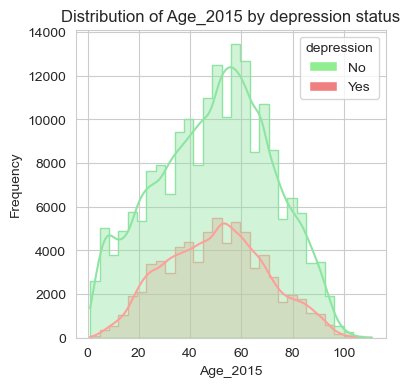

===== Num_Risks =====


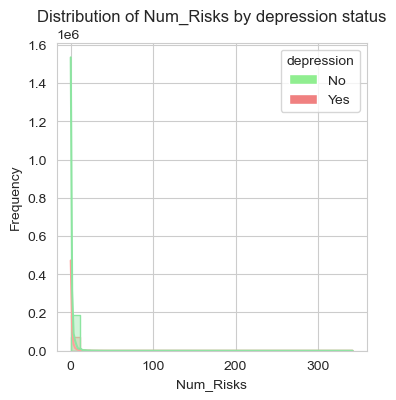

===== Total_Overall_Diagnoses =====


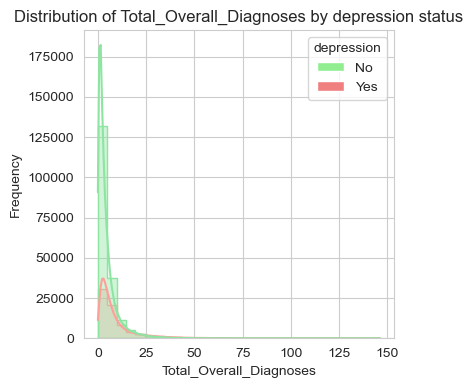

===== Total_Encounters =====


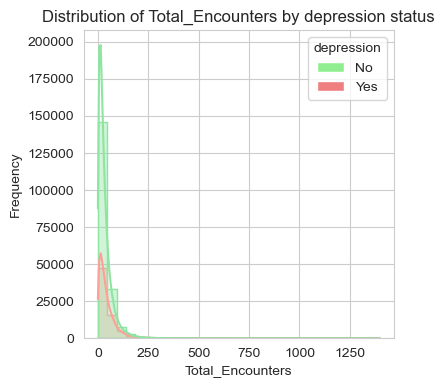

===== Lab_Risk_Proportion =====


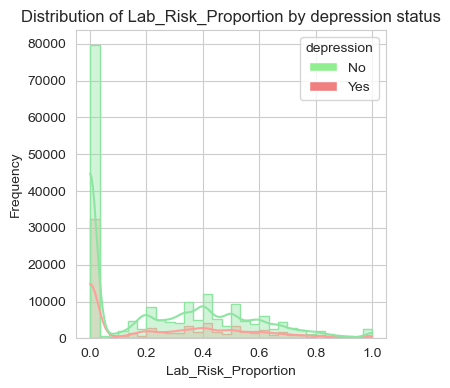

===== Num_Chronic =====


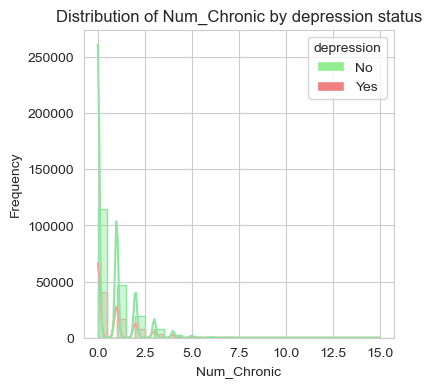

===== Total_Medications =====


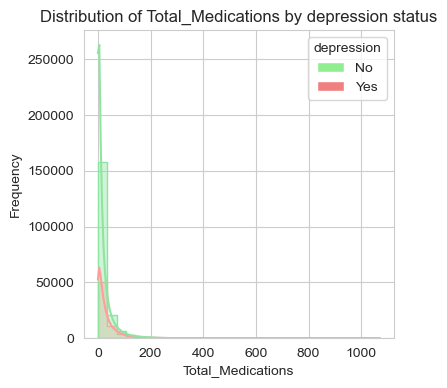

===== Total_MedProcs =====


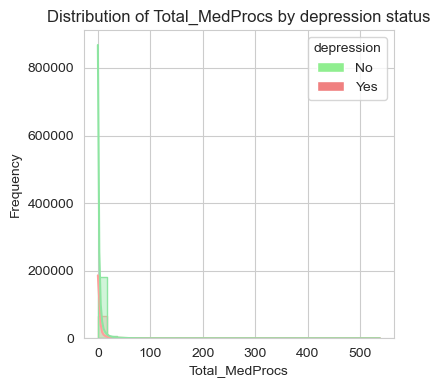

===== Num_PhysComorb =====


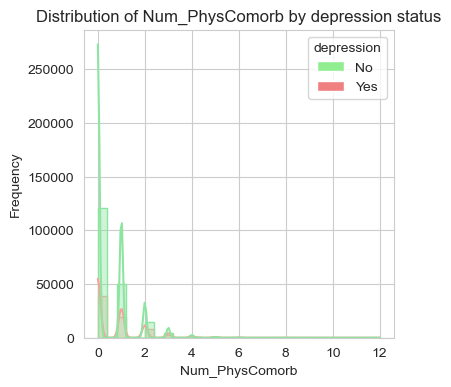

===== LongTermMeds_Num =====


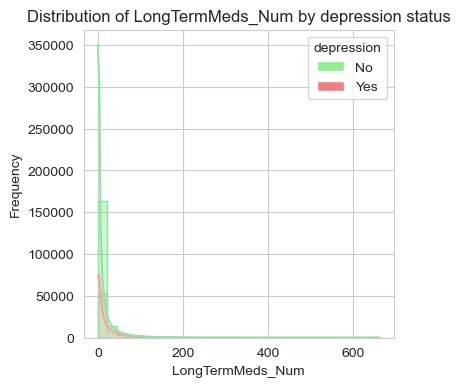

===== ShortTermMeds_Num =====


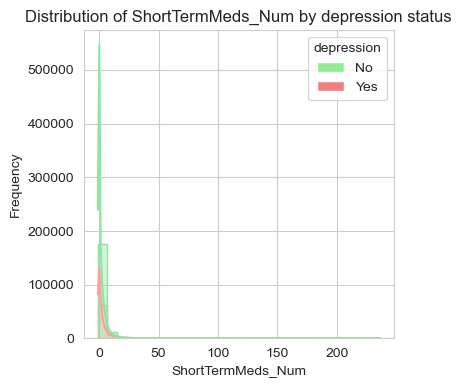

In [52]:
continuous_columns = ['Age_2015', 'Num_Risks', 'Total_Overall_Diagnoses', 'Total_Encounters', 'Lab_Risk_Proportion', 
                      'Num_Chronic', 'Total_Medications', 'Total_MedProcs', 'Num_PhysComorb', 'LongTermMeds_Num',
                     'ShortTermMeds_Num']

palette = sns.color_palette("pastel")
category_colours = [palette[2], palette[3]]
sns.set_style("whitegrid")

# does not appear to be significant differences in distributions between individuals with and without MHDs
for c in continuous_columns:
    make_histplot(df_ft1, c, groupby='HasMHD', category_colours=category_colours)
    # make_boxplot(df, c, groupby) (removed, redundant)

In [53]:
def assess_categorical(df, col: str, groupby: str):
  """
  Check distribution of classes in categorical by target category
  """
  print(f"Column: {col}\n")
  print(df[col].value_counts(normalize = True)*100)

  plt.figure(figsize=(10, 5))
  sns.countplot(data=df, x = col, hue=groupby, palette=category_colours)
  plt.xticks(rotation=45)
  plt.xlabel(col)
  plt.ylabel('Count')
  plt.title(f'Count of {col}')
  plt.show()

  print("\n")

=====Parkinson's disease_OneHot=====
Column: Parkinson's disease_OneHot

Parkinson's disease_OneHot
0    99.687167
1     0.312833
Name: proportion, dtype: float64


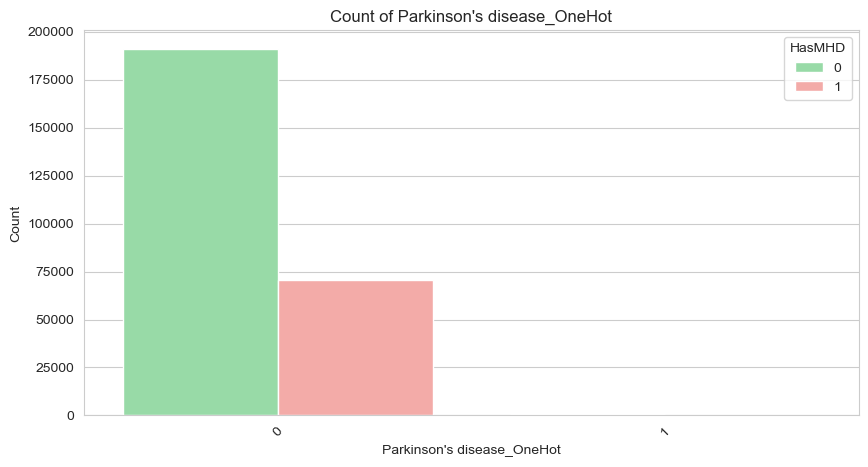



=====Fibryomyalgia_OneHot=====
Column: Fibryomyalgia_OneHot

Fibryomyalgia_OneHot
0    99.722941
1     0.277059
Name: proportion, dtype: float64


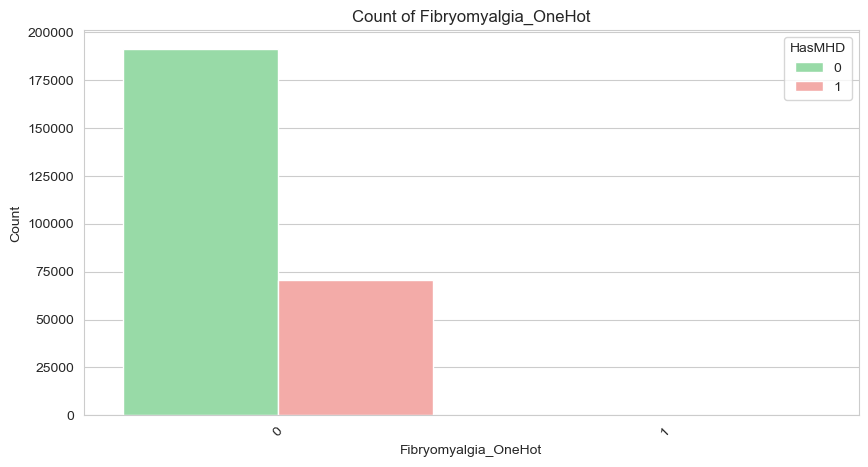



=====Back pain_OneHot=====
Column: Back pain_OneHot

Back pain_OneHot
0    95.143477
1     4.856523
Name: proportion, dtype: float64


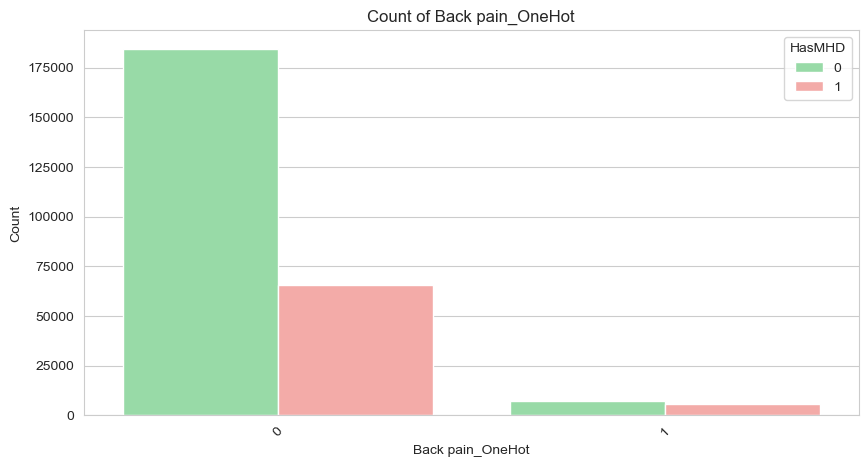



=====Pain in joint_OneHot=====
Column: Pain in joint_OneHot

Pain in joint_OneHot
0    98.978536
1     1.021464
Name: proportion, dtype: float64


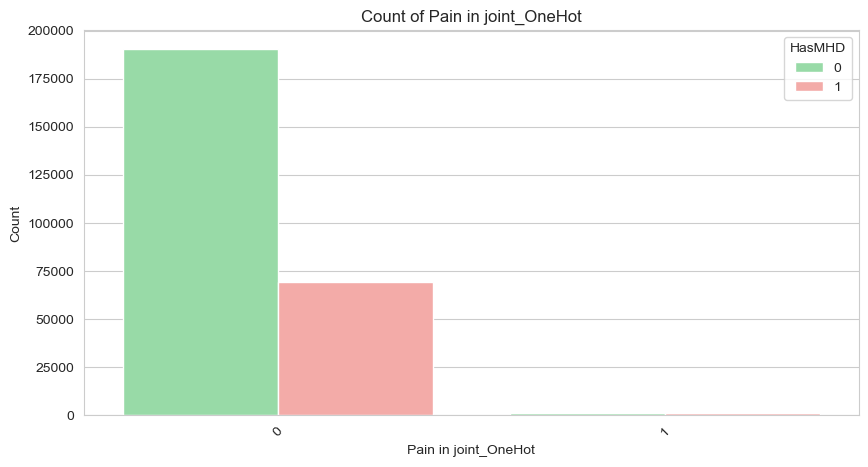



=====Mitral valve prolapse_OneHot=====
Column: Mitral valve prolapse_OneHot

Mitral valve prolapse_OneHot
0    99.912848
1     0.087152
Name: proportion, dtype: float64


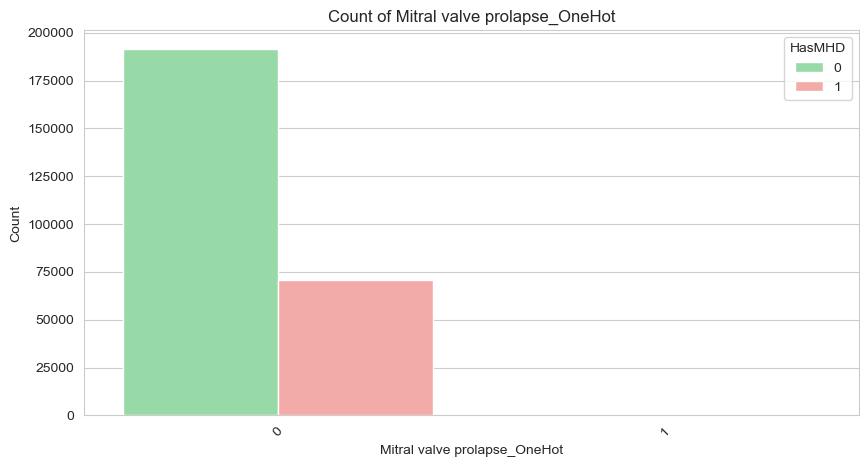



=====Status_Inactive=====
Column: Status_Inactive

Status_Inactive
0    94.11364
1     5.88636
Name: proportion, dtype: float64


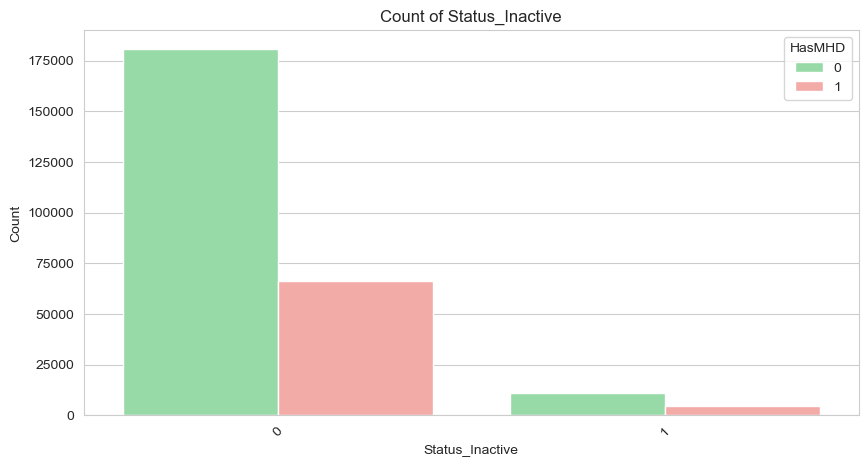



=====Chest pain_OneHot=====
Column: Chest pain_OneHot

Chest pain_OneHot
0    99.691734
1     0.308266
Name: proportion, dtype: float64


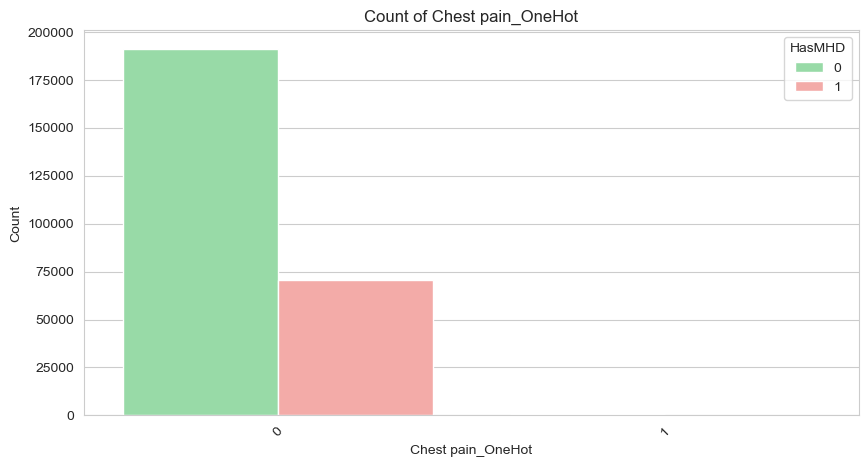



=====Colitis_OneHot=====
Column: Colitis_OneHot

Colitis_OneHot
0    99.202694
1     0.797306
Name: proportion, dtype: float64


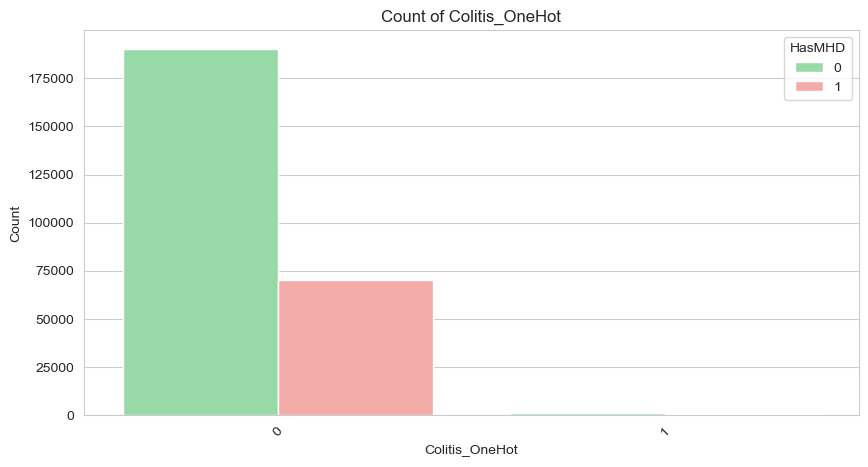



=====Rheumatoid arthritis_OneHot=====
Column: Rheumatoid arthritis_OneHot

Rheumatoid arthritis_OneHot
0    99.461486
1     0.538514
Name: proportion, dtype: float64


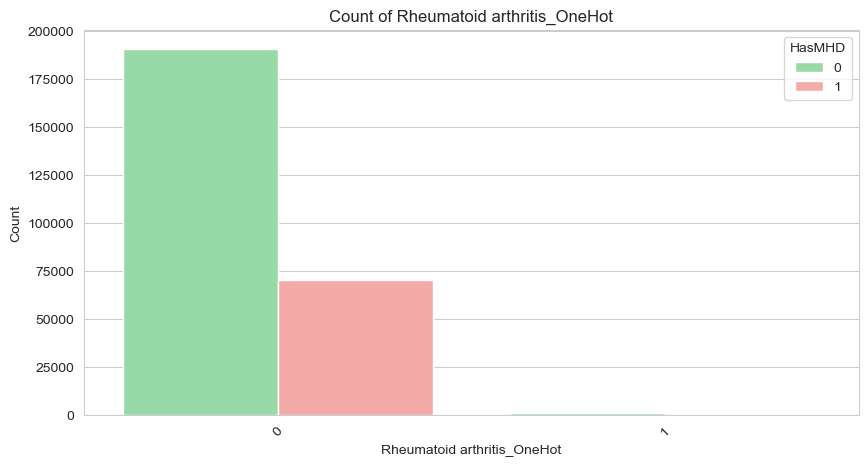



=====Essential (primary) hypertension_OneHot=====
Column: Essential (primary) hypertension_OneHot

Essential (primary) hypertension_OneHot
0    91.873953
1     8.126047
Name: proportion, dtype: float64


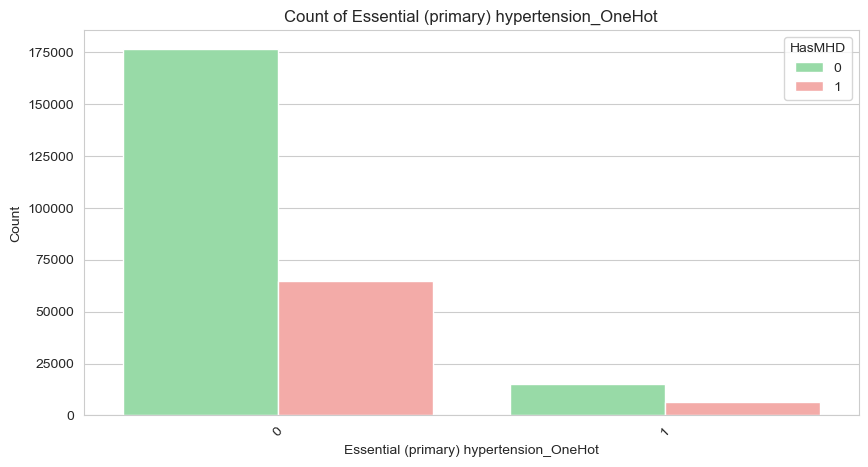



=====Diabetes_OneHot=====
Column: Diabetes_OneHot

Diabetes_OneHot
0    94.949003
1     5.050997
Name: proportion, dtype: float64


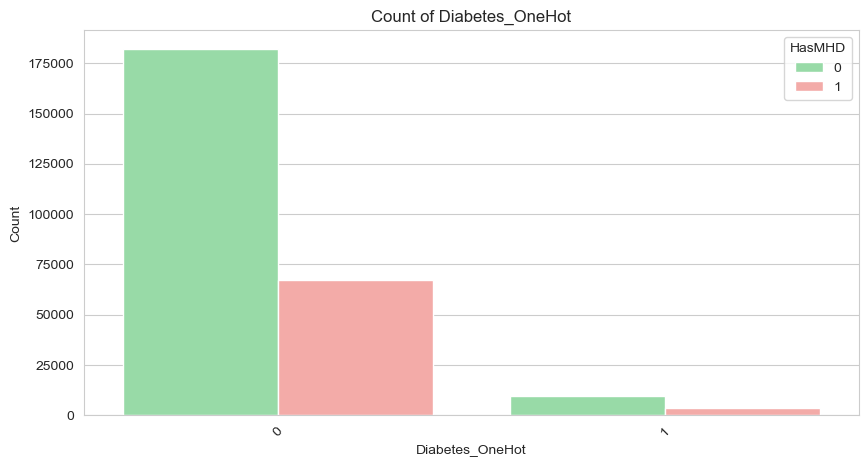



=====Chronic pain_OneHot=====
Column: Chronic pain_OneHot

Chronic pain_OneHot
0    99.73512
1     0.26488
Name: proportion, dtype: float64


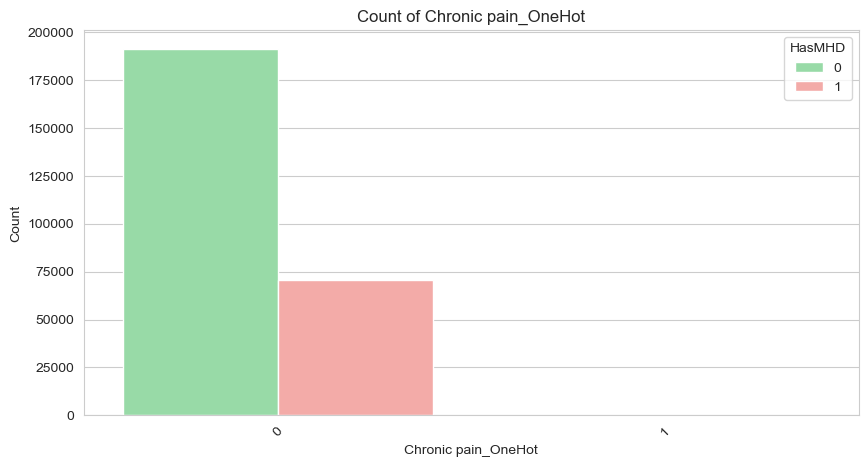



=====Status_Deceased=====
Column: Status_Deceased

Status_Deceased
0    97.531207
1     2.468793
Name: proportion, dtype: float64


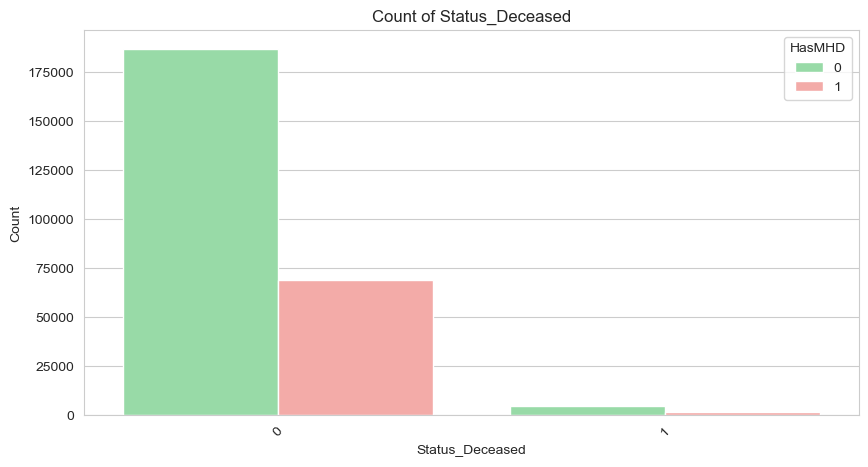



=====Acute coronary syndrome_OneHot=====
Column: Acute coronary syndrome_OneHot

Acute coronary syndrome_OneHot
0    99.980971
1     0.019029
Name: proportion, dtype: float64


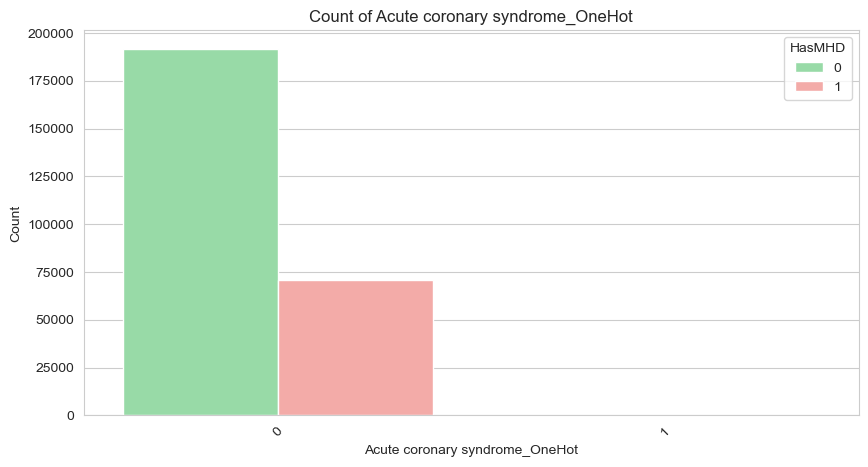



=====Gallbladder problems_OneHot=====
Column: Gallbladder problems_OneHot

Gallbladder problems_OneHot
0    98.608236
1     1.391764
Name: proportion, dtype: float64


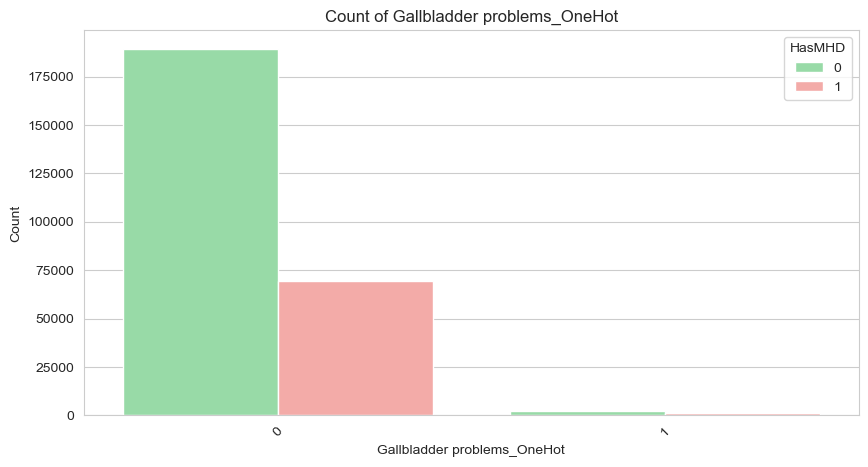



=====Angina pectoris_OneHot=====
Column: Angina pectoris_OneHot

Angina pectoris_OneHot
0    99.310778
1     0.689222
Name: proportion, dtype: float64


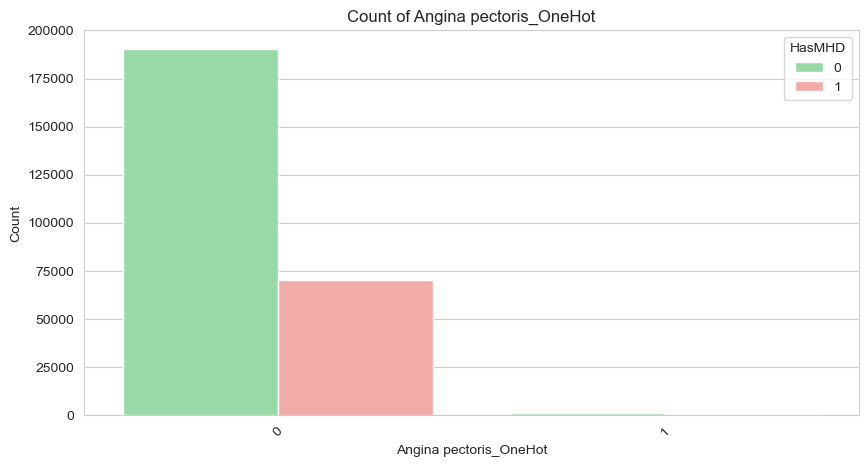



=====Acute upper respiratory infections of multiple or unspecified sites_OneHot=====
Column: Acute upper respiratory infections of multiple or unspecified sites_OneHot

Acute upper respiratory infections of multiple or unspecified sites_OneHot
0    99.970696
1     0.029304
Name: proportion, dtype: float64


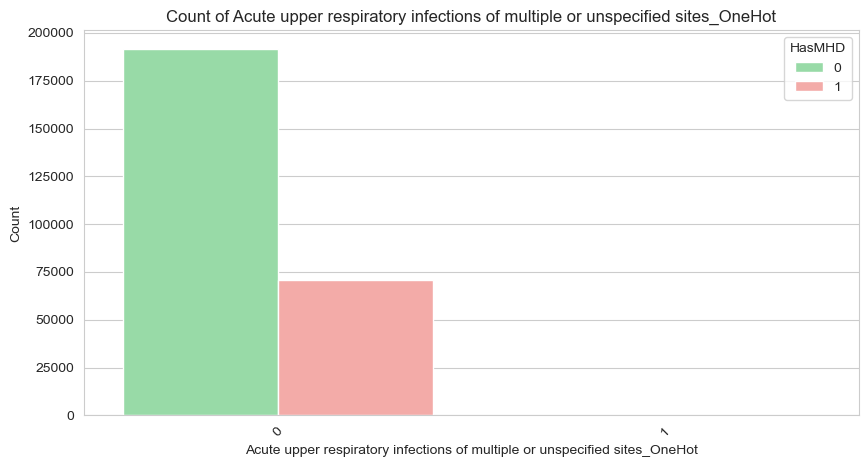



=====Rash and other nonspecific skin eruption_OneHot=====
Column: Rash and other nonspecific skin eruption_OneHot

Rash and other nonspecific skin eruption_OneHot
0    98.743721
1     1.256279
Name: proportion, dtype: float64


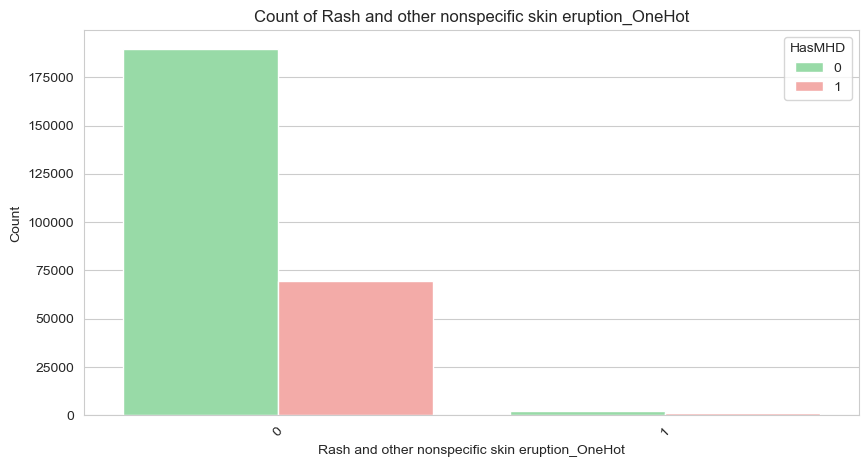



=====Pain_OneHot=====
Column: Pain_OneHot

Pain_OneHot
0    99.985158
1     0.014842
Name: proportion, dtype: float64


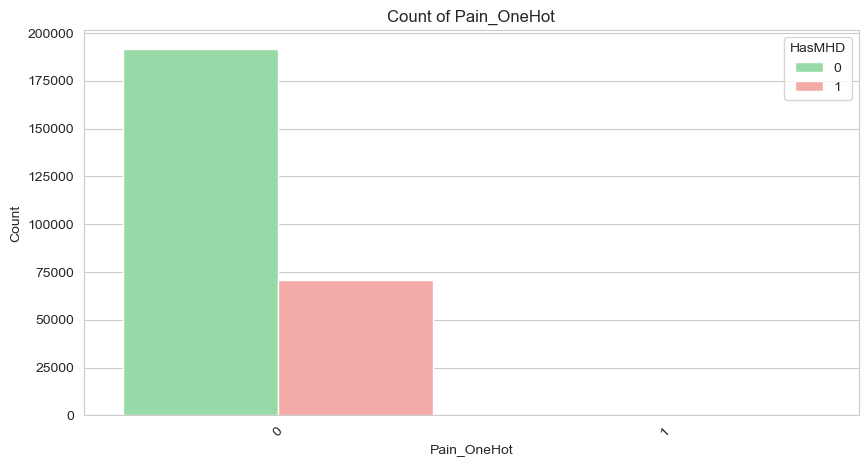



=====Constipation_OneHot=====
Column: Constipation_OneHot

Constipation_OneHot
0    99.337799
1     0.662201
Name: proportion, dtype: float64


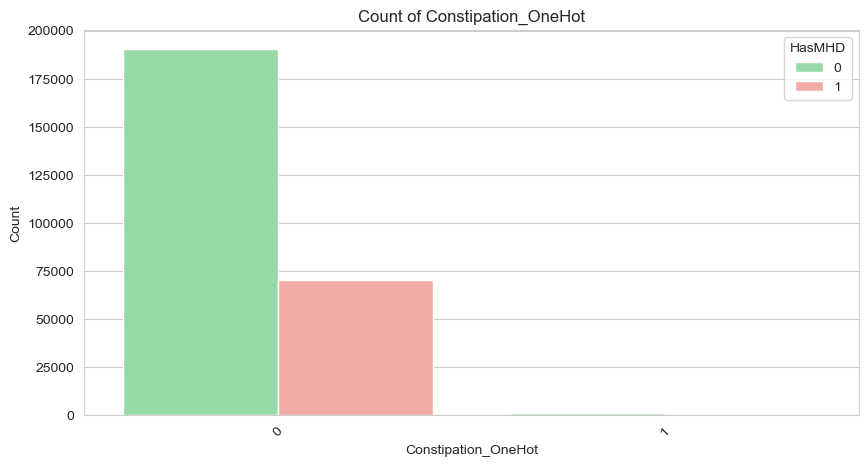



=====HIV/AIDS_OneHot=====
Column: HIV/AIDS_OneHot

HIV/AIDS_OneHot
0    100.0
Name: proportion, dtype: float64


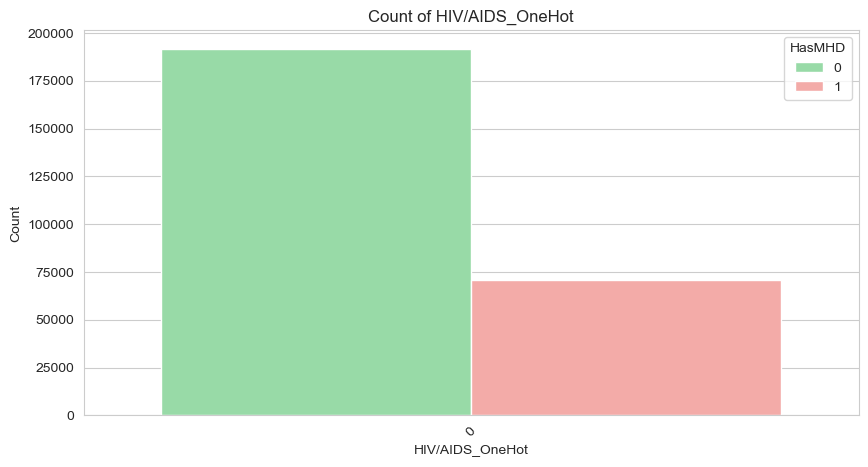



=====Myocardial infarction_OneHot=====
Column: Myocardial infarction_OneHot

Myocardial infarction_OneHot
0    99.371289
1     0.628711
Name: proportion, dtype: float64


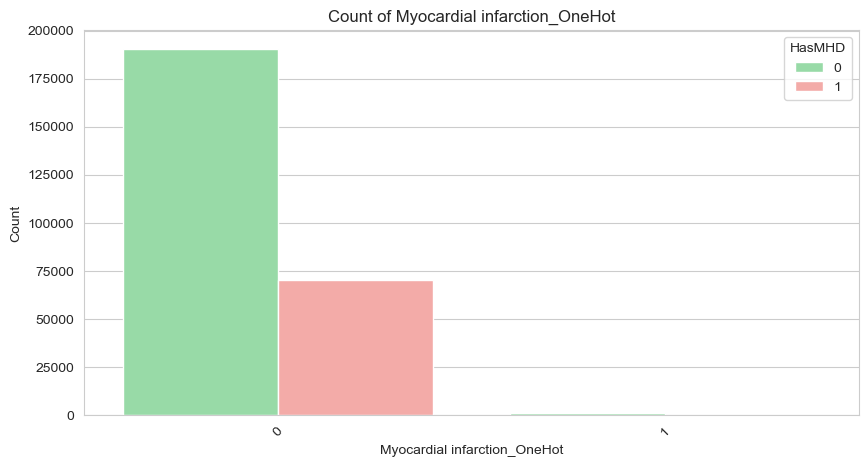



=====Migraine_OneHot=====
Column: Migraine_OneHot

Migraine_OneHot
0    99.395646
1     0.604354
Name: proportion, dtype: float64


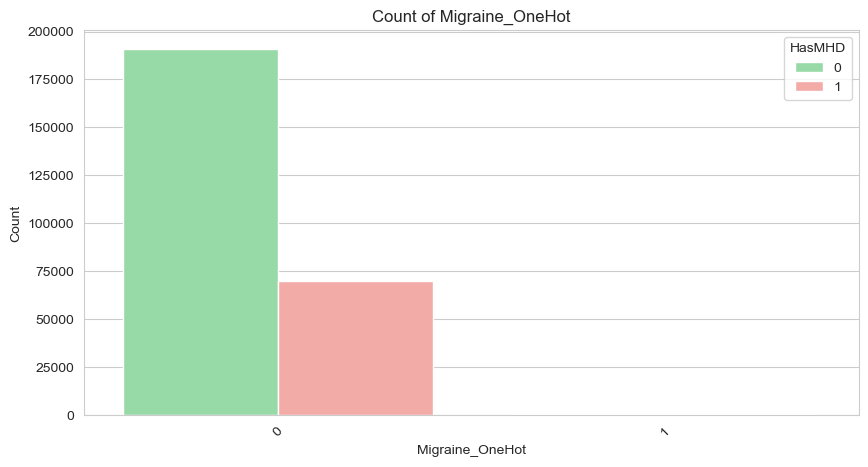



=====Chronic kidney disease_OneHot=====
Column: Chronic kidney disease_OneHot

Chronic kidney disease_OneHot
0    99.880119
1     0.119881
Name: proportion, dtype: float64


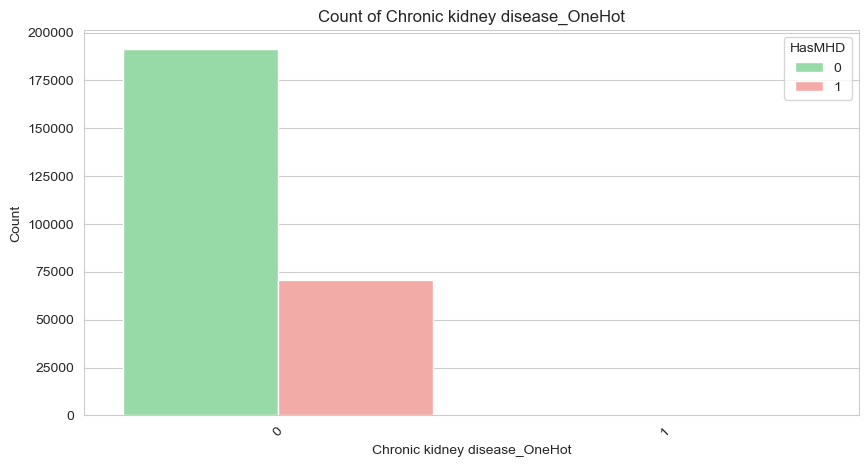



=====Spinal pain_OneHot=====
Column: Spinal pain_OneHot

Spinal pain_OneHot
0    99.969935
1     0.030065
Name: proportion, dtype: float64


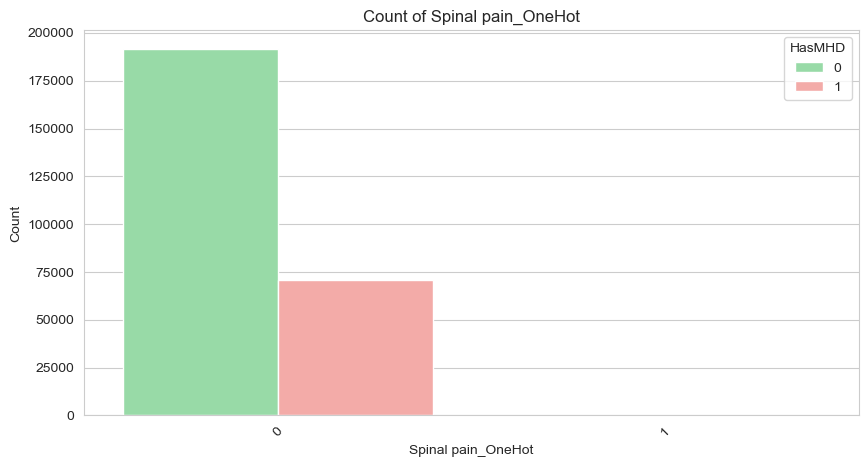



=====Sex_Bin=====
Column: Sex_Bin

Sex_Bin
1.0    60.625195
0.0    39.374805
Name: proportion, dtype: float64


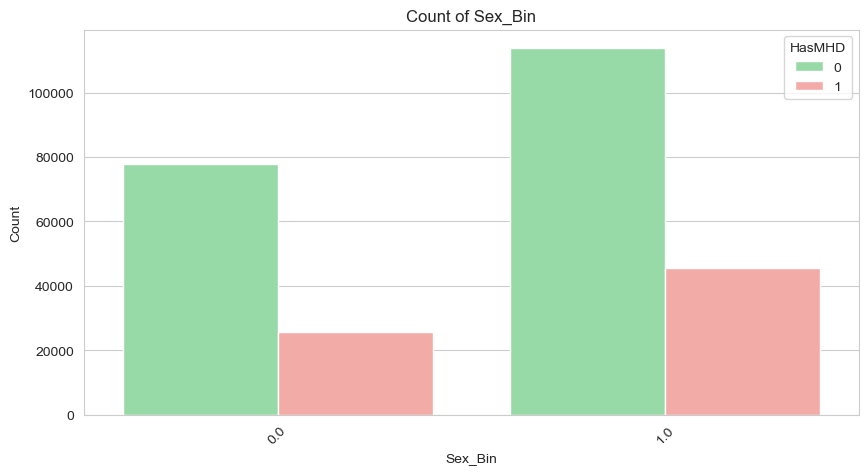



=====Gastroesophageal reflux_OneHot=====
Column: Gastroesophageal reflux_OneHot

Gastroesophageal reflux_OneHot
0    97.791901
1     2.208099
Name: proportion, dtype: float64


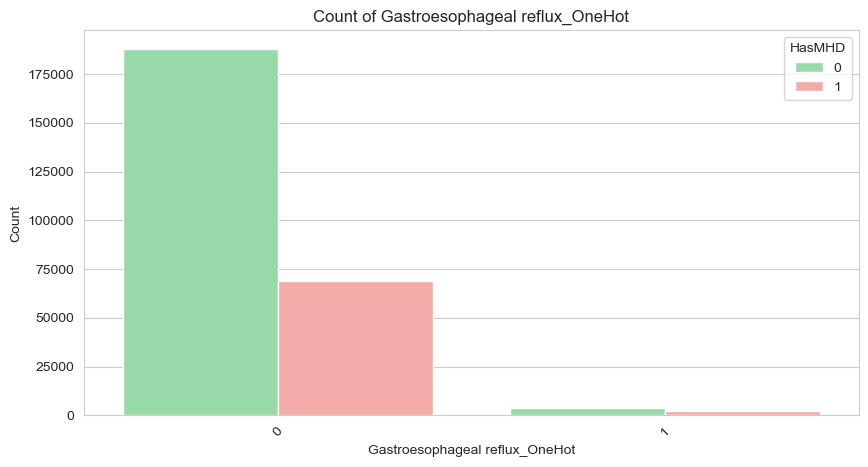



=====Viral hepatitis_OneHot=====
Column: Viral hepatitis_OneHot

Viral hepatitis_OneHot
0    100.0
Name: proportion, dtype: float64


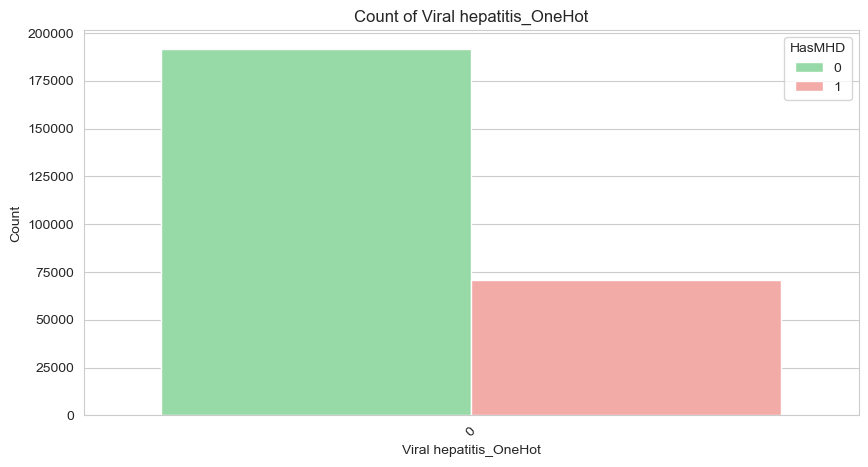



=====Congestive heart failure_OneHot=====
Column: Congestive heart failure_OneHot

Congestive heart failure_OneHot
0    99.531512
1     0.468488
Name: proportion, dtype: float64


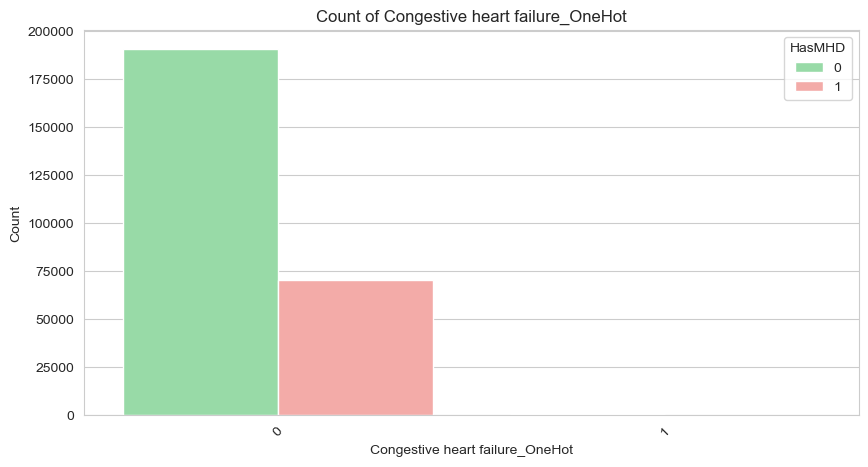



=====Tachycardia_OneHot=====
Column: Tachycardia_OneHot

Tachycardia_OneHot
0    99.565383
1     0.434617
Name: proportion, dtype: float64


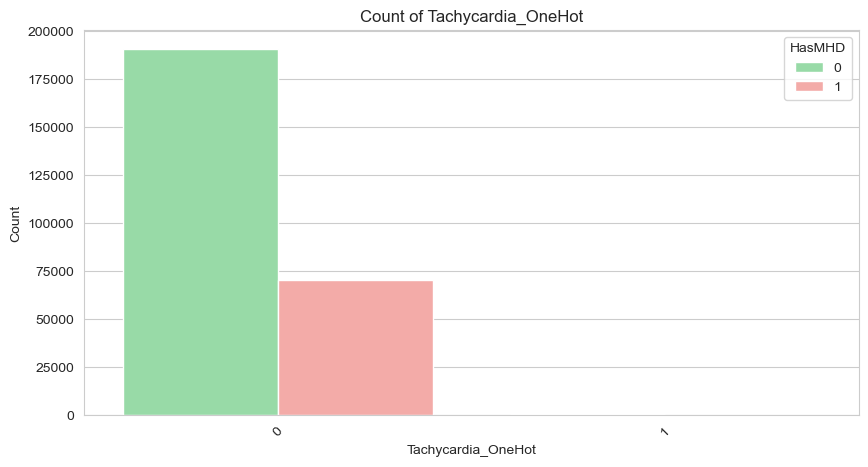



=====Nonspecific chest pain_OneHot=====
Column: Nonspecific chest pain_OneHot

Nonspecific chest pain_OneHot
0    98.049931
1     1.950069
Name: proportion, dtype: float64


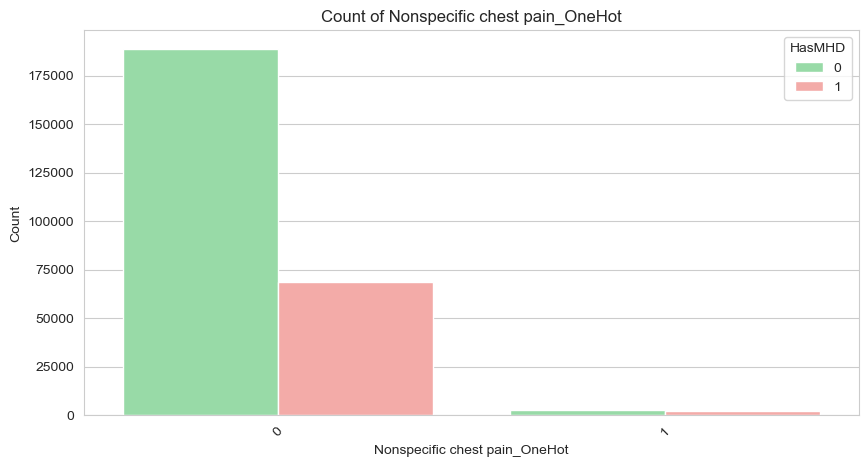



=====COPD (asthma, emphysema,  bronchitis)_OneHot=====
Column: COPD (asthma, emphysema,  bronchitis)_OneHot

COPD (asthma, emphysema,  bronchitis)_OneHot
0    91.609834
1     8.390166
Name: proportion, dtype: float64


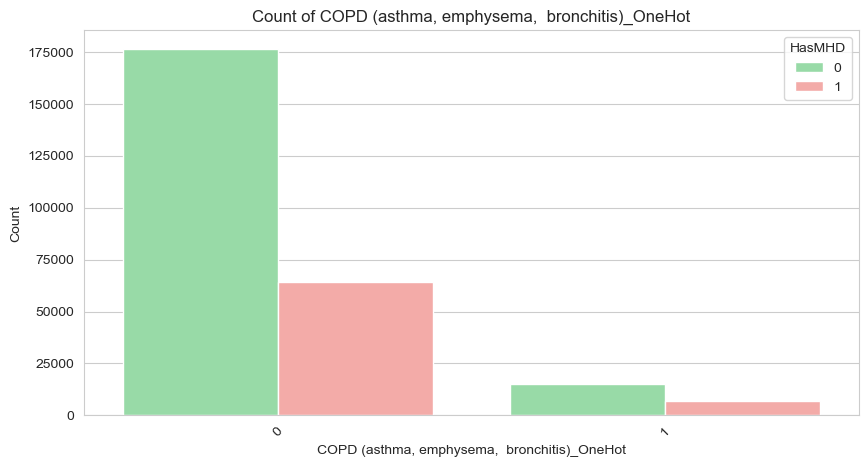



=====Dyspepsia_OneHot=====
Column: Dyspepsia_OneHot

Dyspepsia_OneHot
0    99.376998
1     0.623002
Name: proportion, dtype: float64


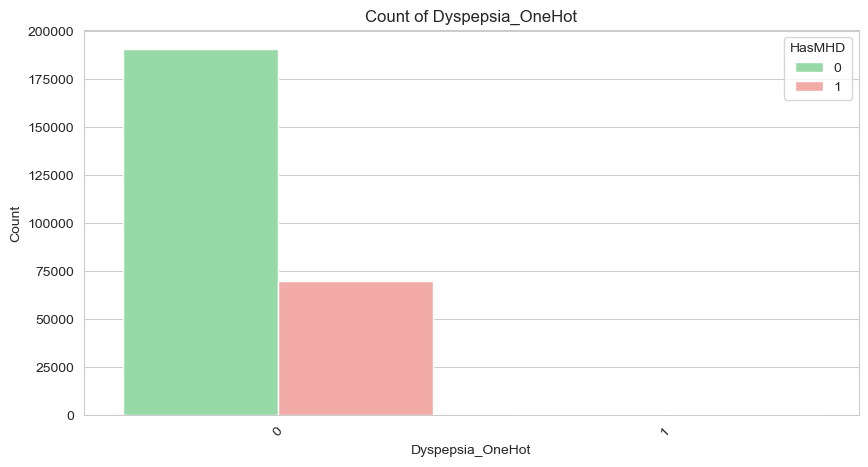



=====Liver disease_OneHot=====
Column: Liver disease_OneHot

Liver disease_OneHot
0    99.333612
1     0.666388
Name: proportion, dtype: float64


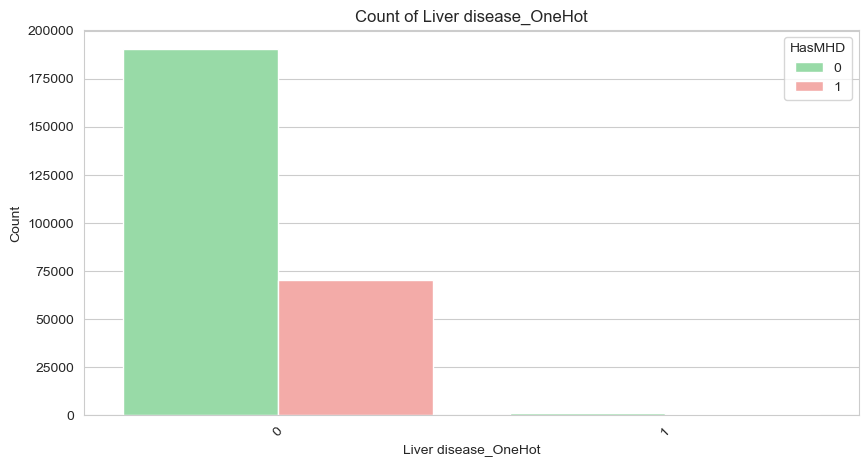



=====End-stage renal disease_OneHot=====
Column: End-stage renal disease_OneHot

End-stage renal disease_OneHot
0    99.97983
1     0.02017
Name: proportion, dtype: float64


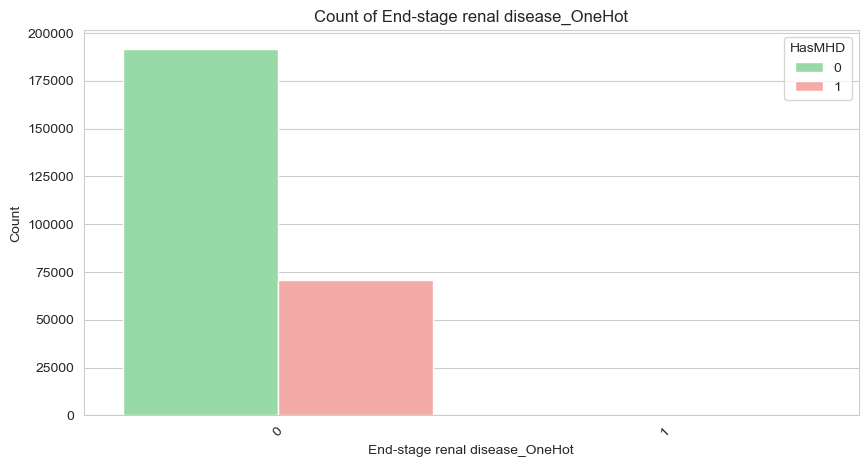



=====Arteriosclerosis/Atherosclerosis_OneHot=====
Column: Arteriosclerosis/Atherosclerosis_OneHot

Arteriosclerosis/Atherosclerosis_OneHot
0    99.824935
1     0.175065
Name: proportion, dtype: float64


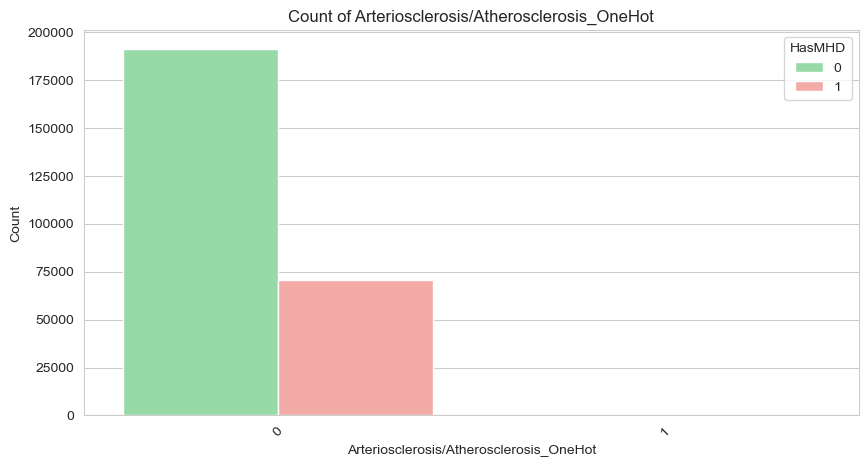



=====Status_Unknown=====
Column: Status_Unknown

Status_Unknown
0    75.772949
1    24.227051
Name: proportion, dtype: float64


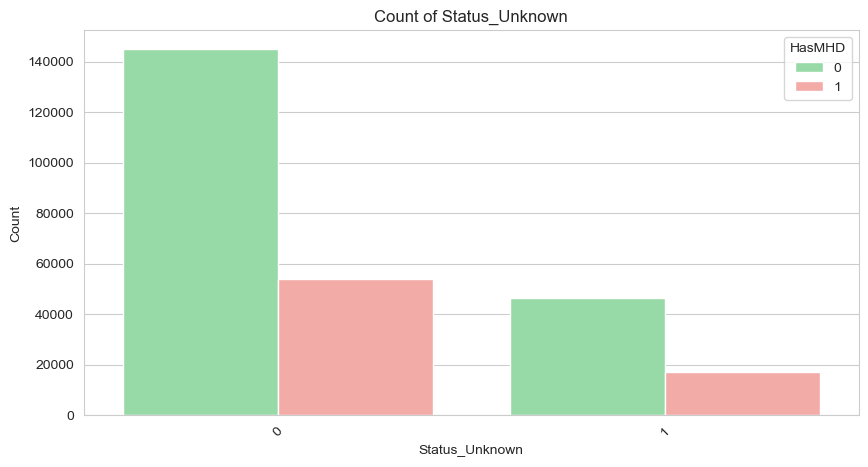



=====Status_Active=====
Column: Status_Active

Status_Active
1    67.322271
0    32.677729
Name: proportion, dtype: float64


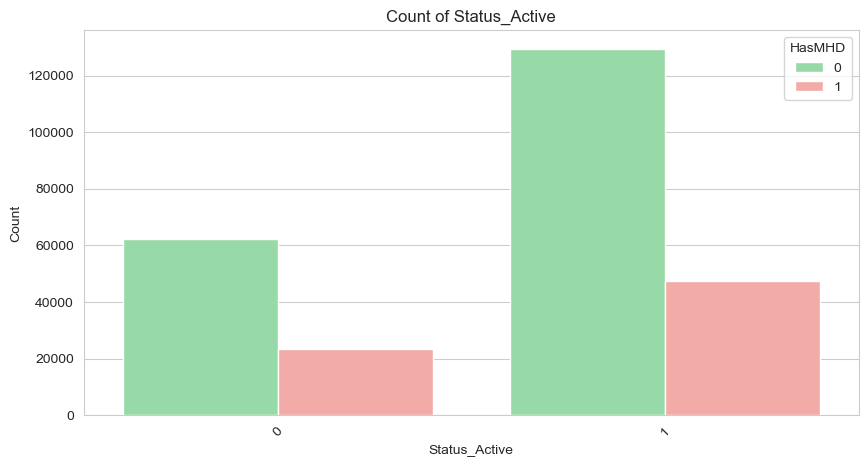



=====Irritable bowel syndrome (IBS)_OneHot=====
Column: Irritable bowel syndrome (IBS)_OneHot

Irritable bowel syndrome (IBS)_OneHot
0    98.435074
1     1.564926
Name: proportion, dtype: float64


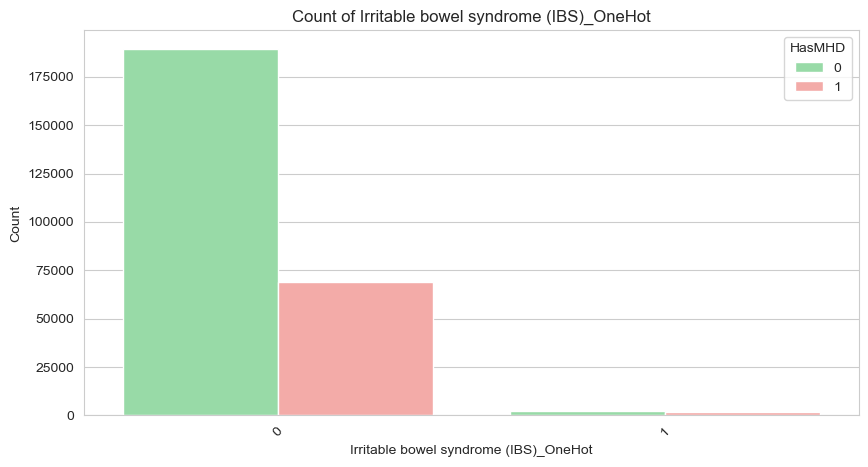



=====Blindness_OneHot=====
Column: Blindness_OneHot

Blindness_OneHot
0    99.787258
1     0.212742
Name: proportion, dtype: float64


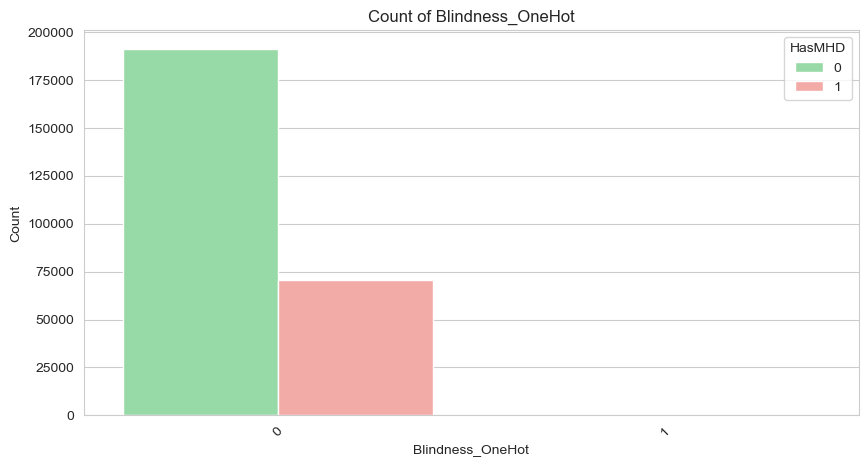



=====Stroke_OneHot=====
Column: Stroke_OneHot

Stroke_OneHot
0    98.845334
1     1.154666
Name: proportion, dtype: float64


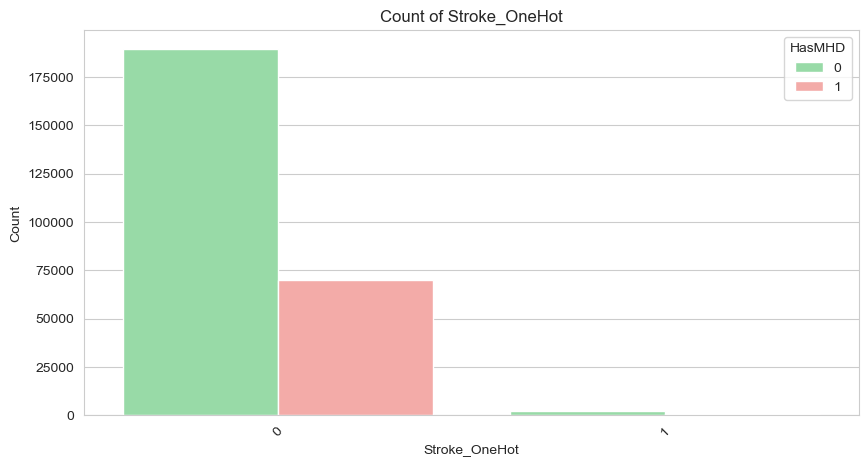



=====Epilepsy_OneHot=====
Column: Epilepsy_OneHot

Epilepsy_OneHot
0    99.211448
1     0.788552
Name: proportion, dtype: float64


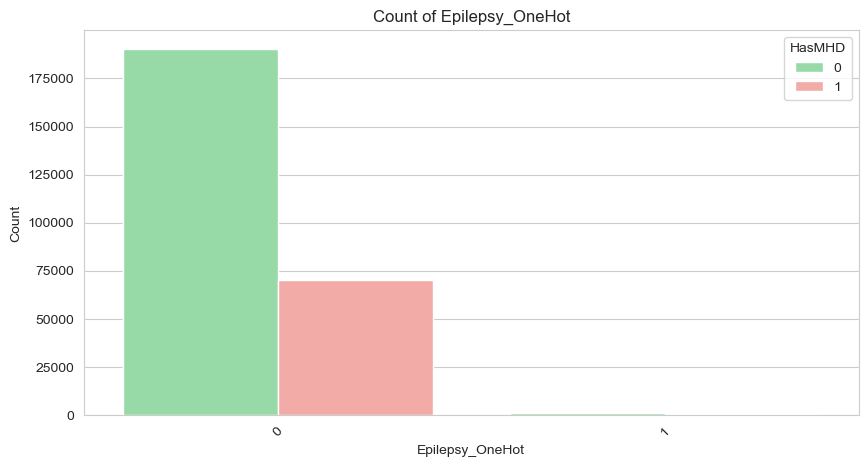



=====Abnormal movement_OneHot=====
Column: Abnormal movement_OneHot

Abnormal movement_OneHot
0    98.739915
1     1.260085
Name: proportion, dtype: float64


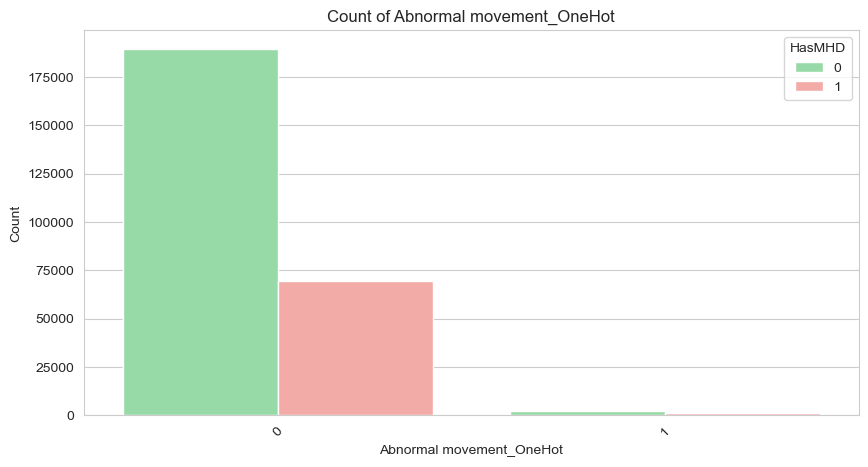

In [54]:
categorical_columns = list(set(ft1) - set(continuous_columns))
categorical_columns.remove('HasMHD')

for c in categorical_columns:
  print(f"====={c}=====")
  assess_categorical(df, c, groupby="HasMHD")

In [55]:
df_ft1.drop(['HIV/AIDS_OneHot', 'Viral hepatitis_OneHot'], axis=1)

Sex_Bin  Age_2015  Num_Risks  Total_Overall_Diagnoses  \
0           0.0      43.0          2                        0   
1           0.0      50.0          2                        3   
2           1.0      60.0          1                        2   
3           1.0      66.0          2                        1   
4           0.0      50.0          0                        5   
...         ...       ...        ...                      ...   
262755      0.0      28.0          0                        1   
262756      0.0      44.0          2                        3   
262757      0.0      17.0          0                        1   
262758      1.0      51.0          2                        2   
262759      0.0      55.0          2                        2   

        Total_Encounters  Lab_Risk_Proportion  Num_Chronic  Total_Medications  \
0                    133             0.200000            0                 12   
1                     13             0.312500            1                  3   
2                     16             0.500000            0                  4   
3                     44             0.428571            0                 17   
4                     33             0.703704            2                  8   
...                  ...                  ...          ...                ...   
262755                 1             0.000000            0                  1   
262756                 2             0.000000            0                  4   
262757                 1             0.000000            0                  1   
262758                 4             0.000000            0                  2   
262759                 6             0.000000            0                  2   

        Total_MedProcs  Status_Active  ...  Mitral valve prolapse_OneHot  \
0                    0              1  ...                             0   
1                    0              1  ...                             0   
2                    1              1  ...                             0   
3                    2              1  ...                             0   
4                    2              1  ...                             0   
...                ...            ...  ...                           ...   
262755               0              0  ...                             0   
262756               1              0  ...                             0   
262757               0              0  ...                             0   
262758               1              0  ...                             0   
262759               0              0  ...                             0   

        Gallbladder problems_OneHot  Colitis_OneHot  Back pain_OneHot  \
0                                 0               0                 0   
1                                 0               0                 0   
2                                 0               0                 0   
3                                 0               0                 0   
4                                 0               0                 0   
...                             ...             ...               ...   
262755                            0               0                 0   
262756                            0               0                 0   
262757                            0               0                 0   
262758                            0               0                 0   
262759                            0               0                 0   

        Pain_OneHot  Epilepsy_OneHot  Num_PhysComorb  LongTermMeds_Num  \
0                 0                0               0                 1   
1                 0                0               1                 1   
2                 0                0               0                 0   
3                 0                0               0                 5   
4                 0                0               1                 1   
...             ... 

## Featureset 1

In [44]:
ft1 = ['Sex_Bin', 'Age_2015', 'Num_Risks', 'Total_Overall_Diagnoses', 'Total_Encounters',
      'Lab_Risk_Proportion', 'Num_Chronic', 'Total_Medications', 'Total_MedProcs',
      'Status_Active', 'Status_Deceased', 'Status_Inactive', 'Status_Unknown',
      'Diabetes_OneHot', 'Essential (primary) hypertension_OneHot', 'COPD (asthma, emphysema,  bronchitis)_OneHot', 
      'Viral hepatitis_OneHot', 'Chronic pain_OneHot', 'Rheumatoid arthritis_OneHot', 'Myocardial infarction_OneHot', 
      "Parkinson's disease_OneHot", 'Stroke_OneHot', 'Angina pectoris_OneHot', 'Liver disease_OneHot', 
      'Migraine_OneHot', 'Constipation_OneHot', 'Spinal pain_OneHot', 'Congestive heart failure_OneHot', 
      'Fibryomyalgia_OneHot', 'Rash and other nonspecific skin eruption_OneHot', 'End-stage renal disease_OneHot',
      'Abnormal movement_OneHot', 'Gastroesophageal reflux_OneHot', 'HIV/AIDS_OneHot',
      'Acute upper respiratory infections of multiple or unspecified sites_OneHot', 
      'Chronic kidney disease_OneHot', 'Chest pain_OneHot', 'Tachycardia_OneHot',
      'Arteriosclerosis/Atherosclerosis_OneHot', 'Pain in joint_OneHot', 'Blindness_OneHot',
      'Nonspecific chest pain_OneHot', 'Dyspepsia_OneHot', 'Irritable bowel syndrome (IBS)_OneHot', 
      'Acute coronary syndrome_OneHot', 'Mitral valve prolapse_OneHot', 'Gallbladder problems_OneHot', 
      'Colitis_OneHot', 'Back pain_OneHot', 'Pain_OneHot', 'Epilepsy_OneHot', 'Num_PhysComorb',
      'LongTermMeds_Num', 'ShortTermMeds_Num', 'HasMHD'] # Proportion of abnormal lab tests, includes 'Total_Overall_Diagnoses', 'Total_Encounters'


# Potentially problematic features based on td's discussion: any counts:
## 'Total_Overall_Diagnoses', 'Total_Encounters', 'Total_LabTests'

df_ft1 = df[ft1]

df_ft1.head(10)

Sex_Bin  Age_2015  Num_Risks  Total_Overall_Diagnoses  Total_Encounters  \
0      0.0      43.0          2                        0               133   
1      0.0      50.0          2                        3                13   
2      1.0      60.0          1                        2                16   
3      1.0      66.0          2                        1                44   
4      0.0      50.0          0                        5                33   
5      1.0      53.0          2                        2                23   
6      0.0      43.0          2                        0                37   
7      1.0      27.0          2                        4                96   
8      0.0      62.0          2                        3               101   
9      1.0      62.0          2                        4                88   

   Lab_Risk_Proportion  Num_Chronic  Total_Medications  Total_MedProcs  \
0             0.200000            0                 12               0   
1             0.312500            1                  3               0   
2             0.500000            0                  4               1   
3             0.428571            0                 17               2   
4             0.703704            2                  8               2   
5             0.454545            0                 18               1   
6             0.500000            0                 13               0   
7             0.000000            0                 35               2   
8             0.064516            0                 41               0   
9             0.181818            0                 26               4   

   Status_Active  ...  Mitral valve prolapse_OneHot  \
0              1  ...                             0   
1              1  ...                             0   
2              1  ...                             0   
3              1  ...                             0   
4              1  ...                             0   
5              1  ...                             0   
6              1  ...                             0   
7              1  ...                             0   
8              1  ...                             0   
9              1  ...                             0   

   Gallbladder problems_OneHot  Colitis_OneHot  Back pain_OneHot  Pain_OneHot  \
0                            0               0                 0            0   
1                            0               0                 0            0   
2                            0               0                 0            0   
3                            0               0                 0            0   
4                            0               0                 0            0   
5                            0               0                 0            0   
6                            0               0                 0            0   
7                            0               0                 1            0   
8                            0               0                 0            0   
9                            0               0                 0            0   

   Epilepsy_OneHot  Num_PhysComorb  LongTermMeds_Num  ShortTermMeds_Num  \
0                0               0                 1                  2   
1                0               1                 1                  0   
2                0               0                 0                  0   
3                0               0                 5                  8   
4                0               1                 1                  1   
5                0               0                11                  2   
6                0               0                 8                  1   
7                0               1                 8                 16   
8                0               1                12                 14   
9                0               0                11                  8   

   Ha

In [47]:
df_ft1 = df_ft1[df_ft1['Age_2015'] > 0]
df_ft1['Age_2015'].describe()

count    262683.000000
mean         49.671973
std          21.801496
min           1.000000
25%          34.000000
50%          51.000000
75%          65.000000
max         111.000000
Name: Age_2015, dtype: float64

In [48]:
def count_nas(df):
  """
  DOCSTRING
  """
  tot = len(df)
  cols = list(df.columns)
  nas = [df[col].isna().sum() for col in cols]
  percent_nas = [na/tot * 100 for na in nas]

  na_df = pd.DataFrame.from_dict({"col": cols, "nas": nas, "percent_nas": percent_nas})
  na_df.sort_values(by = ["percent_nas"], ascending = False, inplace = True)
  na_df = na_df.reset_index(drop = True)

  return na_df

count_nas(df_ft1)

col    nas  percent_nas
0                                 Lab_Risk_Proportion  92836    35.341457
1                                             Sex_Bin     26     0.009898
2                       Nonspecific chest pain_OneHot      0     0.000000
3                      End-stage renal disease_OneHot      0     0.000000
4                            Abnormal movement_OneHot      0     0.000000
5                      Gastroesophageal reflux_OneHot      0     0.000000
6                                     HIV/AIDS_OneHot      0     0.000000
7   Acute upper respiratory infections of multiple...      0     0.000000
8                       Chronic kidney disease_OneHot      0     0.000000
9                                   Chest pain_OneHot      0     0.000000
10                                 Tachycardia_OneHot      0     0.000000
11            Arteriosclerosis/Atherosclerosis_OneHot      0     0.000000
12                               Pain in joint_OneHot      0     0.000000
13                                   Blindness_OneHot      0     0.000000
14                                   Dyspepsia_OneHot      0     0.000000
15                               Fibryomyalgia_OneHot      0     0.000000
16              Irritable bowel syndrome (IBS)_OneHot      0     0.000000
17                     Acute coronary syndrome_OneHot      0     0.000000
18                       Mitral valve prolapse_OneHot      0     0.000000
19                        Gallbladder problems_OneHot      0     0.000000
20                                     Colitis_OneHot      0     0.000000
21                                   Back pain_OneHot      0     0.000000
22                                        Pain_OneHot      0     0.000000
23                                    Epilepsy_OneHot      0     0.000000
24                                     Num_PhysComorb      0     0.000000
25                                   LongTermMeds_Num      0     0.000000
26                                  ShortTermMeds_Num      0     0.000000
27    Rash and other nonspecific skin eruption_OneHot      0     0.000000
28                    Congestive heart failure_OneHot      0     0.000000
29                                           Age_2015      0     0.000000
30                                 Spinal pain_OneHot      0     0.000000
31                                          Num_Risks      0     0.000000
32                            Total_Overall_Diagnoses      0     0.000000
33                                   Total_Encounters      0     0.000000
34                                        Num_Chronic      0     0.000000
35                                  Total_Medications      0     0.000000
36                                     Total_MedProcs      0     0.000000
37                                      Status_Active      0     0.000000
38                                    Status_Deceased      0     0.000000
39                                    Status_Inactive      0     0.000000
40                                     Status_Unknown      0     0.000000
41                                    Diabetes_OneHot      0     0.000000
42            Essential (primary) hypertension_OneHot      0     0.000000
43       COPD (asthma, emphysema,  bronchitis)_OneHot      0     0.000000
44                             Viral hepatitis_OneHot      0     0.000000
45                                Chronic pain_OneHot      0     0.000000
46                        Rheumatoid arthritis_OneHot      0     0.000000
47                       Myocardial infarction_OneHot      0     0.000000
48                         Parkinson's disease_OneHot      0     0.000000
49                                      Stroke_OneHot      0     0.000000
50                             Angina pectoris_OneHot      0     0.000000
51                               Liver disease_OneHot      0     0.000000
52                                    Migraine_OneHot      0     0.000000
53                                Constipation_OneHot 

In [49]:
df_ft1['Lab_Risk_Proportion'] = df_ft1['Lab_Risk_Proportion'].fillna(0) # the way Lab_Risk_Proportion was created returns 0 if there were no lab tests

### EDA: Featureset 1 Multicollinearity

In [56]:
def plot_problematic_corr(df, corr_threshold=0.7):
    """
    Identifies features in a DataFrame that have pairwise Pearson correlation coefficients
    above a specified threshold.
    """
    problematic_corr = []
    corr_matrix = df.corr()
    for c in corr_matrix.columns: # Iterate over columns
        for i in corr_matrix.index: # Iterate over index (rows)
            if c != i and corr_matrix.loc[i, c] > corr_threshold:  # Exclude self-correlation and check threshold
                problematic_corr.extend([c, i])  # Add both column and index if correlated

    return set(problematic_corr)

In [57]:
problematic_corr = plot_problematic_corr(df_ft1[continuous_columns])
problematic_corr

{'LongTermMeds_Num', 'Total_Medications'}

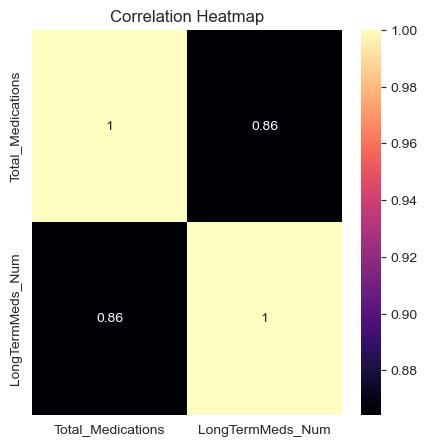

In [58]:
problematic_corr_matrix = df[list(problematic_corr)].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(problematic_corr_matrix, cmap="magma", annot=True)
plt.title("Correlation Heatmap")
plt.show() # lets drop Total_Medications

In [59]:
df_ft1 = df_ft1.drop(columns=['Total_Medications'], axis=1) # judged to be less informative
print(df_ft1.columns)

Index(['Sex_Bin', 'Age_2015', 'Num_Risks', 'Total_Overall_Diagnoses',
       'Total_Encounters', 'Lab_Risk_Proportion', 'Num_Chronic',
       'Total_MedProcs', 'Status_Active', 'Status_Deceased', 'Status_Inactive',
       'Status_Unknown', 'Diabetes_OneHot',
       'Essential (primary) hypertension_OneHot',
       'COPD (asthma, emphysema,  bronchitis)_OneHot',
       'Viral hepatitis_OneHot', 'Chronic pain_OneHot',
       'Rheumatoid arthritis_OneHot', 'Myocardial infarction_OneHot',
       'Parkinson's disease_OneHot', 'Stroke_OneHot', 'Angina pectoris_OneHot',
       'Liver disease_OneHot', 'Migraine_OneHot', 'Constipation_OneHot',
       'Spinal pain_OneHot', 'Congestive heart failure_OneHot',
       'Fibryomyalgia_OneHot',
       'Rash and other nonspecific skin eruption_OneHot',
       'End-stage renal disease_OneHot', 'Abnormal movement_OneHot',
       'Gastroesophageal reflux_OneHot', 'HIV/AIDS_OneHot',
       'Acute upper respiratory infections of multiple or unspecified sites

## Featureset 2

In [72]:
ft2 = ['Sex_Bin', 'Age_2015', 'Num_Risks', 'Total_Overall_Diagnoses', 'Total_Encounters', 'Total_LabTests',
      'Lab_Risk_Proportion', 'Num_Chronic', 'Total_Medications', 'Total_MedProcs', 'HasMHD',
      'Status_Active', 'Status_Deceased', 'Status_Inactive', 'Status_Unknown'] # Proportion of abnormal lab tests 

df_ft2 = df[ft2]
df_ft2.head(10)

Sex_Bin  Age_2015  Num_Risks  Total_Overall_Diagnoses  Total_Encounters  \
0      0.0      43.0          2                        0               133   
1      0.0      50.0          2                        3                13   
2      1.0      60.0          1                        2                16   
3      1.0      66.0          2                        1                44   
4      0.0      50.0          0                        5                33   
5      1.0      53.0          2                        2                23   
6      0.0      43.0          2                        0                37   
7      1.0      27.0          2                        4                96   
8      0.0      62.0          2                        3               101   
9      1.0      62.0          2                        4                88   

   Total_LabTests  Lab_Risk_Proportion  Num_Chronic  Total_Medications  \
0              10             0.200000            0                 12   
1              16             0.312500            1                  3   
2               8             0.500000            0                  4   
3               7             0.428571            0                 17   
4              27             0.703704            2                  8   
5              11             0.454545            0                 18   
6               6             0.500000            0                 13   
7               5             0.000000            0                 35   
8              31             0.064516            0                 41   
9              11             0.181818            0                 26   

   Total_MedProcs  HasMHD  Status_Active  Status_Deceased  Status_Inactive  \
0               0       0              1                0                0   
1               0       1              1                0                0   
2               1       0              1                0                0   
3               2       0              1                0                0   
4               2       0              1                0                0   
5               1       1              1                0                0   
6               0       0              1                0                0   
7               2       1              1                0                0   
8               0       1              1                0                0   
9               4       1              1                0                0   

   Status_Unknown  
0               0  
1               0  
2               0  
3               0  
4               0  
5               0  
6               0  
7               0  
8               0  
9               0

In [73]:
df_ft2['Lab_Risk_Proportion'] = df_ft2['Lab_Risk_Proportion'].fillna(0) # the way Lab_Risk_Proportion was created returns 0 if there were no lab tests

/var/folders/yb/n93q7gbn67v_pbwyvgl9kgy80000gn/T/ipykernel_36596/934924573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ft2['Lab_Risk_Proportion'] = df_ft2['Lab_Risk_Proportion'].fillna(0) # the way Lab_Risk_Proportion was created returns 0 if there were no lab tests


In [74]:
count_nas(df_ft2)

col  nas  percent_nas
0                  Age_2015   33     0.012559
1                   Sex_Bin   26     0.009895
2                 Num_Risks    0     0.000000
3   Total_Overall_Diagnoses    0     0.000000
4          Total_Encounters    0     0.000000
5            Total_LabTests    0     0.000000
6       Lab_Risk_Proportion    0     0.000000
7               Num_Chronic    0     0.000000
8         Total_Medications    0     0.000000
9            Total_MedProcs    0     0.000000
10                   HasMHD    0     0.000000
11            Status_Active    0     0.000000
12          Status_Deceased    0     0.000000
13          Status_Inactive    0     0.000000
14           Status_Unknown    0     0.000000

### EDA: Featureset 2 multicollinearity

In [76]:
continuous_columns2 = ['Age_2015', 'Num_Risks', 'Total_Overall_Diagnoses', 'Total_Encounters', 'Total_LabTests',
                      'Lab_Risk_Proportion', 'Num_Chronic', 'Total_Medications', 'Total_MedProcs']

problematic_corr2 = plot_problematic_corr(df_ft2[continuous_columns2])
problematic_corr2

set()

## Featureset 3

In [66]:
ft3 = ['Sex_Bin', 'Age_2015', 'Num_Risks', 'Total_Overall_Diagnoses', 'Total_Encounters',
      'Lab_Risk_Proportion', 'Num_Chronic', 'Total_Medications', 'Total_MedProcs',
      'Status_Active', 'Status_Deceased', 'Status_Inactive', 'Status_Unknown',
      'Diabetes_OneHot', 'Essential (primary) hypertension_OneHot', 'COPD (asthma, emphysema,  bronchitis)_OneHot', 
      'Viral hepatitis_OneHot', 'Chronic pain_OneHot', 'Rheumatoid arthritis_OneHot', 'Myocardial infarction_OneHot', 
      "Parkinson's disease_OneHot", 'Stroke_OneHot', 'Angina pectoris_OneHot', 'Liver disease_OneHot', 
      'Migraine_OneHot', 'Constipation_OneHot', 'Num_PhysComorb',
      'LongTermMeds_Num', 'ShortTermMeds_Num', 'HasMHD']

df_ft3 = df[ft3]
df_ft2.head(10)

Sex_Bin   Age  Num_Risks  Total_Overall_Diagnoses  Total_Encounters  \
0      0.0  53.0          2                        0               133   
1      0.0  60.0          2                        3                13   
2      1.0  70.0          1                        2                16   
3      1.0  76.0          2                        1                44   
4      0.0  60.0          0                        5                33   
5      1.0  63.0          2                        2                23   
6      0.0  53.0          2                        0                37   
7      1.0  37.0          2                        4                96   
8      0.0  72.0          2                        3               101   
9      1.0  72.0          2                        4                88   

   Total_LabTests  Lab_Risk_Proportion  Num_Chronic  Total_Medications  \
0              10             0.200000            0                 12   
1              16             0.312500            1                  3   
2               8             0.500000            0                  4   
3               7             0.428571            0                 17   
4              27             0.703704            2                  8   
5              11             0.454545            0                 18   
6               6             0.500000            0                 13   
7               5             0.000000            0                 35   
8              31             0.064516            0                 41   
9              11             0.181818            0                 26   

   Total_MedProcs  HasMHD  Status_Active  Status_Deceased  Status_Inactive  \
0               0       0              1                0                0   
1               0       1              1                0                0   
2               1       0              1                0                0   
3               2       0              1                0                0   
4               2       0              1                0                0   
5               1       1              1                0                0   
6               0       0              1                0                0   
7               2       1              1                0                0   
8               0       1              1                0                0   
9               4       1              1                0                0   

   Status_Unknown  
0               0  
1               0  
2               0  
3               0  
4               0  
5               0  
6               0  
7               0  
8               0  
9               0

### EDA: Featureset 3 multicollinearity

In [67]:
df_ft3['Lab_Risk_Proportion'] = df_ft3['Lab_Risk_Proportion'].fillna(0) # the way Lab_Risk_Proportion was created returns 0 if there were no lab tests

/var/folders/yb/n93q7gbn67v_pbwyvgl9kgy80000gn/T/ipykernel_36596/640876303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ft3['Lab_Risk_Proportion'] = df_ft3['Lab_Risk_Proportion'].fillna(0) # the way Lab_Risk_Proportion was created returns 0 if there were no lab tests


In [68]:
count_nas(df_ft3)

col  nas  percent_nas
0                                       Age_2015   33     0.012559
1                                        Sex_Bin   26     0.009895
2                              ShortTermMeds_Num    0     0.000000
3                               LongTermMeds_Num    0     0.000000
4                                 Num_PhysComorb    0     0.000000
5                            Constipation_OneHot    0     0.000000
6                                Migraine_OneHot    0     0.000000
7                           Liver disease_OneHot    0     0.000000
8                         Angina pectoris_OneHot    0     0.000000
9                                  Stroke_OneHot    0     0.000000
10                    Parkinson's disease_OneHot    0     0.000000
11                  Myocardial infarction_OneHot    0     0.000000
12                   Rheumatoid arthritis_OneHot    0     0.000000
13                           Chronic pain_OneHot    0     0.000000
14                        Viral hepatitis_OneHot    0     0.000000
15  COPD (asthma, emphysema,  bronchitis)_OneHot    0     0.000000
16       Essential (primary) hypertension_OneHot    0     0.000000
17                               Diabetes_OneHot    0     0.000000
18                                Status_Unknown    0     0.000000
19                               Status_Inactive    0     0.000000
20                               Status_Deceased    0     0.000000
21                                 Status_Active    0     0.000000
22                                Total_MedProcs    0     0.000000
23                             Total_Medications    0     0.000000
24                                   Num_Chronic    0     0.000000
25                           Lab_Risk_Proportion    0     0.000000
26                              Total_Encounters    0     0.000000
27                       Total_Overall_Diagnoses    0     0.000000
28                                     Num_Risks    0     0.000000
29                                        HasMHD    0     0.000000

In [77]:
continuous_columns3 = ['Age_2015', 'Num_Risks', 'Total_Overall_Diagnoses', 'Total_Encounters', 'Lab_Risk_Proportion', 
                       'Num_Chronic', 'Total_Medications', 'Total_MedProcs', 'Num_PhysComorb', 'LongTermMeds_Num',
                       'ShortTermMeds_Num']

problematic_corr3 = plot_problematic_corr(df_ft2[continuous_columns2])
problematic_corr3

set()

## Preprocessing: Train-test split

In [78]:
import re

df_ft1.columns = [re.sub(r'[\"\'\[\]\{\}\\,()]+', '_', col) for col in df_ft1.columns]
df_ft2.columns = [re.sub(r'[\"\'\[\]\{\}\\,()]+', '_', col) for col in df_ft2.columns]
df_ft3.columns = [re.sub(r'[\"\'\[\]\{\}\\,()]+', '_', col) for col in df_ft3.columns]

In [79]:
X1 = df_ft1.drop(['HasMHD'], axis=1)
y1 = df_ft1['HasMHD']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1) # added stratified random sampling

In [80]:
X2 = df_ft2.drop(['HasMHD'], axis=1)
y2 = df_ft2['HasMHD']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2) # added stratified random sampling

In [82]:
X3 = df_ft3.drop(['HasMHD'], axis=1)
y3 = df_ft3['HasMHD']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42, stratify=y3) # added stratified random sampling

## Preprocessing: Missing data imputation

In [84]:
imputer1 = IterativeImputer(max_iter=10, random_state=42)
X_train1 = imputer1.fit_transform(X_train1)
X_test1 = imputer1.transform(X_test1)

X_train1 = pd.DataFrame(X_train1, columns = X1.columns)
X_test1 = pd.DataFrame(X_test1, columns = X1.columns)

In [85]:
imputer2 = IterativeImputer(max_iter=10, random_state=42)
X_train2 = imputer2.fit_transform(X_train2)
X_test2 = imputer2.transform(X_test2)

X_train2 = pd.DataFrame(X_train2, columns = X2.columns)
X_test2 = pd.DataFrame(X_test2, columns = X2.columns)

In [86]:
imputer3 = IterativeImputer(max_iter=10, random_state=42)
X_train3 = imputer3.fit_transform(X_train3)
X_test3 = imputer3.transform(X_test3)

X_train3 = pd.DataFrame(X_train3, columns = X3.columns)
X_test3 = pd.DataFrame(X_test3, columns = X3.columns)

## Preprocessing: Scaling

In [87]:
scaler1 = MinMaxScaler()
X1_train_scaled = scaler1.fit_transform(X_train1)
X1_test_scaled = scaler1.transform(X_test1)

In [88]:
scaler2 = MinMaxScaler()
X2_train_scaled = scaler.fit_transform(X_train2)
X2_test_scaled = scaler.transform(X_test2)

In [89]:
scaler3 = MinMaxScaler()
X3_train_scaled = scaler.fit_transform(X_train3)
X3_test_scaled = scaler.transform(X_test3)

## Preprocessing: SMOTE Oversampling

In [24]:
print(f'% of minority class: {sum(df_ft1['HasMHD'])/len(df_ft1)}')
df_ft1['HasMHD'].value_counts()

% of minority class: 0.1916606708466098


HasMHD
0    212337
1     50346
Name: count, dtype: int64

In [25]:
from imblearn.over_sampling import SMOTE

smt = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)

## Models

### Evaluation Functions

In [26]:
def get_scores(y_pred, y):
  """
    Computes evaluation metrics for a classification task.

    Parameters:
        y_pred (array-like): Predicted class labels.
        y (array-like): True class labels.

    Returns:
        tuple:
            - conf_matrix (ndarray): Confusion matrix.
            - class_report (str): Text summary of precision, recall, F1-score, and support for each class.
            - acc (float): Overall accuracy score.
  """
  conf_matrix = confusion_matrix(y, y_pred) # This line and the following two should be indented with 4 spaces.
  class_report = classification_report(y, y_pred)
  acc = accuracy_score(y, y_pred)
  return conf_matrix, class_report, acc

def print_scores(conf_matrix, class_report):
  """
    Prints the confusion matrix and classification report for a classification model.

    Parameters:
        conf_matrix (ndarray): Confusion matrix showing true vs. predicted classifications.
        class_report (str): Classification report including precision, recall, F1-score, and support.
  """
  print("Confusion Matrix:")
  print(conf_matrix)
  print("\nClassification Report:")
  print(class_report)

def plot_confusion_matrix(conf_matrix):
  """
    Plots a heatmap of the confusion matrix using Seaborn.

    Parameters:
        conf_matrix (ndarray): Confusion matrix of true vs. predicted class labels.

    Returns:
        None
  """
  sns.heatmap(conf_matrix, annot=True, fmt='d')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

def get_auc_values(y_prob, y):
  """
  DOCSTRING
  """
  fpr, tpr, thresholds = roc_curve(y, y_prob)
  roc_auc = roc_auc_score(y, y_prob)
  return fpr, tpr, roc_auc

def plot_roc_curve(fpr, tpr, roc_auc, title = "ROC AUC Curve"):
  """
    Computes the false positive rate, true positive rate, and AUC score for a binary classifier.

    Parameters:
        y_prob (array-like): Predicted probabilities for the positive class.
        y (array-like): True binary class labels.

    Returns:
        tuple:
            - fpr (array): False positive rates.
            - tpr (array): True positive rates.
            - roc_auc (float): Area Under the ROC Curve (AUC) score.
  """
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title(title)
  plt.legend(loc='lower right')
  plt.show()

def evaluate_model(model, X_train, y_train, X_test, y_test):
  """
    Evaluates a binary classification model using training and test data.

    This function computes and displays accuracy, confusion matrix, classification report,
    and AUC-ROC for both training and test sets. It assumes the model has both
    `predict()` and `predict_proba()` methods.

    Parameters:
        model: A fitted scikit-learn-style classification model.
        X_train (array-like): Feature matrix for the training set.
        y_train (array-like): True labels for the training set.
        X_test (array-like): Feature matrix for the test set.
        y_test (array-like): True labels for the test set.

    Returns:
        tuple:
            - y_pred_train (array): Predicted class labels for the training set.
            - y_pred_test (array): Predicted class labels for the test set.
            - y_prob_train (array): Predicted probabilities for the positive class (training set).
            - y_prob_test (array): Predicted probabilities for the positive class (test set).
  """
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  y_prob_train = model.predict_proba(X_train)[:, 1]
  y_prob_test = model.predict_proba(X_test)[:, 1]

  print(f"Train accuracy score: {accuracy_score(y_train, y_pred_train)}")
  print(f"Test accuracy score: {accuracy_score(y_test, y_pred_test)}")
  print('\n')

  # Calculate evaluation metrics and scores for the test and training sets
  conf_matrix_train, class_report_train, acc_train = get_scores(y_pred_train, y_train)
  conf_matrix_test, class_report_test, acc_test = get_scores(y_pred_test, y_test)

  # Print scores and evaluation metrics for the training set
  print("======== Training Set ==========")
  print_scores(conf_matrix_train, class_report_train)
  plot_confusion_matrix(conf_matrix_train) # plot the confusion matrix for the training set using the function we created above

  fpr_train, tpr_train, roc_auc_train = get_auc_values(y_prob_train, y_train)
  print(f"Training AUC: {roc_auc_train:.4f}")
  plot_roc_curve(fpr_train, tpr_train, roc_auc_train)

  # Print scores and evaluation metrics for the test set
  print('======== Test Set ==========')
  print_scores(conf_matrix_test, class_report_test)
  plot_confusion_matrix(conf_matrix_test) # plot the confusion matrix for the test set using the function we created above

  fpr_test, tpr_test, roc_auc_test = get_auc_values(y_prob_test, y_test)
  print(f"Testing AUC: {roc_auc_test:.4f}")
  plot_roc_curve(fpr_test, tpr_test, roc_auc_test)

  return y_pred_train, y_pred_test, y_prob_train, y_prob_test

In [27]:
def find_best_params(model, param_grid, X_train, y_train):
  """
  Finds best parameters for a given model using grid search.

  Parameters:
    model: A fitted scikit-learn-style classification model.
    param_grid (dict): A dictionary of hyperparameters and their possible values.
    X_train (array-like): Feature matrix for the training set.
    y_train (array-like): True labels for the training set.

  Returns:
    dict: The best hyperparameters found by the grid search.
  """
  grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall')
  grid_search.fit(X_train, y_train)

  return grid_search

In [28]:
def plot_model_importances(model, X_train):
    importances = model.feature_importances_

    feature_names = X_train.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=importance_df,
        x='Importance', y='Feature',
        orient='h',
        color=palette[0]
    )
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()

### Binary MHD

### Logistic Regression

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy score: 0.6937414940089272
Test accuracy score: 0.6931686240173592


======== Training Set ==========
Confusion Matrix:
[[117750  35637]
 [ 28722  28037]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79    153387
           1       0.44      0.49      0.47     56759

    accuracy                           0.69    210146
   macro avg       0.62      0.63      0.63    210146
weighted avg       0.71      0.69      0.70    210146



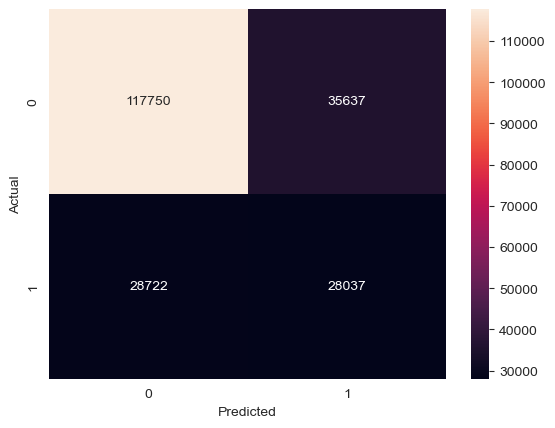

Training AUC: 0.7015


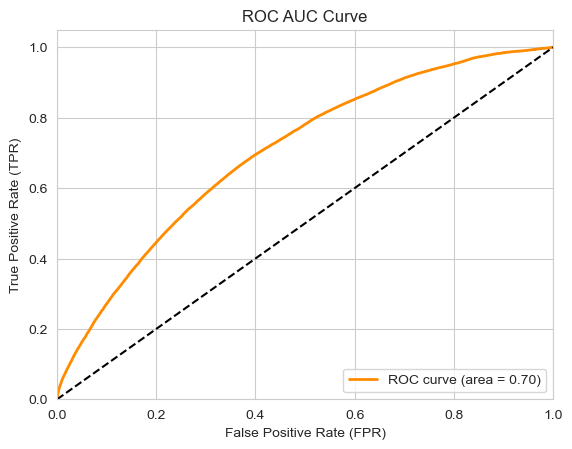

======== Test Set ==========
Confusion Matrix:
[[29366  8981]
 [ 7139  7051]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78     38347
           1       0.44      0.50      0.47     14190

    accuracy                           0.69     52537
   macro avg       0.62      0.63      0.63     52537
weighted avg       0.71      0.69      0.70     52537



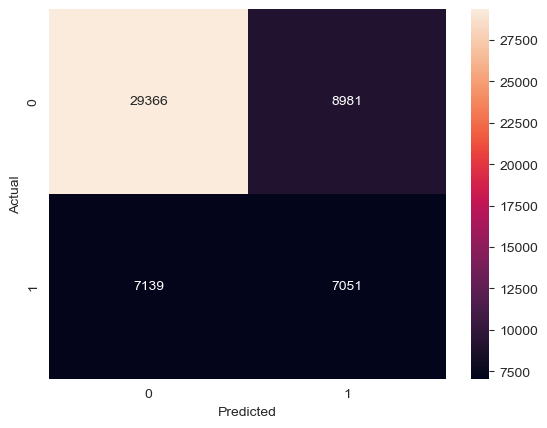

Testing AUC: 0.7003


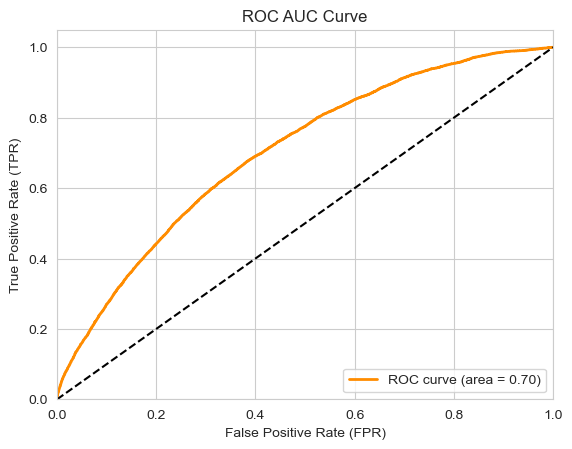

In [90]:
lr1 = LogisticRegression(class_weight = 'balanced', max_iter=1000)

lr1 = lr.fit(X_train1, y_train1)
lr_y_pred_train, lr_y_pred_test, lr_y_prob_train, lr_y_prob_test = evaluate_model(lr1, X_train1, y_train1, X_test1, y_test1)

# lr = lr.fit(X_train_resampled, y_train_resampled) # Makes the performance (accuracy) a lot worse/symptoms of overfitting?
# lr_y_pred_train, lr_y_pred_test, lr_y_prob_train, lr_y_prob_test = evaluate_model(lr, X_train_resampled, y_train_resampled, X_test.values, y_test.values)

Train accuracy score: 0.6955872278885675
Test accuracy score: 0.6933894047800274


======== Training Set ==========
Confusion Matrix:
[[119230  34211]
 [ 29779  26988]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79    153441
           1       0.44      0.48      0.46     56767

    accuracy                           0.70    210208
   macro avg       0.62      0.63      0.62    210208
weighted avg       0.70      0.70      0.70    210208



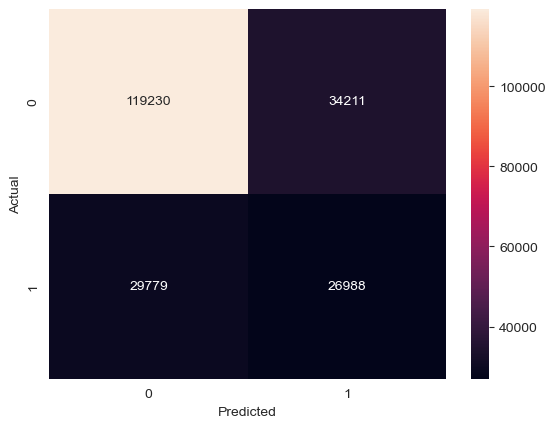

Training AUC: 0.7000


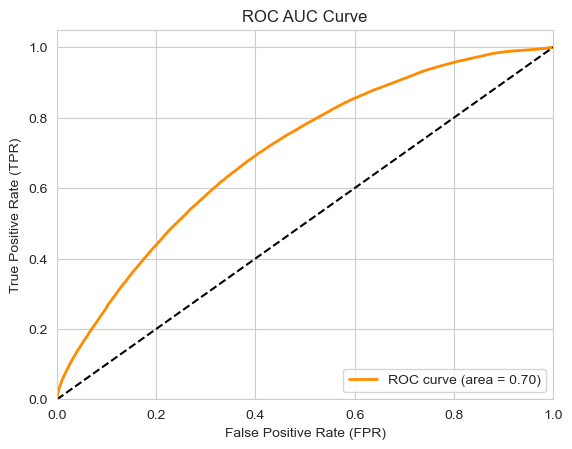

======== Test Set ==========
Confusion Matrix:
[[29676  8684]
 [ 7429  6763]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79     38360
           1       0.44      0.48      0.46     14192

    accuracy                           0.69     52552
   macro avg       0.62      0.63      0.62     52552
weighted avg       0.70      0.69      0.70     52552



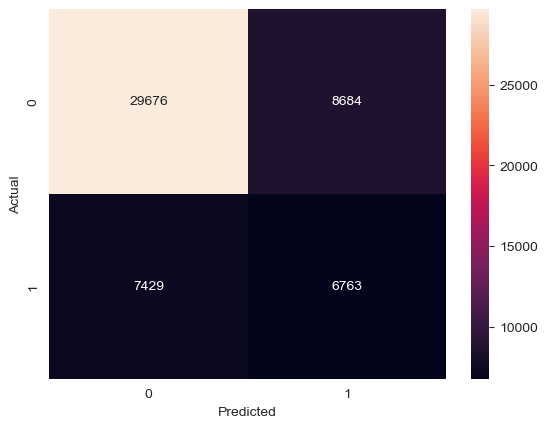

Testing AUC: 0.6992


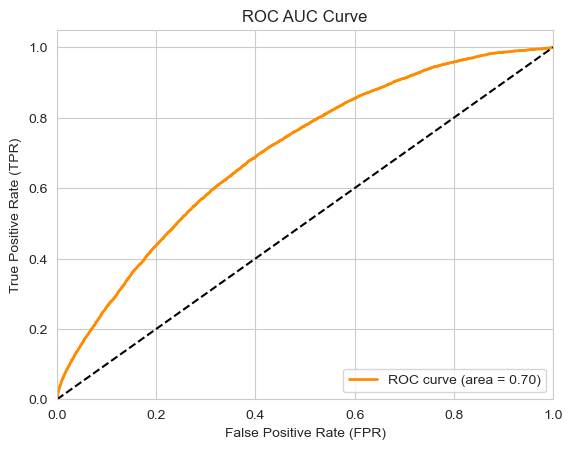

In [91]:
lr2 = LogisticRegression(class_weight = 'balanced', max_iter=1000)

lr2 = lr.fit(X_train2, y_train2)
lr_y_pred_train, lr_y_pred_test, lr_y_prob_train, lr_y_prob_test = evaluate_model(lr2, X_train2, y_train2, X_test2, y_test2)

# lr = lr.fit(X_train_resampled, y_train_resampled) # Makes the performance (accuracy) a lot worse/symptoms of overfitting?
# lr_y_pred_train, lr_y_pred_test, lr_y_prob_train, lr_y_prob_test = evaluate_model(lr, X_train_resampled, y_train_resampled, X_test.values, y_test.values)

Train accuracy score: 0.6933894047800274
Test accuracy score: 0.6923047648043842


======== Training Set ==========
Confusion Matrix:
[[118161  35280]
 [ 29172  27595]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79    153441
           1       0.44      0.49      0.46     56767

    accuracy                           0.69    210208
   macro avg       0.62      0.63      0.62    210208
weighted avg       0.70      0.69      0.70    210208



/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


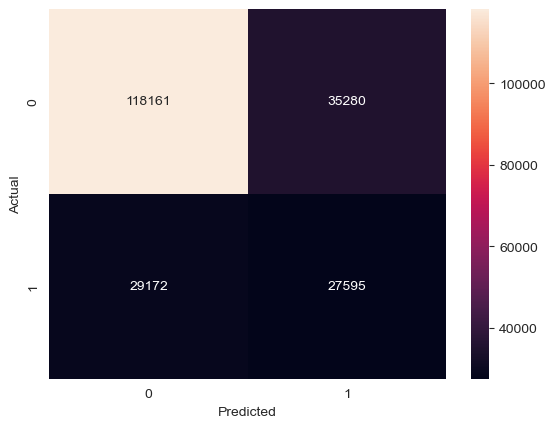

Training AUC: 0.6986


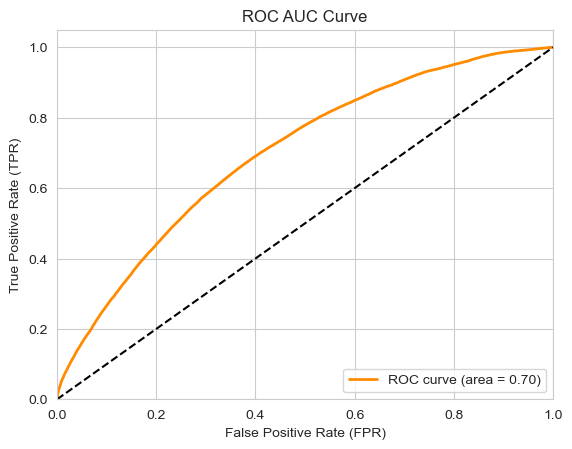

======== Test Set ==========
Confusion Matrix:
[[29481  8879]
 [ 7291  6901]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78     38360
           1       0.44      0.49      0.46     14192

    accuracy                           0.69     52552
   macro avg       0.62      0.63      0.62     52552
weighted avg       0.70      0.69      0.70     52552



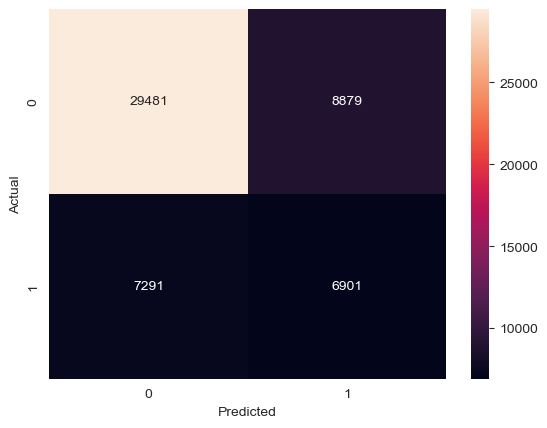

Testing AUC: 0.6981


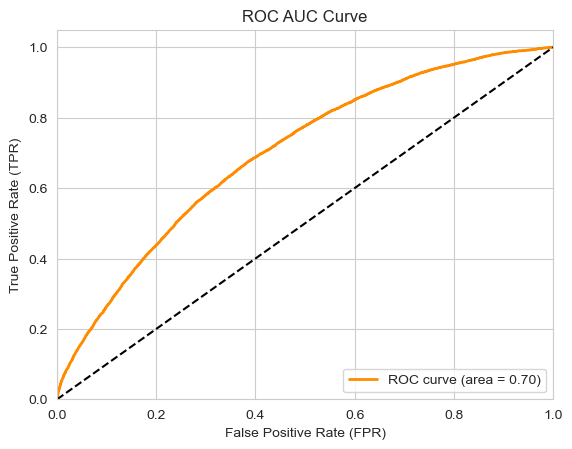

In [92]:
lr3 = LogisticRegression(class_weight = 'balanced', max_iter=1000)

lr3 = lr.fit(X_train3, y_train3)
lr_y_pred_train, lr_y_pred_test, lr_y_prob_train, lr_y_prob_test = evaluate_model(lr3, X_train3, y_train3, X_test3, y_test3)

# lr = lr.fit(X_train_resampled, y_train_resampled) # Makes the performance (accuracy) a lot worse/symptoms of overfitting?
# lr_y_pred_train, lr_y_pred_test, lr_y_prob_train, lr_y_prob_test = evaluate_model(lr, X_train_resampled, y_train_resampled, X_test.values, y_test.values)

In [118]:
param_dist = {
    'C': [0.01, 0.1, 1],
    'solver': ['lbfgs', 'newton-cholesky', 'liblinear']
}
search = RandomizedSearchCV(lr3, param_distributions=param_dist,
                            n_iter=6, scoring='roc_auc', cv=3, n_jobs=-1, random_state=42)
search.fit(X_train3, y_train3)

best_params = search.best_params_

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

In [122]:
final_params = {'class_weight':'balanced',
                'max_iter':1000,
                **best_params}

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy score: 0.6933894047800274
Test accuracy score: 0.6923047648043842


======== Training Set ==========
Confusion Matrix:
[[118161  35280]
 [ 29172  27595]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79    153441
           1       0.44      0.49      0.46     56767

    accuracy                           0.69    210208
   macro avg       0.62      0.63      0.62    210208
weighted avg       0.70      0.69      0.70    210208



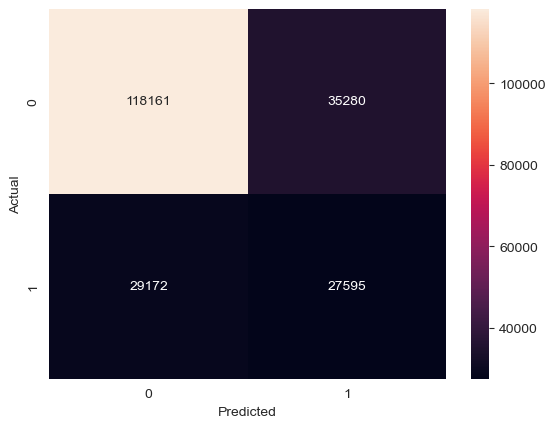

Training AUC: 0.6986


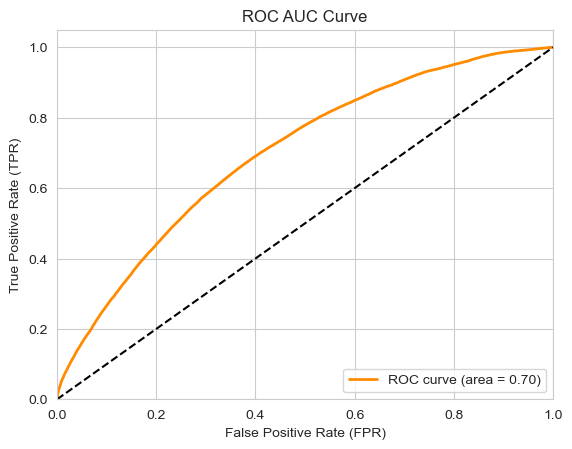

======== Test Set ==========
Confusion Matrix:
[[29481  8879]
 [ 7291  6901]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78     38360
           1       0.44      0.49      0.46     14192

    accuracy                           0.69     52552
   macro avg       0.62      0.63      0.62     52552
weighted avg       0.70      0.69      0.70     52552



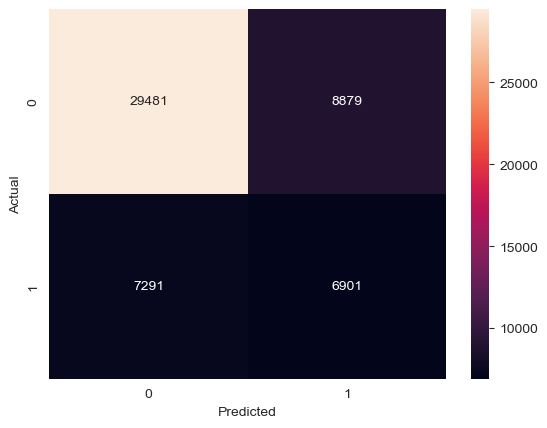

Testing AUC: 0.6981


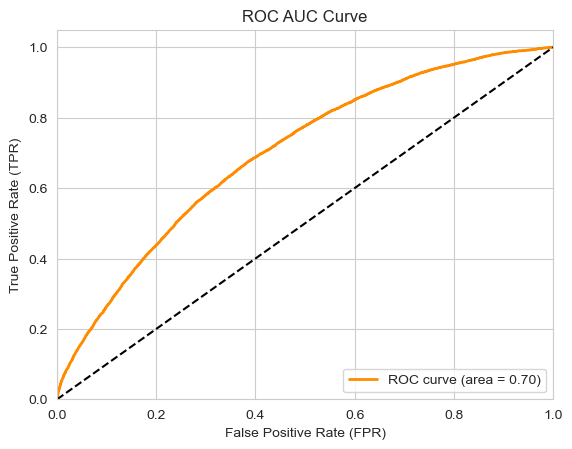

In [123]:
lr3 = LogisticRegression(final_params)

lr3 = lr.fit(X_train3, y_train3)
lr_y_pred_train, lr_y_pred_test, lr_y_prob_train, lr_y_prob_test = evaluate_model(lr3, X_train3, y_train3, X_test3, y_test3)

### XGBoost

Train accuracy score: 0.6563865122343514
Test accuracy score: 0.6561280621276434


======== Training Set ==========
Confusion Matrix:
[[95168 58219]
 [13990 42769]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.62      0.72    153387
           1       0.42      0.75      0.54     56759

    accuracy                           0.66    210146
   macro avg       0.65      0.69      0.63    210146
weighted avg       0.75      0.66      0.68    210146



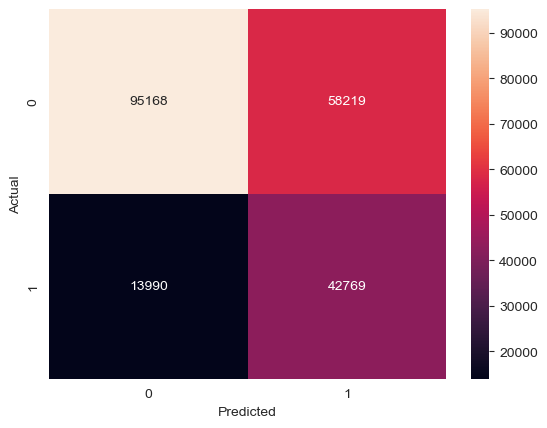

Training AUC: 0.7597


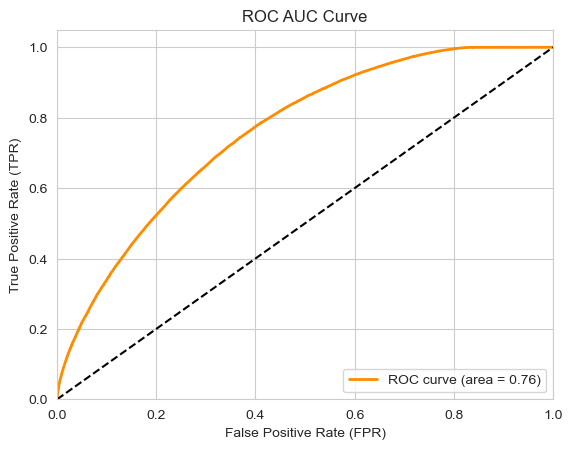

======== Test Set ==========
Confusion Matrix:
[[23835 14512]
 [ 3554 10636]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.62      0.73     38347
           1       0.42      0.75      0.54     14190

    accuracy                           0.66     52537
   macro avg       0.65      0.69      0.63     52537
weighted avg       0.75      0.66      0.68     52537



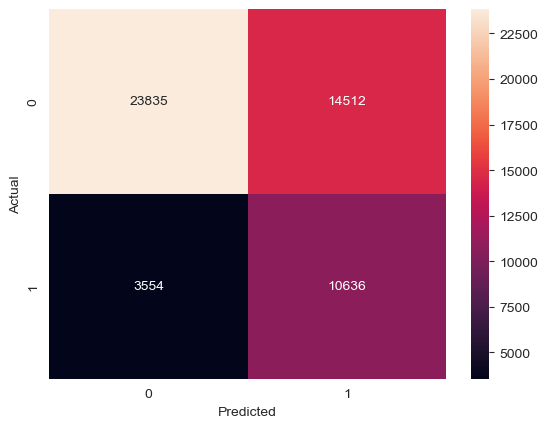

Testing AUC: 0.7584


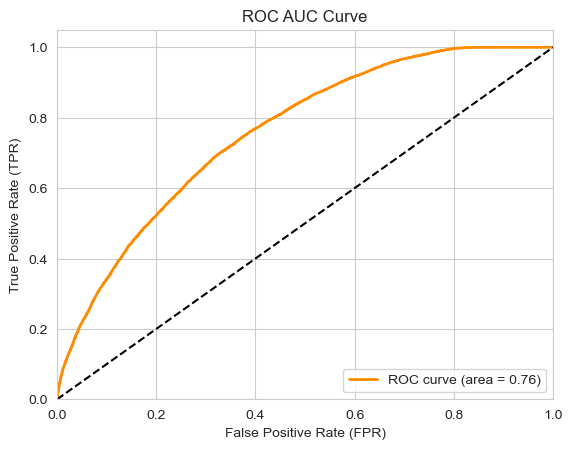

In [93]:
# Class imbalance handled via sample weighting during model fitting

xgb1 = GradientBoostingClassifier()

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train1)
xgb1 = xgb1.fit(X_train1, y_train1, sample_weight=sample_weights)
xgb_y_pred_train1, xgb_y_pred_test1, xgb_y_prob_train1, xgb_y_prob_test1 = evaluate_model(xgb1, X_train1, y_train1, X_test1, y_test1)

Train accuracy score: 0.6624248363525651
Test accuracy score: 0.6586999543309484


======== Training Set ==========
Confusion Matrix:
[[96612 56829]
 [14132 42635]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.63      0.73    153441
           1       0.43      0.75      0.55     56767

    accuracy                           0.66    210208
   macro avg       0.65      0.69      0.64    210208
weighted avg       0.75      0.66      0.68    210208



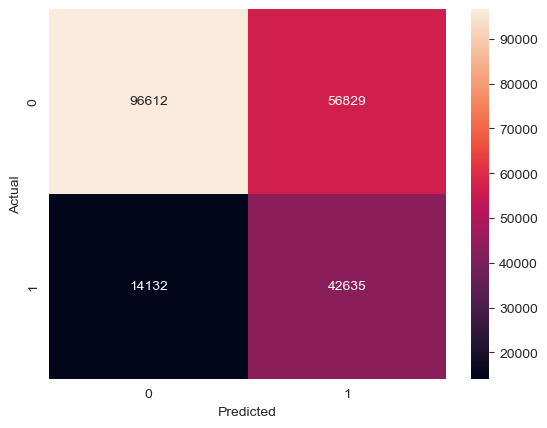

Training AUC: 0.7623


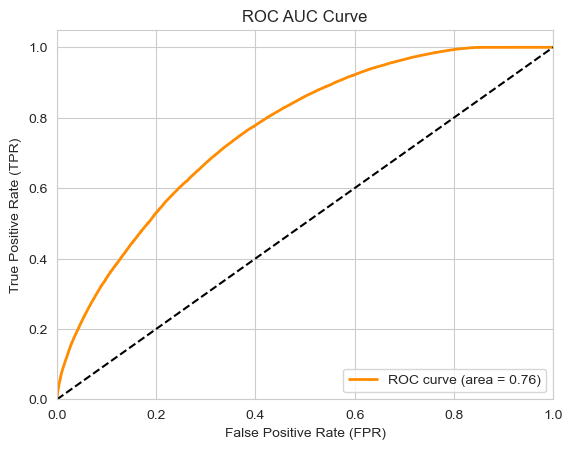

======== Test Set ==========
Confusion Matrix:
[[24003 14357]
 [ 3579 10613]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.63      0.73     38360
           1       0.43      0.75      0.54     14192

    accuracy                           0.66     52552
   macro avg       0.65      0.69      0.64     52552
weighted avg       0.75      0.66      0.68     52552



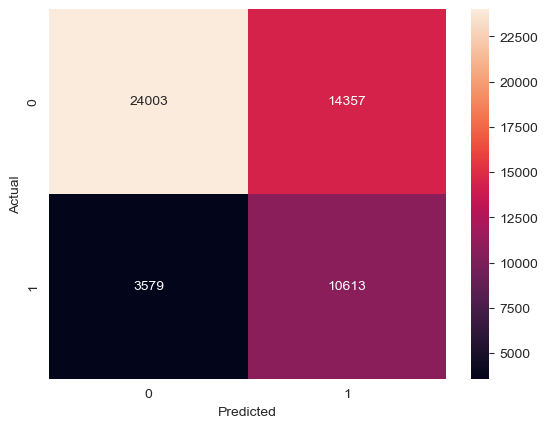

Testing AUC: 0.7587


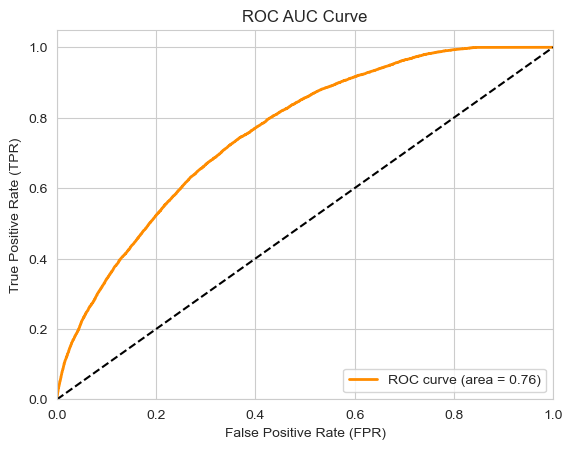

In [94]:
# Class imbalance handled via sample weighting during model fitting

xgb2 = GradientBoostingClassifier()

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train2)
xgb2 = xgb2.fit(X_train2, y_train2, sample_weight=sample_weights)
xgb_y_pred_train2, xgb_y_pred_test2, xgb_y_prob_train2, xgb_y_prob_test2 = evaluate_model(xgb2, X_train2, y_train2, X_test2, y_test2)

Train accuracy score: 0.6601080834221342
Test accuracy score: 0.6577104582128178


======== Training Set ==========
Confusion Matrix:
[[95998 57443]
 [14005 42762]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.63      0.73    153441
           1       0.43      0.75      0.54     56767

    accuracy                           0.66    210208
   macro avg       0.65      0.69      0.64    210208
weighted avg       0.75      0.66      0.68    210208



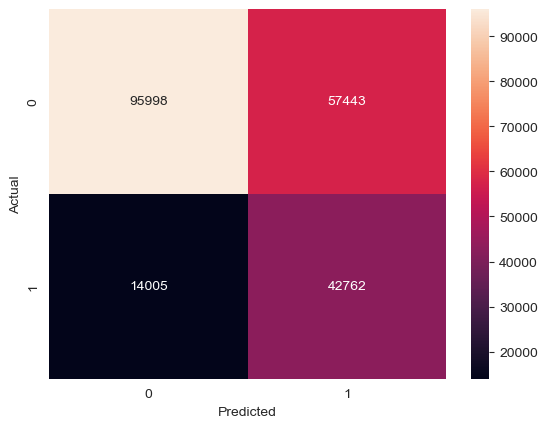

Training AUC: 0.7630


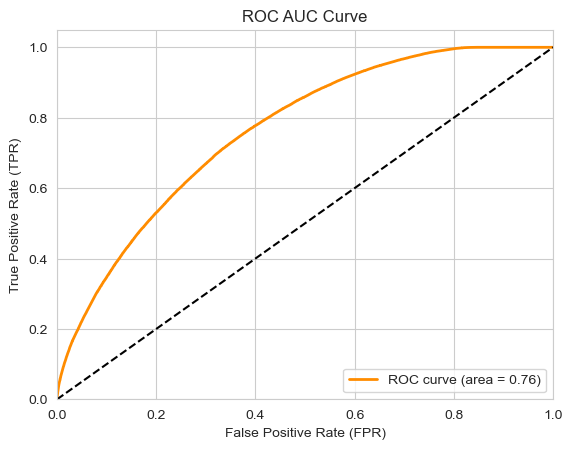

======== Test Set ==========
Confusion Matrix:
[[23928 14432]
 [ 3556 10636]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.62      0.73     38360
           1       0.42      0.75      0.54     14192

    accuracy                           0.66     52552
   macro avg       0.65      0.69      0.63     52552
weighted avg       0.75      0.66      0.68     52552



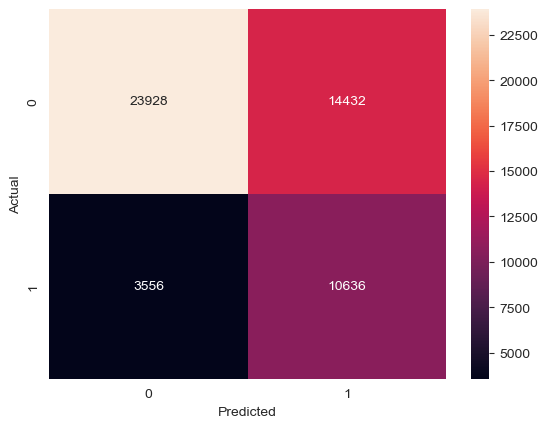

Testing AUC: 0.7597


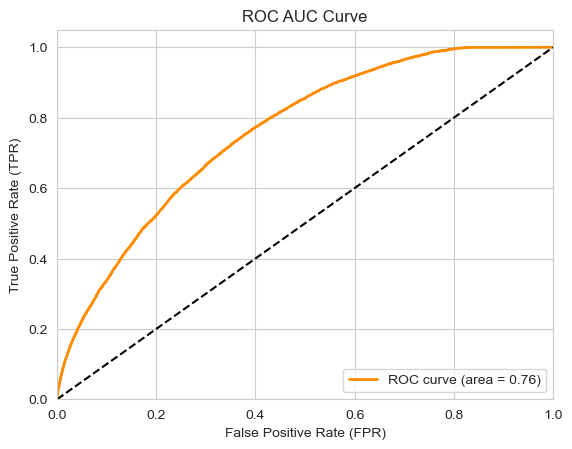

In [95]:
# Class imbalance handled via sample weighting during model fitting

xgb3 = GradientBoostingClassifier()

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train3)
xgb3 = xgb3.fit(X_train3, y_train3, sample_weight=sample_weights)
xgb_y_pred_train3, xgb_y_pred_test3, xgb_y_prob_train3, xgb_y_prob_test3 = evaluate_model(xgb3, X_train3, y_train3, X_test3, y_test3)

In [125]:
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1]
}
search = RandomizedSearchCV(xgb3, param_distributions=param_distributions,
                            n_iter=6, scoring='roc_auc', cv=3, n_jobs=-1, random_state=42)
search.fit(X_train3, y_train3)

best_params = search.best_params_

In [127]:
best_params

{'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1}

Train accuracy score: 0.7064764423808799
Test accuracy score: 0.679840919470239


======== Training Set ==========
Confusion Matrix:
[[104138  49303]
 [ 12398  44369]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.68      0.77    153441
           1       0.47      0.78      0.59     56767

    accuracy                           0.71    210208
   macro avg       0.68      0.73      0.68    210208
weighted avg       0.78      0.71      0.72    210208



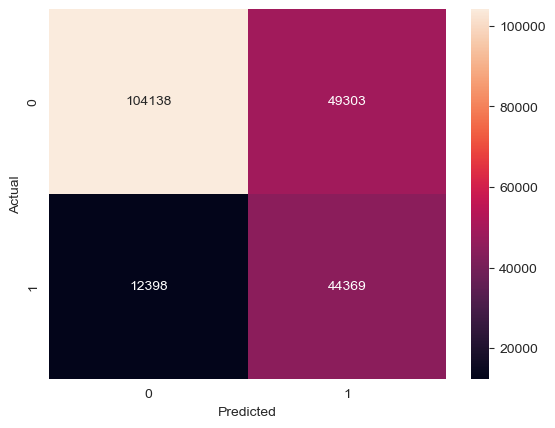

Training AUC: 0.8140


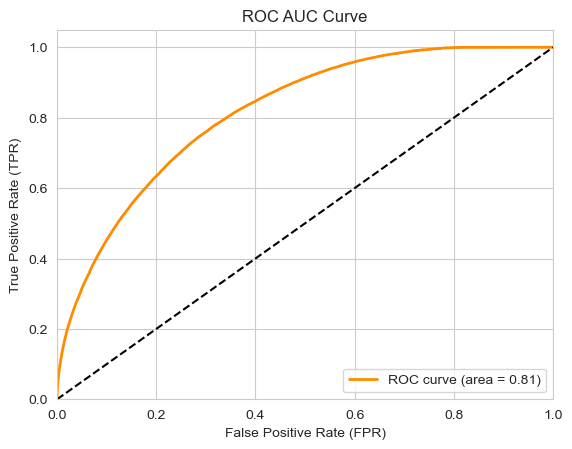

======== Test Set ==========
Confusion Matrix:
[[25218 13142]
 [ 3683 10509]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.66      0.75     38360
           1       0.44      0.74      0.56     14192

    accuracy                           0.68     52552
   macro avg       0.66      0.70      0.65     52552
weighted avg       0.76      0.68      0.70     52552



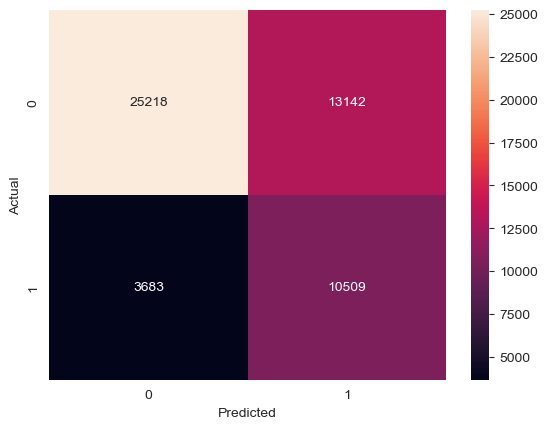

Testing AUC: 0.7764


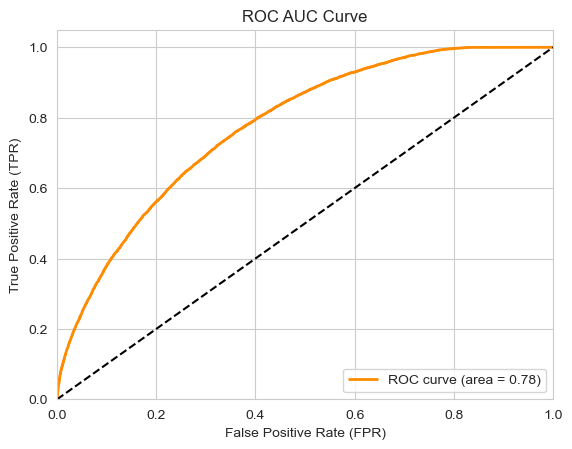

In [128]:
xgb3 = GradientBoostingClassifier(n_estimators = 300, max_depth = 6, learning_rate = 0.1)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train3)
xgb3 = xgb3.fit(X_train3, y_train3, sample_weight=sample_weights)
xgb_y_pred_train3, xgb_y_pred_test3, xgb_y_prob_train3, xgb_y_prob_test3 = evaluate_model(xgb3, X_train3, y_train3, X_test3, y_test3)

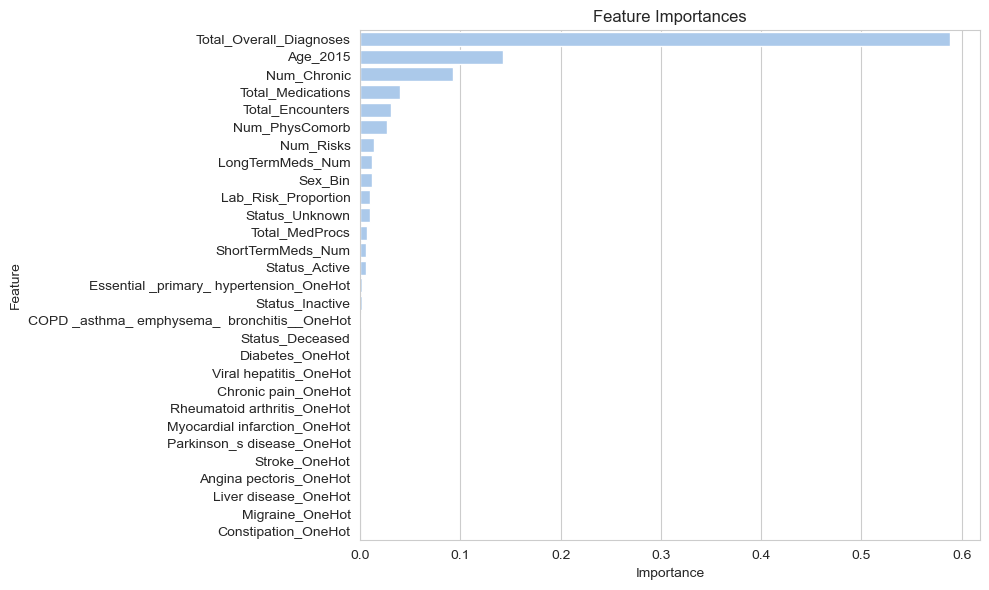

In [96]:
plot_model_importances(xgb3, X_train3) # has higher recall

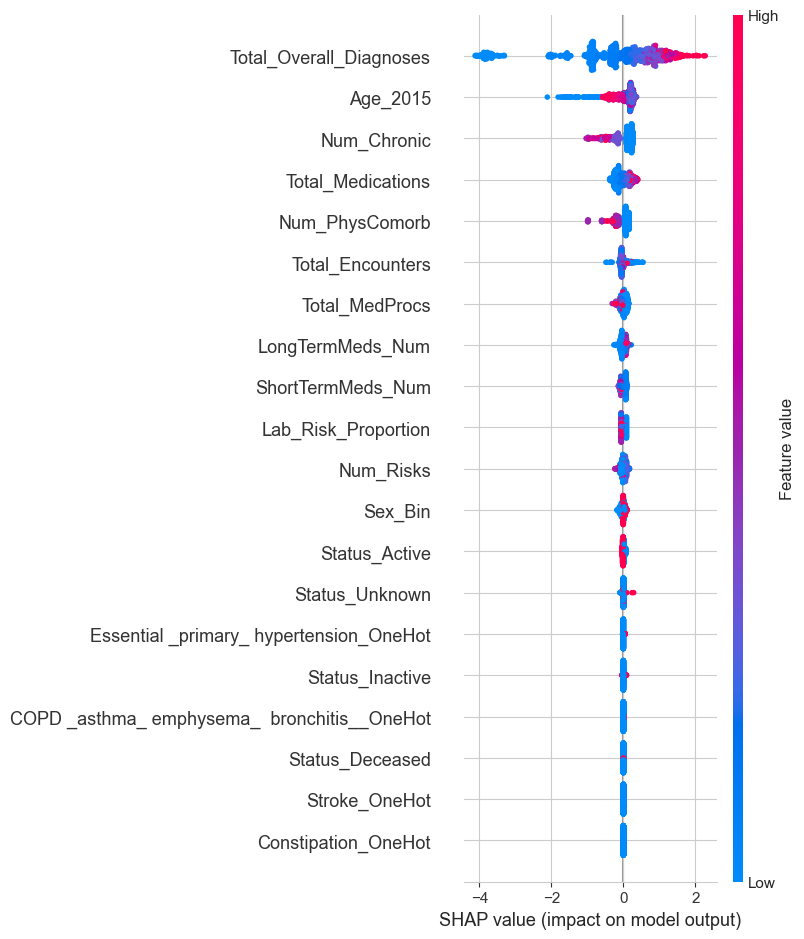

In [99]:
import shap

explainer = shap.TreeExplainer(xgb3)
X_sample = X_test3.sample(n=1000, random_state=42)
shap_values = explainer.shap_values(X_sample)
shap.summary_plot(shap_values, X_sample)

### AdaBoost

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.6640097836742075
Test accuracy score: 0.6651502750442545


======== Training Set ==========
Confusion Matrix:
[[97971 55416]
 [15191 41568]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.64      0.74    153387
           1       0.43      0.73      0.54     56759

    accuracy                           0.66    210146
   macro avg       0.65      0.69      0.64    210146
weighted avg       0.75      0.66      0.68    210146



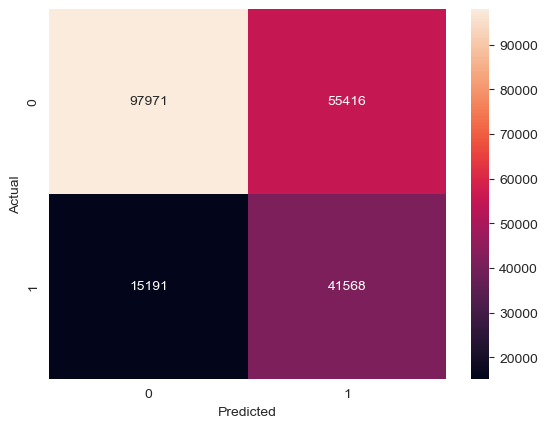

Training AUC: 0.7569


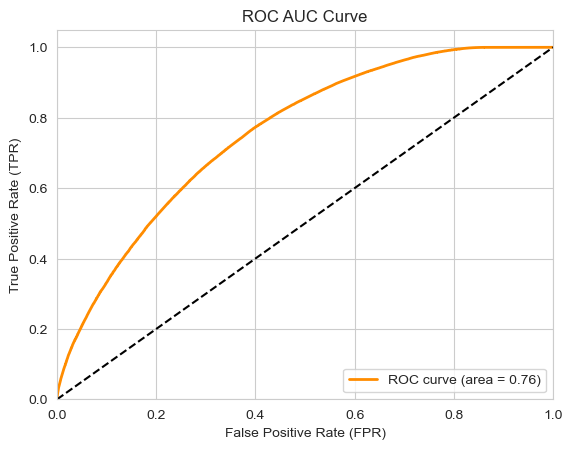

======== Test Set ==========
Confusion Matrix:
[[24569 13778]
 [ 3814 10376]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.64      0.74     38347
           1       0.43      0.73      0.54     14190

    accuracy                           0.67     52537
   macro avg       0.65      0.69      0.64     52537
weighted avg       0.75      0.67      0.68     52537



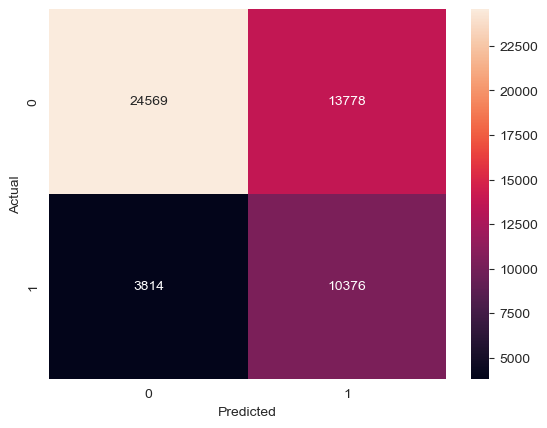

Testing AUC: 0.7569


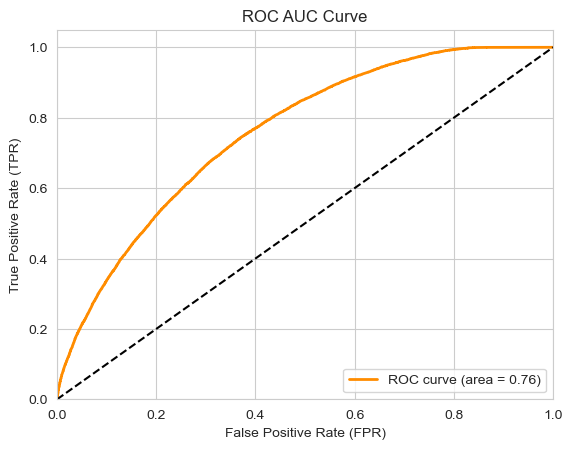

In [103]:
adc1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=200)

sample_weights1 = compute_sample_weight(class_weight='balanced', y=y_train1)
adc1 = adc1.fit(X_train1, y_train1, sample_weight=sample_weights1)
adc_y_pred_train1, adc_y_pred_test1, adc_y_prob_train1, adc_y_prob_test1 = evaluate_model(adc1, X_train1, y_train1, X_test1.values, y_test1.values)

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.663780636322119
Test accuracy score: 0.6611927233977775


======== Training Set ==========
Confusion Matrix:
[[98268 55173]
 [15503 41264]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.64      0.74    153441
           1       0.43      0.73      0.54     56767

    accuracy                           0.66    210208
   macro avg       0.65      0.68      0.64    210208
weighted avg       0.75      0.66      0.68    210208



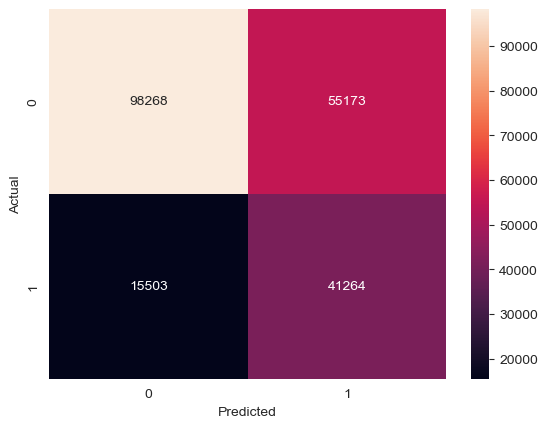

Training AUC: 0.7542


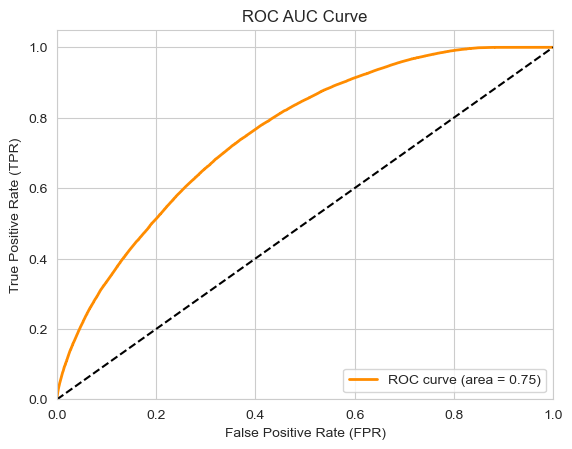

======== Test Set ==========
Confusion Matrix:
[[24459 13901]
 [ 3904 10288]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.64      0.73     38360
           1       0.43      0.72      0.54     14192

    accuracy                           0.66     52552
   macro avg       0.64      0.68      0.63     52552
weighted avg       0.74      0.66      0.68     52552



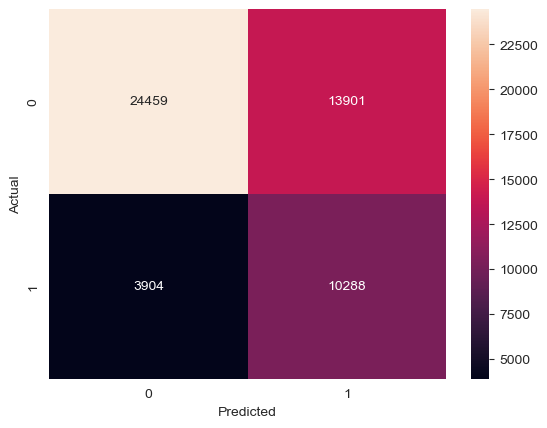

Testing AUC: 0.7516


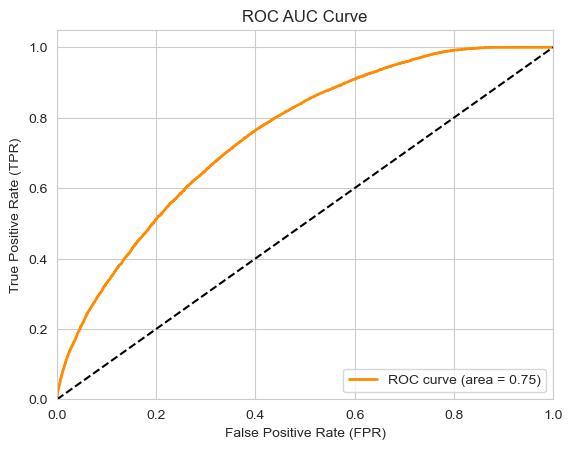

In [104]:
adc2 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=200)

sample_weights2 = compute_sample_weight(class_weight='balanced', y=y_train2)
adc2 = adc2.fit(X_train2, y_train2, sample_weight=sample_weights2)
adc_y_pred_train2, adc_y_pred_test2, adc_y_prob_train2, adc_y_prob_test2 = evaluate_model(adc2, X_train2, y_train2, X_test2.values, y_test2.values)

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.6686615162125134
Test accuracy score: 0.6670726137920536


======== Training Set ==========
Confusion Matrix:
[[98805 54636]
 [15014 41753]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.64      0.74    153441
           1       0.43      0.74      0.55     56767

    accuracy                           0.67    210208
   macro avg       0.65      0.69      0.64    210208
weighted avg       0.75      0.67      0.69    210208



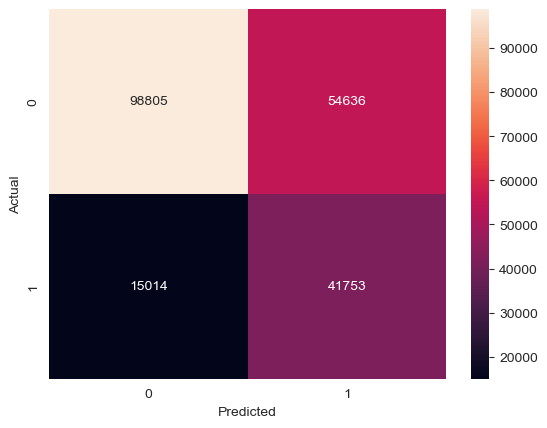

Training AUC: 0.7642


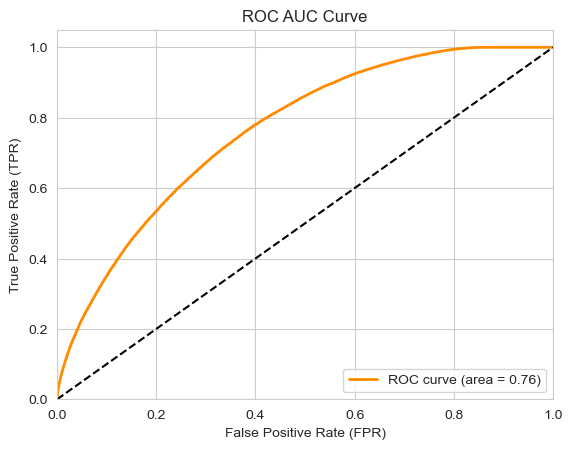

======== Test Set ==========
Confusion Matrix:
[[24696 13664]
 [ 3832 10360]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.64      0.74     38360
           1       0.43      0.73      0.54     14192

    accuracy                           0.67     52552
   macro avg       0.65      0.69      0.64     52552
weighted avg       0.75      0.67      0.69     52552



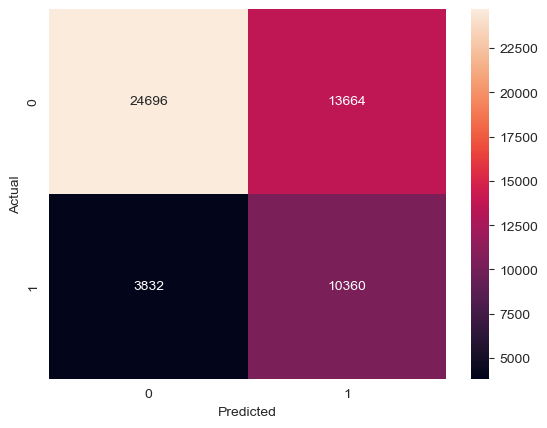

Testing AUC: 0.7624


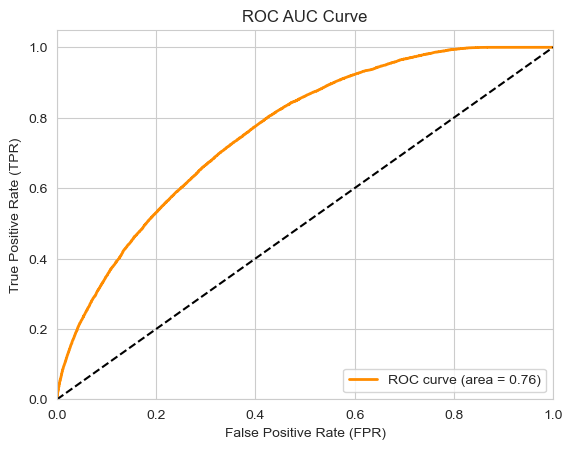

In [105]:
adc3 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=200)

sample_weights3 = compute_sample_weight(class_weight='balanced', y=y_train3)
adc3 = adc3.fit(X_train3, y_train3, sample_weight=sample_weights3)
adc_y_pred_train3, adc_y_pred_test3, adc_y_prob_train3, adc_y_prob_test3 = evaluate_model(adc3, X_train3, y_train3, X_test3.values, y_test3.values)

In [129]:
param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'estimator': [
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2),
        DecisionTreeClassifier(max_depth=3)
    ],
    'algorithm': ['SAMME', 'SAMME.R']
}

In [130]:
search = RandomizedSearchCV(adc3, param_distributions=param_distributions,
                            n_iter=6, scoring='roc_auc', cv=3, n_jobs=-1, random_state=42)
search.fit(X_train3, y_train3)

best_params = search.best_params_

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/daisyliu/anaconda3/en

In [131]:
best_params

{'n_estimators': 100,
 'learning_rate': 0.05,
 'estimator': DecisionTreeClassifier(max_depth=3),
 'algorithm': 'SAMME'}

In [ ]:
adc3 = AdaBoostClassifier(best_params)

sample_weights3 = compute_sample_weight(class_weight='balanced', y=y_train3)
adc3 = adc3.fit(X_train3, y_train3, sample_weight=sample_weights3)
adc_y_pred_train3, adc_y_pred_test3, adc_y_prob_train3, adc_y_prob_test3 = evaluate_model(adc3, X_train3, y_train3, X_test3.values, y_test3.values)

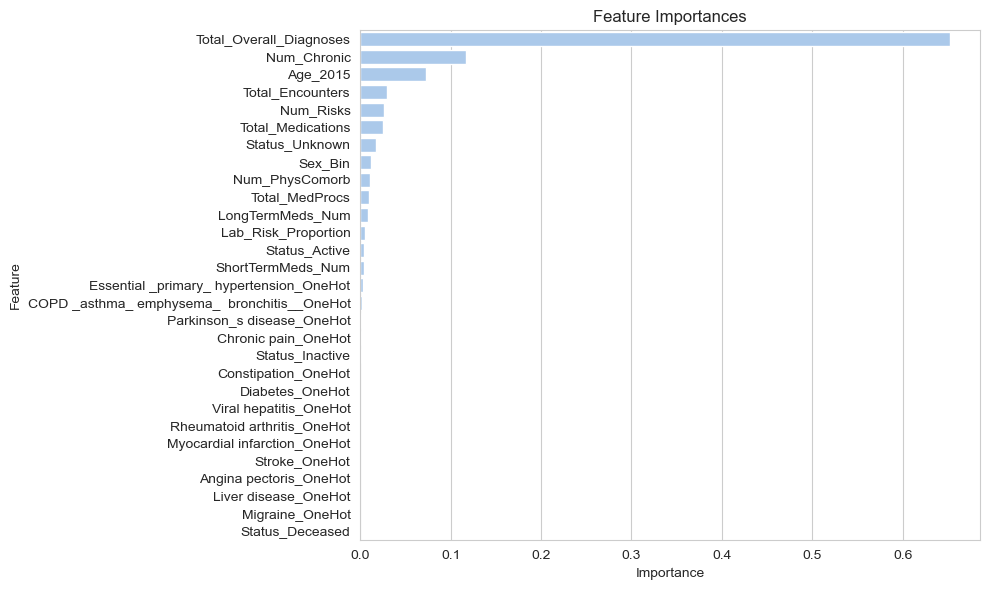

In [106]:
plot_model_importances(adc3, X_train3)

### RandomForestClassifier

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.9974779439056656
Test accuracy score: 0.7463692254982203


======== Training Set ==========
Confusion Matrix:
[[153245    142]
 [   388  56371]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153387
           1       1.00      0.99      1.00     56759

    accuracy                           1.00    210146
   macro avg       1.00      1.00      1.00    210146
weighted avg       1.00      1.00      1.00    210146



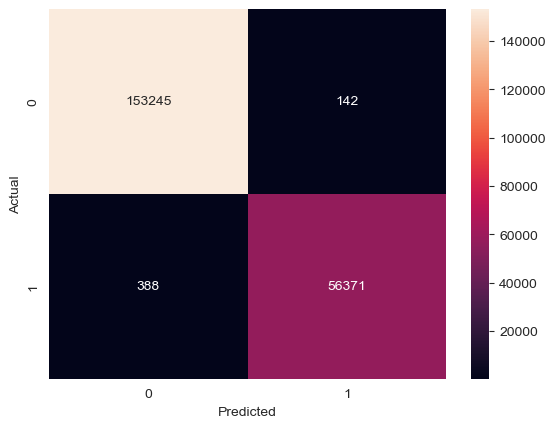

Training AUC: 0.9999


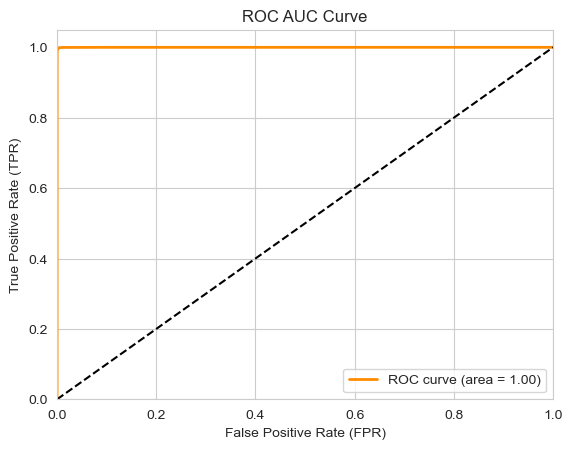

======== Test Set ==========
Confusion Matrix:
[[35151  3196]
 [10129  4061]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.92      0.84     38347
           1       0.56      0.29      0.38     14190

    accuracy                           0.75     52537
   macro avg       0.67      0.60      0.61     52537
weighted avg       0.72      0.75      0.72     52537



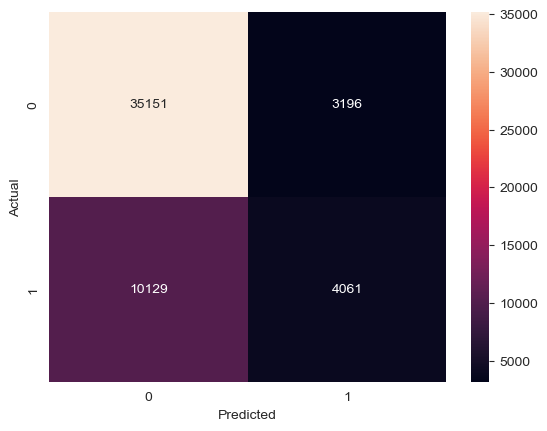

Testing AUC: 0.7474


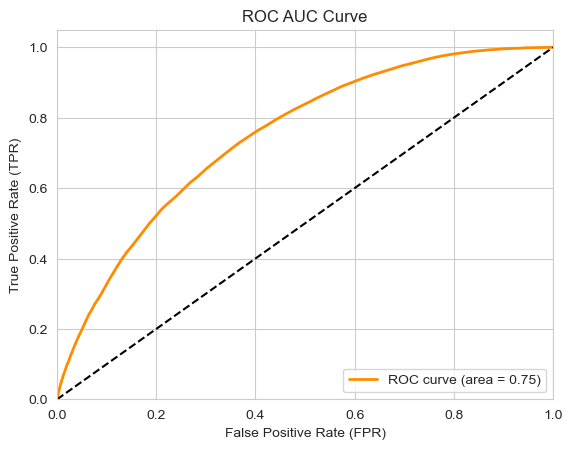

In [107]:
rfc1 = RandomForestClassifier()

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train1)
rfc1 = rfc1.fit(X_train1, y_train1)
rfc_y_pred_train1, rfc_y_pred_test1, rfc_y_prob_train1, rfc_y_prob_test1 = evaluate_model(rfc1, X_train1, y_train1, X_test1.values, y_test1.values)

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.9980067361851119
Test accuracy score: 0.7482683817932714


======== Training Set ==========
Confusion Matrix:
[[153338    103]
 [   316  56451]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153441
           1       1.00      0.99      1.00     56767

    accuracy                           1.00    210208
   macro avg       1.00      1.00      1.00    210208
weighted avg       1.00      1.00      1.00    210208



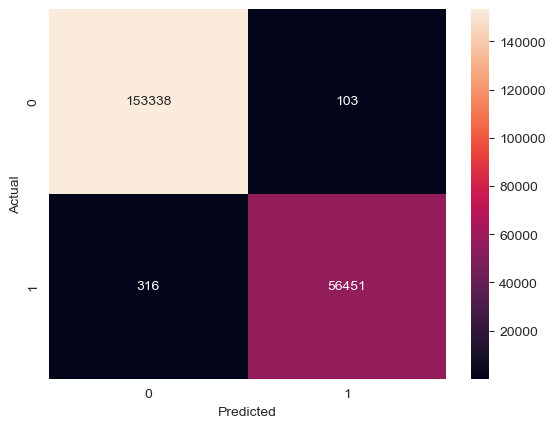

Training AUC: 1.0000


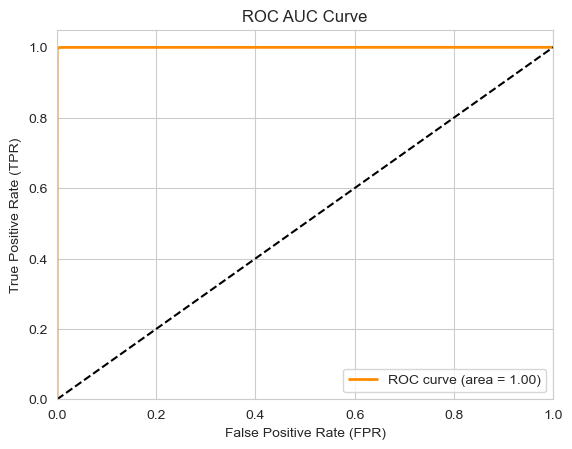

======== Test Set ==========
Confusion Matrix:
[[35126  3234]
 [ 9995  4197]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.92      0.84     38360
           1       0.56      0.30      0.39     14192

    accuracy                           0.75     52552
   macro avg       0.67      0.61      0.61     52552
weighted avg       0.72      0.75      0.72     52552



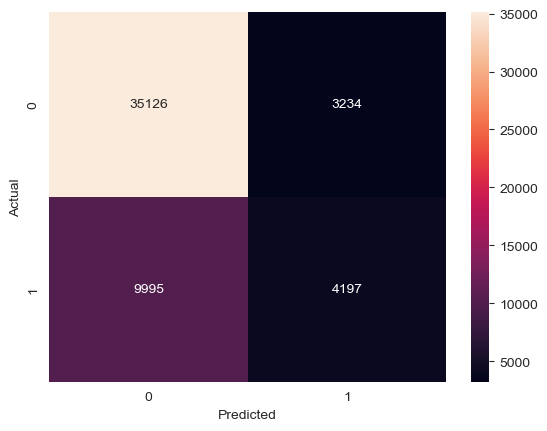

Testing AUC: 0.7466


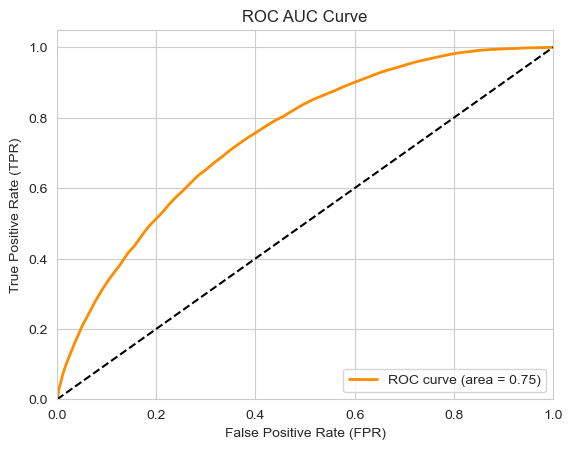

In [108]:
rfc2 = RandomForestClassifier()

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train2)
rfc2 = rfc2.fit(X_train2, y_train2)
rfc_y_pred_train2, rfc_y_pred_test2, rfc_y_prob_train2, rfc_y_prob_test2 = evaluate_model(rfc2, X_train2, y_train2, X_test2.values, y_test2.values)

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.9984729410869234
Test accuracy score: 0.7519409346932562


======== Training Set ==========
Confusion Matrix:
[[153355     86]
 [   235  56532]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153441
           1       1.00      1.00      1.00     56767

    accuracy                           1.00    210208
   macro avg       1.00      1.00      1.00    210208
weighted avg       1.00      1.00      1.00    210208



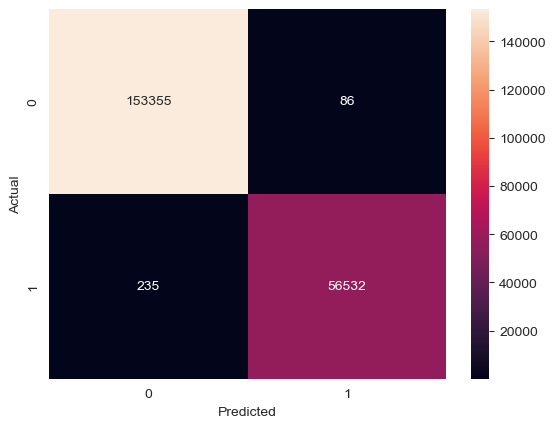

Training AUC: 1.0000


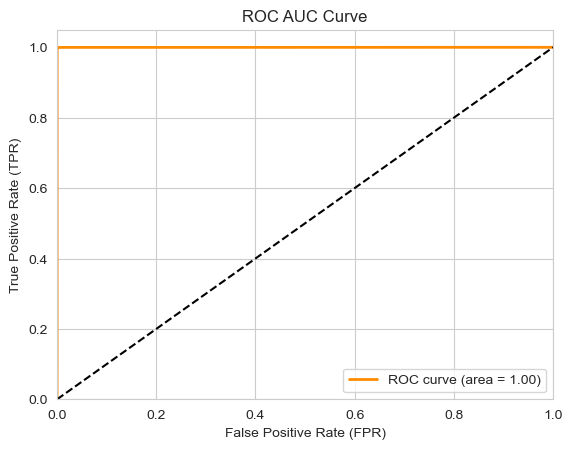

======== Test Set ==========
Confusion Matrix:
[[35414  2946]
 [10090  4102]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.92      0.84     38360
           1       0.58      0.29      0.39     14192

    accuracy                           0.75     52552
   macro avg       0.68      0.61      0.62     52552
weighted avg       0.73      0.75      0.72     52552



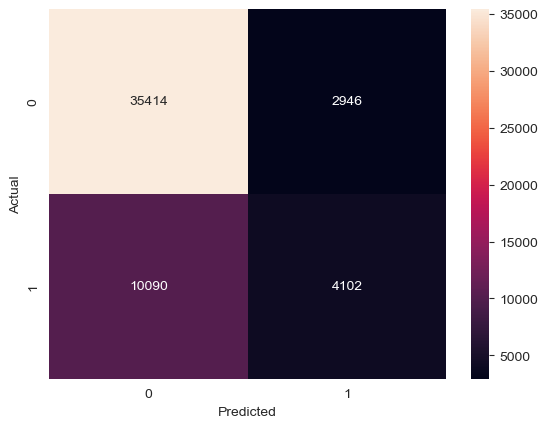

Testing AUC: 0.7550


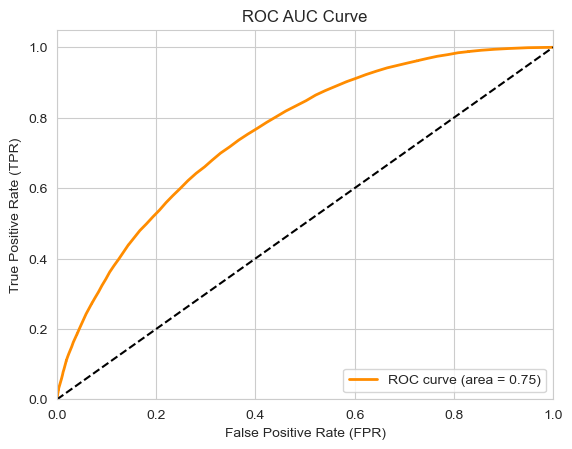

In [109]:
rfc3 = RandomForestClassifier()

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train3)
rfc3 = rfc3.fit(X_train3, y_train3)
rfc_y_pred_train3, rfc_y_pred_test3, rfc_y_prob_train3, rfc_y_prob_test3 = evaluate_model(rfc3, X_train3, y_train3, X_test3.values, y_test3.values)

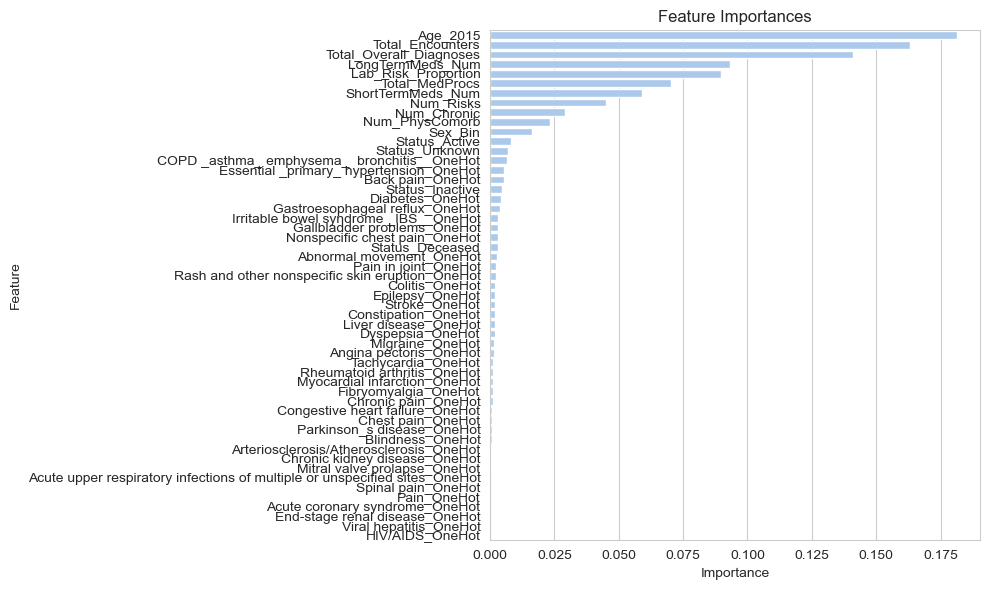

In [110]:
plot_model_importances(rfc1, X_train)

### Light Gradient-Boosting Machine

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 56759, number of negative: 153387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1438
[LightGBM] [Info] Number of data points in the train set: 210146, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.270093 -> initscore=-0.994150
[LightGBM] [Info] Start training from score -0.994150


/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.6772339230820478
Test accuracy score: 0.6727639568304242


======== Training Set ==========
Confusion Matrix:
[[99014 54373]
 [13455 43304]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.65      0.74    153387
           1       0.44      0.76      0.56     56759

    accuracy                           0.68    210146
   macro avg       0.66      0.70      0.65    210146
weighted avg       0.76      0.68      0.70    210146



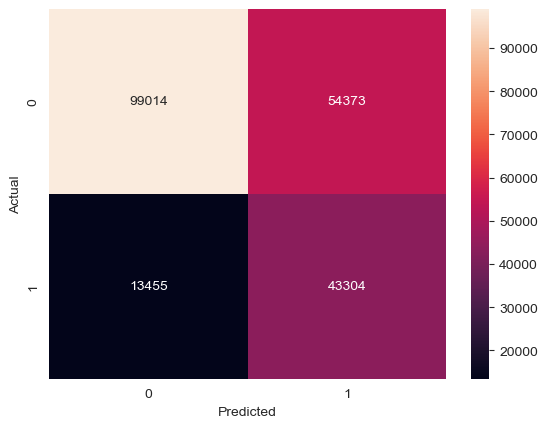

Training AUC: 0.7827


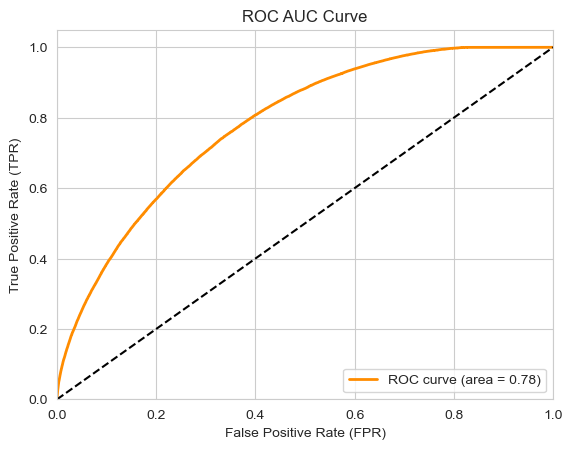

======== Test Set ==========
Confusion Matrix:
[[24670 13677]
 [ 3515 10675]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74     38347
           1       0.44      0.75      0.55     14190

    accuracy                           0.67     52537
   macro avg       0.66      0.70      0.65     52537
weighted avg       0.76      0.67      0.69     52537



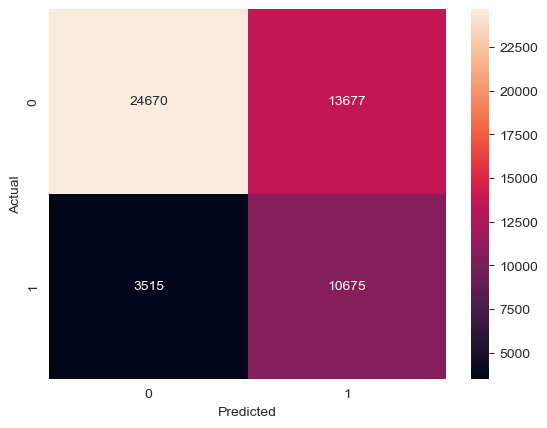

Testing AUC: 0.7733


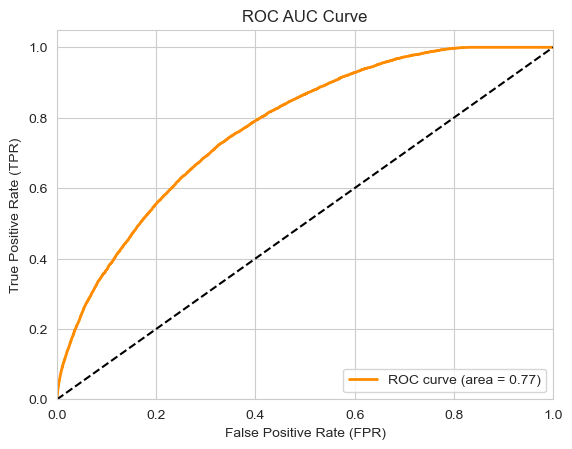

In [111]:
counter1 = Counter(y_train1)
scale_pos_weight1 = counter1[0] / counter1[1]

lgc1 = LGBMClassifier(scale_pos_weight=scale_pos_weight1)

lgc1 = lgc1.fit(X_train1, y_train1)
lgc_y_pred_train1, lgc_y_pred_test1, lgc_y_prob_train1, lgc_y_prob_test1 = evaluate_model(lgc1, X_train1, y_train1, X_test1.values, y_test1.values)

[LightGBM] [Info] Number of positive: 56767, number of negative: 153441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1507
[LightGBM] [Info] Number of data points in the train set: 210208, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.270052 -> initscore=-0.994361
[LightGBM] [Info] Start training from score -0.994361


/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.6766202998934389
Test accuracy score: 0.6690516060283148


======== Training Set ==========
Confusion Matrix:
[[98941 54500]
 [13477 43290]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74    153441
           1       0.44      0.76      0.56     56767

    accuracy                           0.68    210208
   macro avg       0.66      0.70      0.65    210208
weighted avg       0.76      0.68      0.69    210208



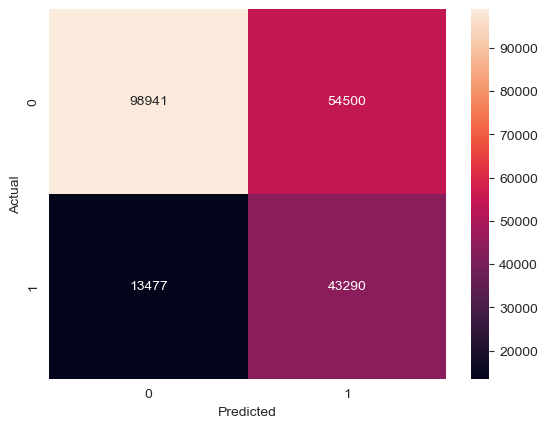

Training AUC: 0.7809


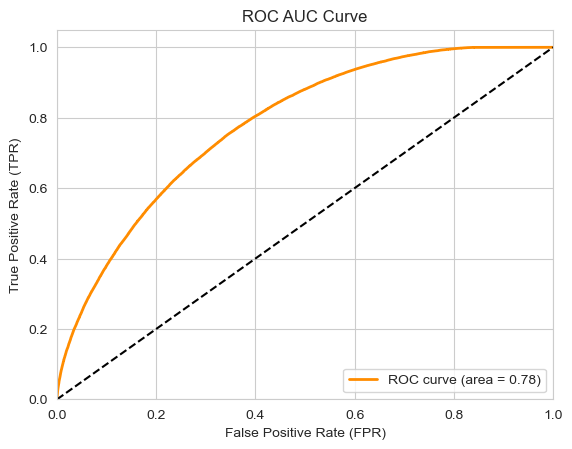

======== Test Set ==========
Confusion Matrix:
[[24490 13870]
 [ 3522 10670]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.64      0.74     38360
           1       0.43      0.75      0.55     14192

    accuracy                           0.67     52552
   macro avg       0.65      0.70      0.64     52552
weighted avg       0.76      0.67      0.69     52552



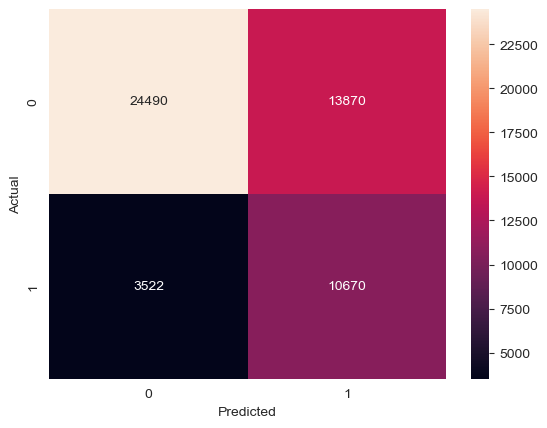

Testing AUC: 0.7697


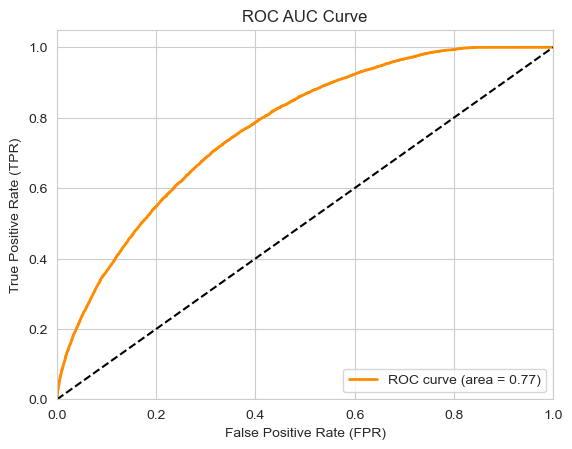

In [112]:
counter2 = Counter(y_train2)
scale_pos_weight2 = counter2[0] / counter1[1]

lgc2 = LGBMClassifier(scale_pos_weight=scale_pos_weight2)

lgc2 = lgc2.fit(X_train2, y_train2)
lgc_y_pred_train2, lgc_y_pred_test2, lgc_y_prob_train2, lgc_y_prob_test2 = evaluate_model(lgc2, X_train2, y_train2, X_test2.values, y_test2.values)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 56767, number of negative: 153441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1656
[LightGBM] [Info] Number of data points in the train set: 210208, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.270052 -> initscore=-0.994361
[LightGBM] [Info] Start training from score -0.994361


/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.6797077180697214
Test accuracy score: 0.6723816410412544


======== Training Set ==========
Confusion Matrix:
[[99417 54024]
 [13304 43463]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.65      0.75    153441
           1       0.45      0.77      0.56     56767

    accuracy                           0.68    210208
   macro avg       0.66      0.71      0.66    210208
weighted avg       0.76      0.68      0.70    210208



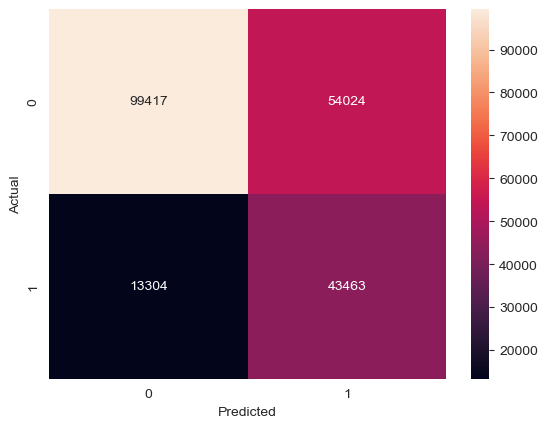

Training AUC: 0.7862


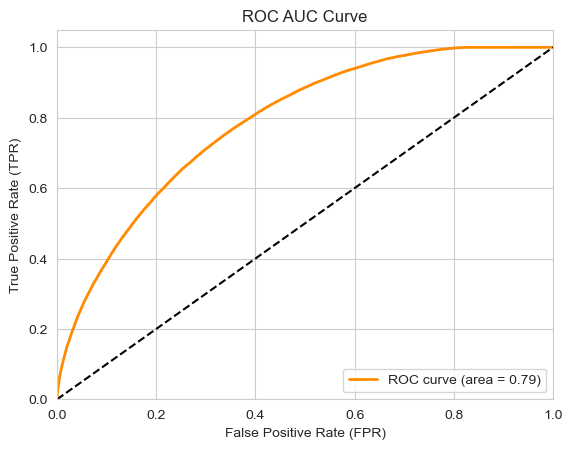

======== Test Set ==========
Confusion Matrix:
[[24641 13719]
 [ 3498 10694]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74     38360
           1       0.44      0.75      0.55     14192

    accuracy                           0.67     52552
   macro avg       0.66      0.70      0.65     52552
weighted avg       0.76      0.67      0.69     52552



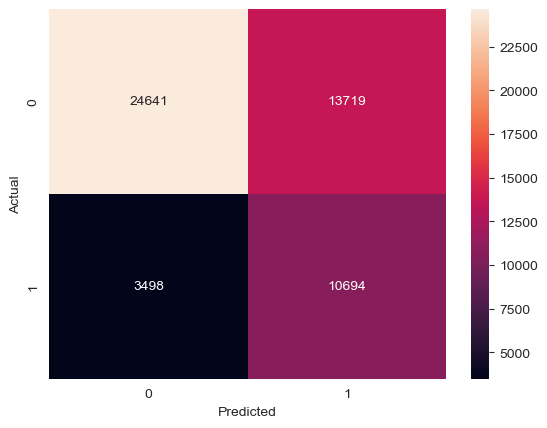

Testing AUC: 0.7760


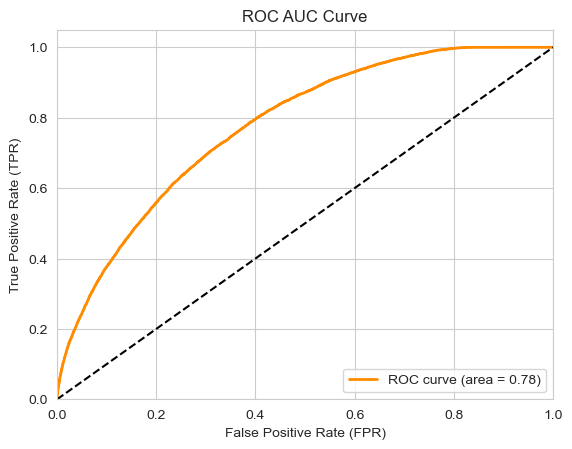

In [113]:
counter3 = Counter(y_train3)
scale_pos_weight3 = counter3[0] / counter3[1]

lgc3 = LGBMClassifier(scale_pos_weight=scale_pos_weight3)

lgc3 = lgc3.fit(X_train3, y_train3)
lgc_y_pred_train3, lgc_y_pred_test3, lgc_y_prob_train3, lgc_y_prob_test3 = evaluate_model(lgc3, X_train3, y_train3, X_test3.values, y_test3.values)

In [132]:
param_distributions = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20, 40],
    'reg_lambda': [0, 1, 5],
}

search = RandomizedSearchCV(lgc3, param_distributions=param_distributions,
                            n_iter=6, scoring='roc_auc', cv=3, n_jobs=-1, random_state=42)
search.fit(X_train3, y_train3)

best_params = search.best_params_

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 37845, number of negative: 102294
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1619
[LightGBM] [Info] Number of data points in the train set: 140139, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.270053 -> initscore=-0.994352
[LightGBM] [Info] Start training from score -0.994352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [133]:
best_params

{'reg_lambda': 1,
 'num_leaves': 63,
 'n_estimators': 300,
 'min_child_samples': 20,
 'max_depth': 7,
 'learning_rate': 0.1}


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 56767, number of negative: 153441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1656
[LightGBM] [Info] Number of data points in the train set: 210208, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.270052 -> initscore=-0.994361
[LightGBM] [Info] Start training from score -0.994361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.7088693103973207
Test accuracy score: 0.681477393819455


======== Training Set ==========
Confusion Matrix:
[[104417  49024]
 [ 12174  44593]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.68      0.77    153441
           1       0.48      0.79      0.59     56767

    accuracy                           0.71    210208
   macro avg       0.69      0.73      0.68    210208
weighted avg       0.78      0.71      0.72    210208



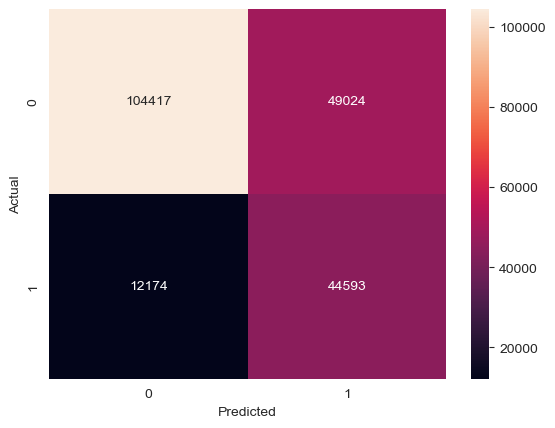

Training AUC: 0.8176


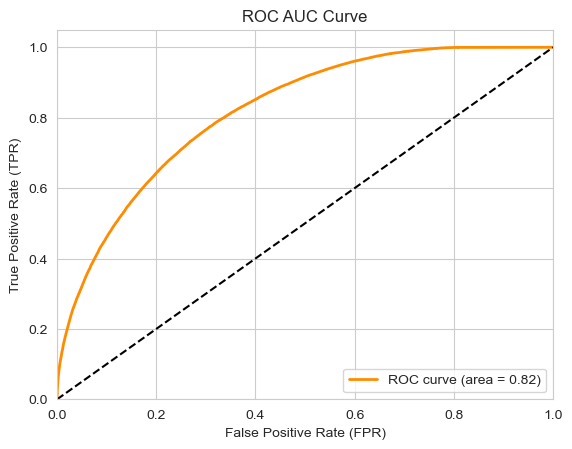

======== Test Set ==========
Confusion Matrix:
[[25334 13026]
 [ 3713 10479]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.66      0.75     38360
           1       0.45      0.74      0.56     14192

    accuracy                           0.68     52552
   macro avg       0.66      0.70      0.65     52552
weighted avg       0.76      0.68      0.70     52552



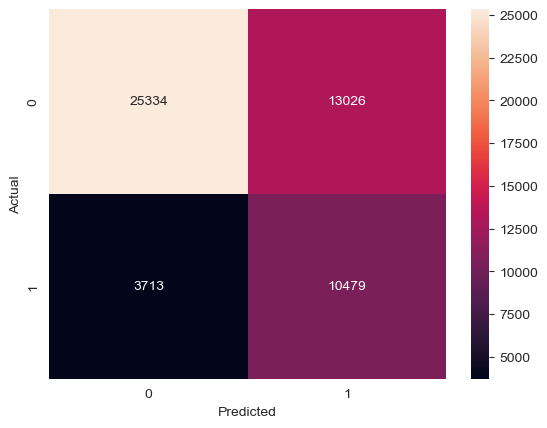

Testing AUC: 0.7770


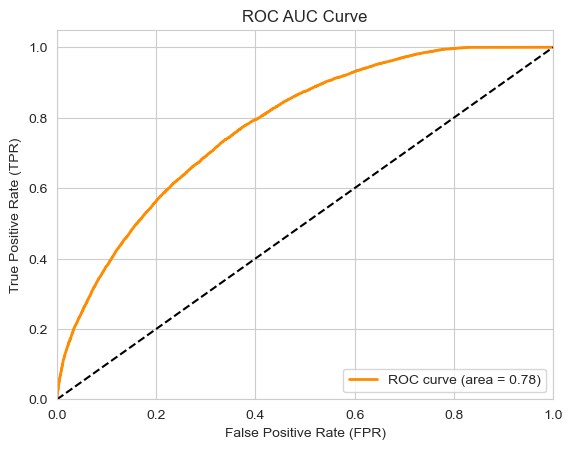

In [134]:
counter3 = Counter(y_train3)
scale_pos_weight3 = counter3[0] / counter3[1]

lgc3 = LGBMClassifier(reg_lambda=1, num_leaves=63,n_estimators=300,
                      min_child_samples=20,max_depth=7,
                      learning_rate=0.1,
                      scale_pos_weight=scale_pos_weight3)

lgc3 = lgc3.fit(X_train3, y_train3)
lgc_y_pred_train3, lgc_y_pred_test3, lgc_y_prob_train3, lgc_y_prob_test3 = evaluate_model(lgc3, X_train3, y_train3, X_test3.values, y_test3.values)

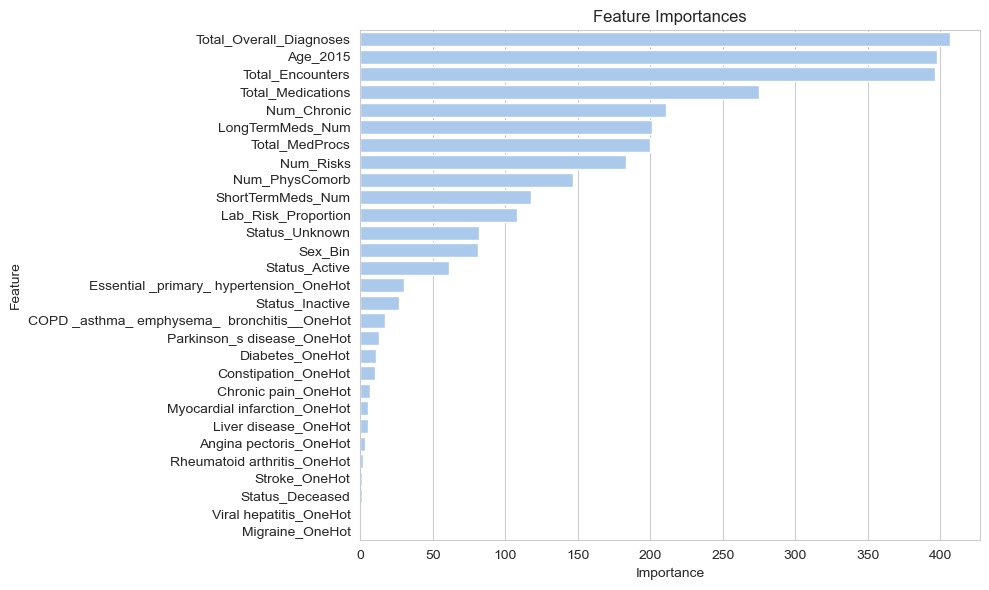

In [116]:
plot_model_importances(lgc3, X_train3)

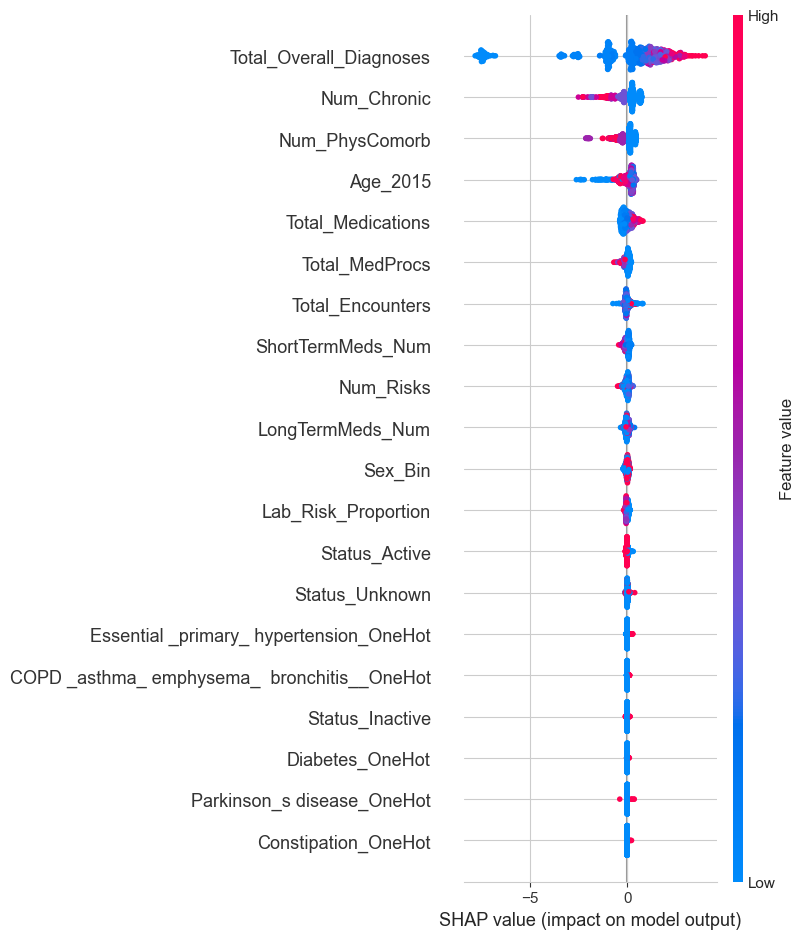

In [117]:
y_pred = lgc3.predict(X_sample, pred_contrib=True)
shap.summary_plot(y_pred[:,:-1], X_sample)

### Multiple Binary Predictors

In [136]:
def preprocess_XY(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    imputer = IterativeImputer(max_iter=10, random_state=42)
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, y_train, X_test_scaled, y_test

In [137]:
df.columns

Index(['Unnamed: 0', 'Patient_ID', 'Sex', 'BirthYear', 'DeceasedYear', 'Age',
       'PatientStatus_calc', 'Total_Overall_Diagnoses', 'Overall_Diagnosis',
       'Overall_Diagnosis_List',
       ...
       'SCHIZ_OneHot', 'BPD_OneHot', 'MDD_OneHot', 'GAD_OneHot', 'TSD_OneHot',
       'SWD_OneHot', 'SD_OneHot', 'SUD_OneHot', 'PD_OneHot', 'NCD_OneHot'],
      dtype='object', length=114)

=== SCHIZ_OneHot ===
[LightGBM] [Info] Number of positive: 1274, number of negative: 208934
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 210208, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006061 -> initscore=-5.099857
[LightGBM] [Info] Start training from score -5.099857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.8234796011569493
Test accuracy score: 0.8211295478763891


======== Training Set ==========
Confusion Matrix:
[[171945  36989]
 [   117   1157]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    208934
           1       0.03      0.91      0.06      1274

    accuracy                           0.82    210208
   macro avg       0.51      0.87      0.48    210208
weighted avg       0.99      0.82      0.90    210208



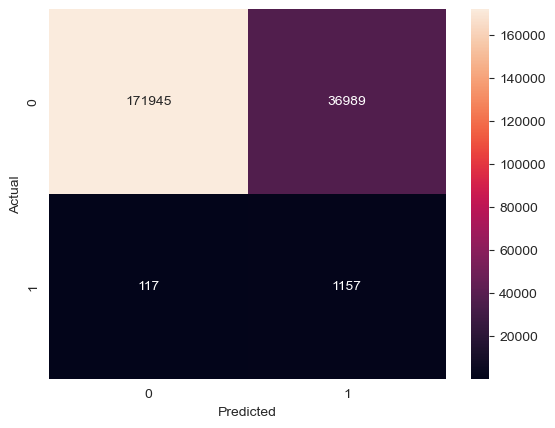

Training AUC: 0.9170


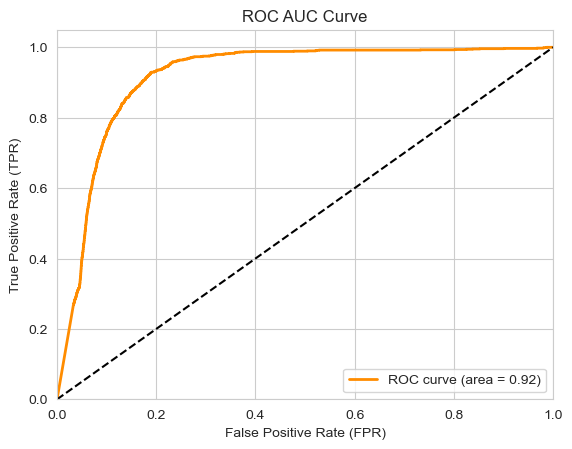

======== Test Set ==========
Confusion Matrix:
[[42974  9259]
 [  141   178]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     52233
           1       0.02      0.56      0.04       319

    accuracy                           0.82     52552
   macro avg       0.51      0.69      0.47     52552
weighted avg       0.99      0.82      0.90     52552



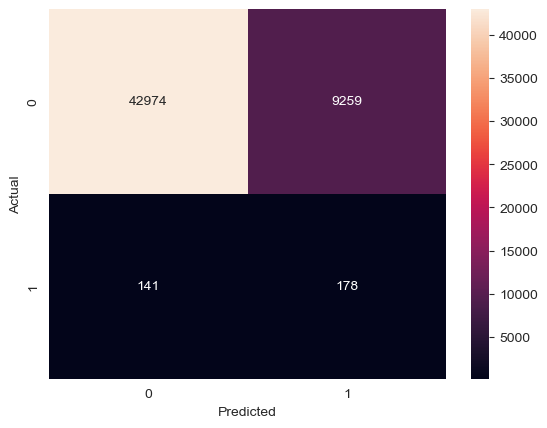

Testing AUC: 0.7043


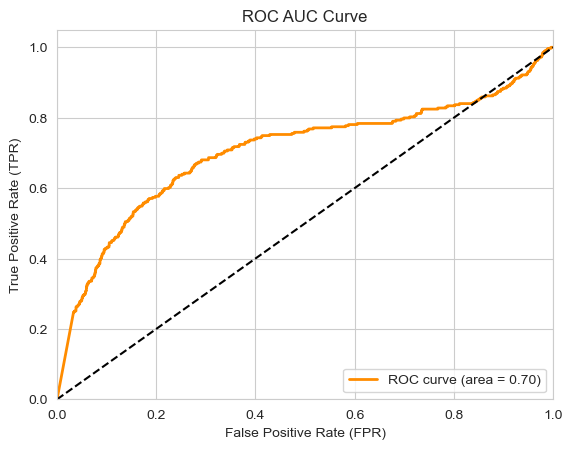

=== BPD_OneHot ===
[LightGBM] [Info] Number of positive: 819, number of negative: 209389
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1655
[LightGBM] [Info] Number of data points in the train set: 210208, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003896 -> initscore=-5.543865
[LightGBM] [Info] Start training from score -5.543865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.8566800502359567
Test accuracy score: 0.8502245395037297


======== Training Set ==========
Confusion Matrix:
[[179340  30049]
 [    78    741]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    209389
           1       0.02      0.90      0.05       819

    accuracy                           0.86    210208
   macro avg       0.51      0.88      0.48    210208
weighted avg       1.00      0.86      0.92    210208



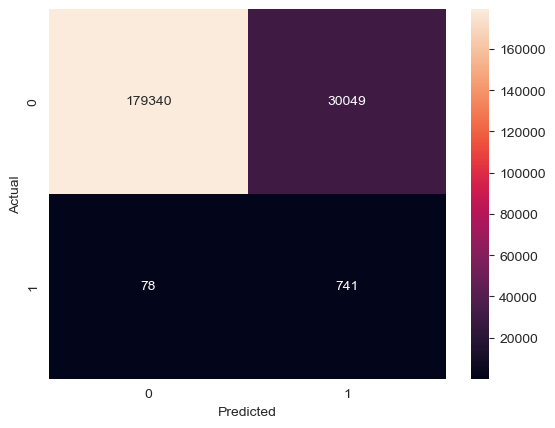

Training AUC: 0.8841


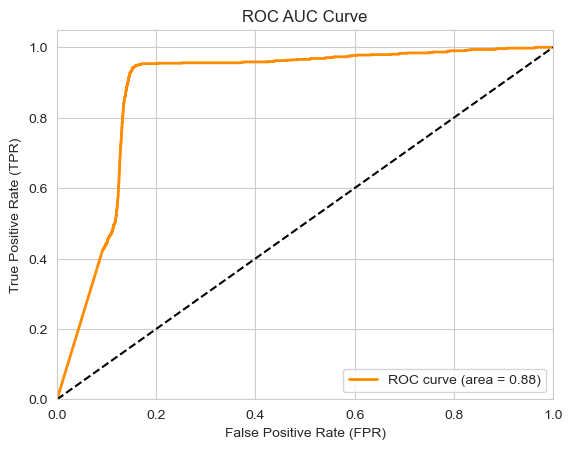

======== Test Set ==========
Confusion Matrix:
[[44587  7760]
 [  111    94]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     52347
           1       0.01      0.46      0.02       205

    accuracy                           0.85     52552
   macro avg       0.50      0.66      0.47     52552
weighted avg       0.99      0.85      0.92     52552



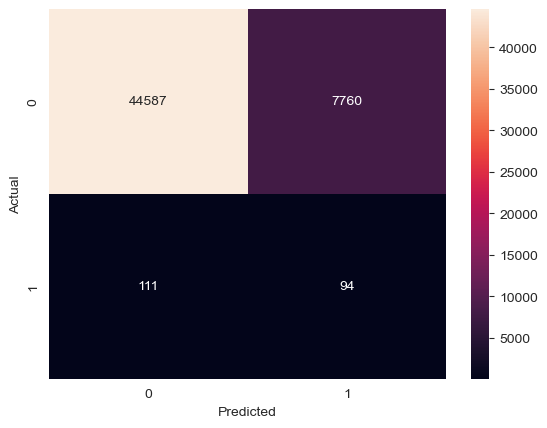

Testing AUC: 0.6449


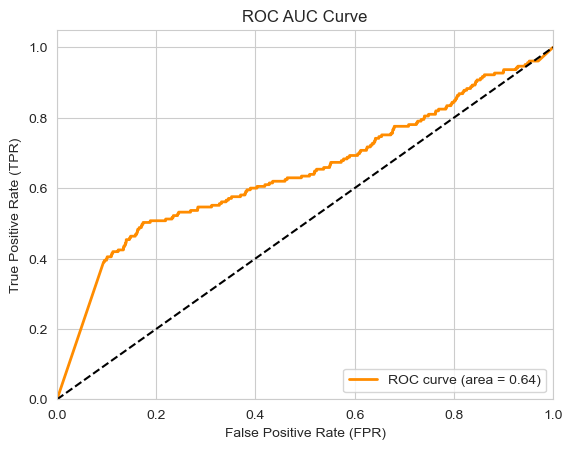

=== MDD_OneHot ===
[LightGBM] [Info] Number of positive: 25066, number of negative: 185142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 210208, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119244 -> initscore=-1.999611
[LightGBM] [Info] Start training from score -1.999611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.7209953950372964
Test accuracy score: 0.6959582889328665


======== Training Set ==========
Confusion Matrix:
[[130894  54248]
 [  4401  20665]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.71      0.82    185142
           1       0.28      0.82      0.41     25066

    accuracy                           0.72    210208
   macro avg       0.62      0.77      0.62    210208
weighted avg       0.88      0.72      0.77    210208



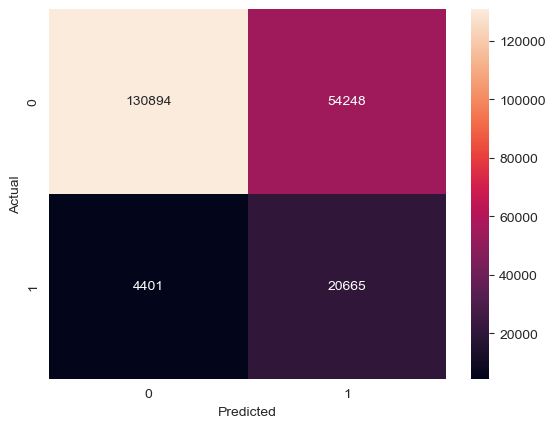

Training AUC: 0.8493


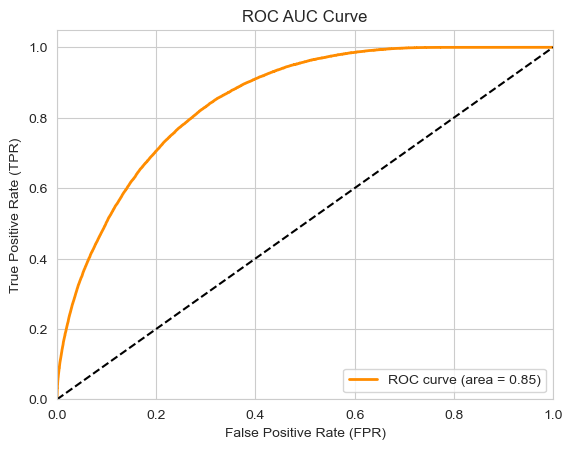

======== Test Set ==========
Confusion Matrix:
[[32082 14203]
 [ 1775  4492]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     46285
           1       0.24      0.72      0.36      6267

    accuracy                           0.70     52552
   macro avg       0.59      0.70      0.58     52552
weighted avg       0.86      0.70      0.75     52552



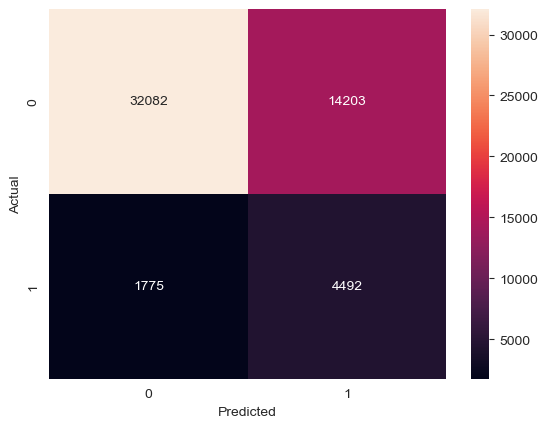

Testing AUC: 0.7836


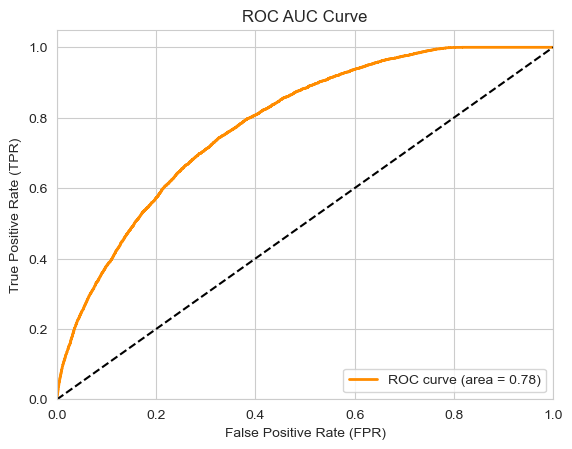

=== GAD_OneHot ===
[LightGBM] [Info] Number of positive: 24418, number of negative: 185790
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1647
[LightGBM] [Info] Number of data points in the train set: 210208, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116161 -> initscore=-2.029296
[LightGBM] [Info] Start training from score -2.029296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.7446005860861623
Test accuracy score: 0.7234738925254985


======== Training Set ==========
Confusion Matrix:
[[136578  49212]
 [  4475  19943]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.74      0.84    185790
           1       0.29      0.82      0.43     24418

    accuracy                           0.74    210208
   macro avg       0.63      0.78      0.63    210208
weighted avg       0.89      0.74      0.79    210208



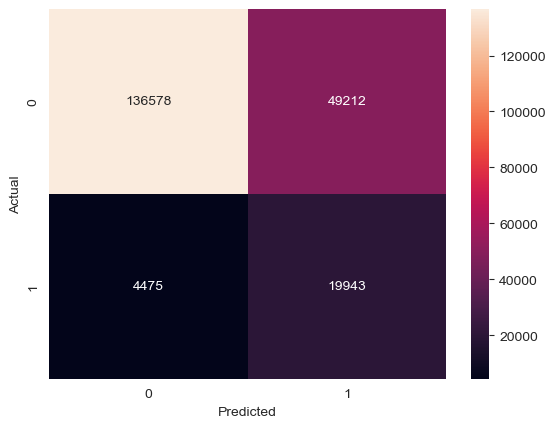

Training AUC: 0.8604


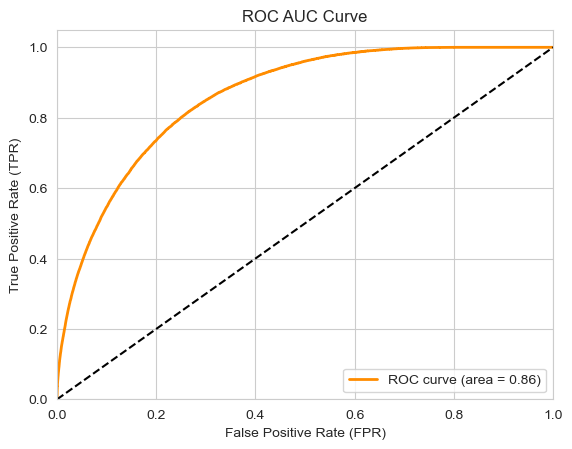

======== Test Set ==========
Confusion Matrix:
[[33612 12835]
 [ 1697  4408]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     46447
           1       0.26      0.72      0.38      6105

    accuracy                           0.72     52552
   macro avg       0.60      0.72      0.60     52552
weighted avg       0.87      0.72      0.77     52552



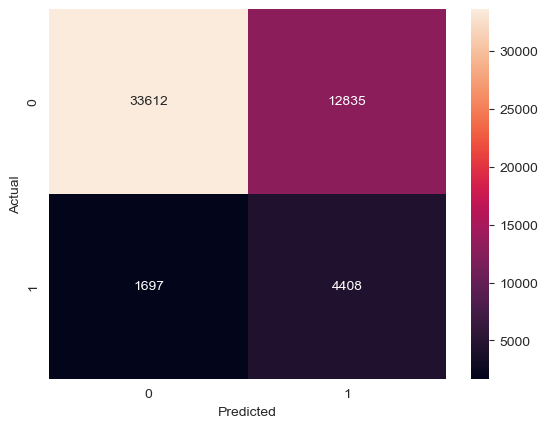

Testing AUC: 0.8006


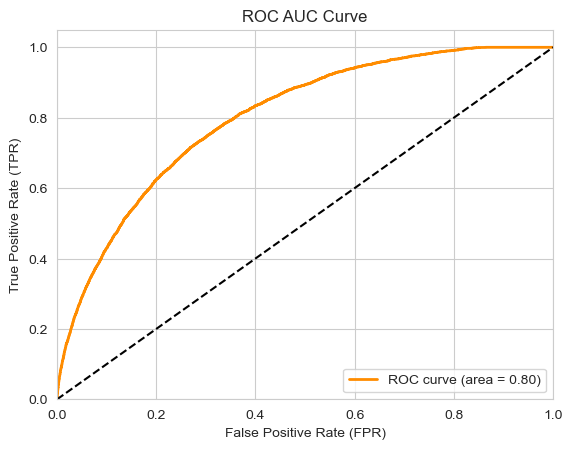

=== TSD_OneHot ===
[LightGBM] [Info] Number of positive: 2506, number of negative: 207702
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1648
[LightGBM] [Info] Number of data points in the train set: 210208, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011922 -> initscore=-4.417417
[LightGBM] [Info] Start training from score -4.417417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.8960648500532805
Test accuracy score: 0.8882249961942457


======== Training Set ==========
Confusion Matrix:
[[185890  21812]
 [    36   2470]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    207702
           1       0.10      0.99      0.18      2506

    accuracy                           0.90    210208
   macro avg       0.55      0.94      0.56    210208
weighted avg       0.99      0.90      0.94    210208



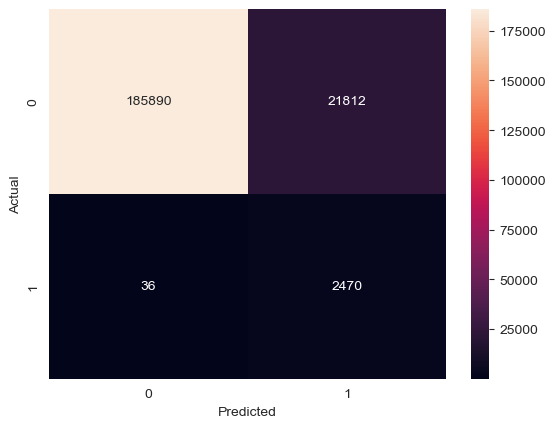

Training AUC: 0.9791


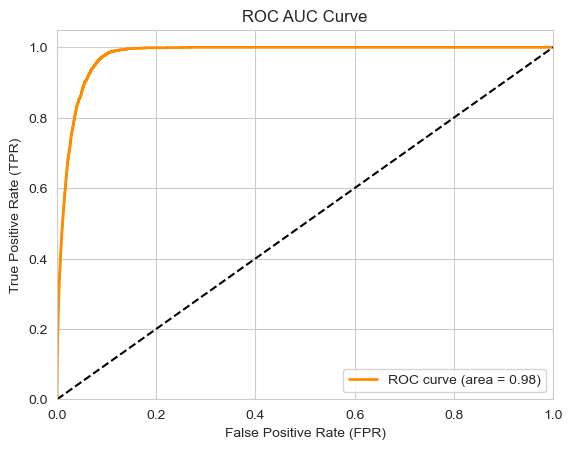

======== Test Set ==========
Confusion Matrix:
[[46327  5598]
 [  276   351]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     51925
           1       0.06      0.56      0.11       627

    accuracy                           0.89     52552
   macro avg       0.53      0.73      0.52     52552
weighted avg       0.98      0.89      0.93     52552



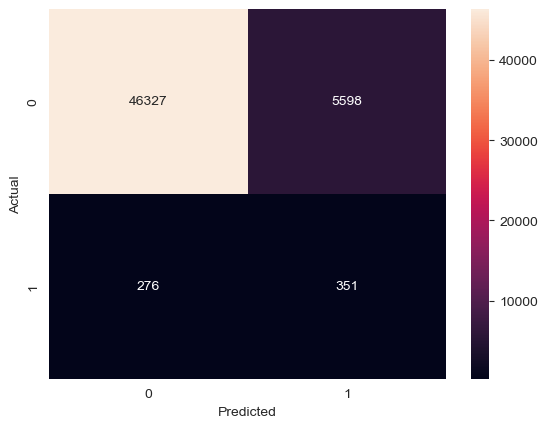

Testing AUC: 0.8186


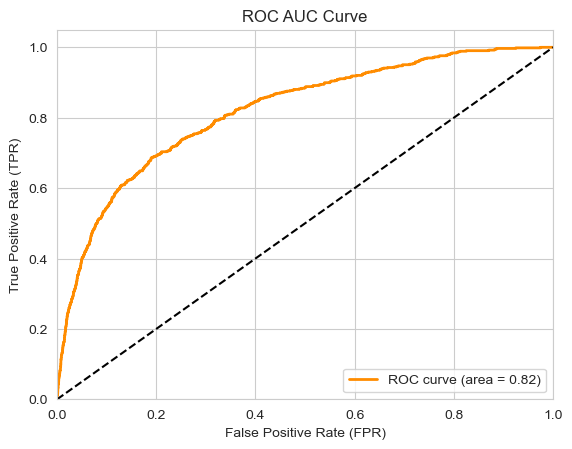

=== SWD_OneHot ===
[LightGBM] [Info] Number of positive: 144, number of negative: 210064
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1657
[LightGBM] [Info] Number of data points in the train set: 210208, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000685 -> initscore=-7.285354
[LightGBM] [Info] Start training from score -7.285354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.9810425863906226
Test accuracy score: 0.9801149337798751


======== Training Set ==========
Confusion Matrix:
[[206079   3985]
 [     0    144]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    210064
           1       0.03      1.00      0.07       144

    accuracy                           0.98    210208
   macro avg       0.52      0.99      0.53    210208
weighted avg       1.00      0.98      0.99    210208



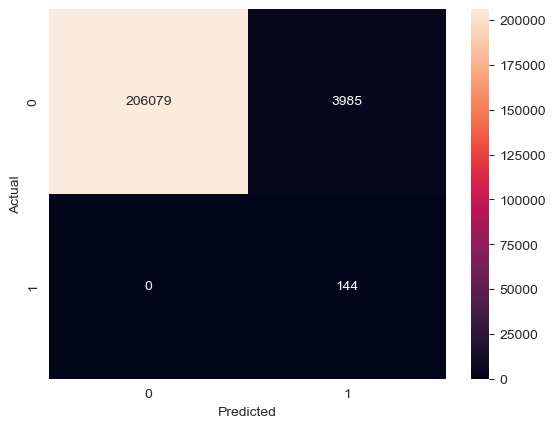

Training AUC: 0.9830


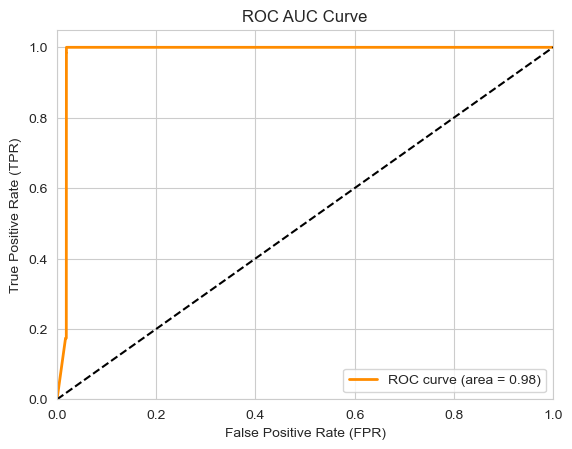

======== Test Set ==========
Confusion Matrix:
[[51506  1010]
 [   35     1]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     52516
           1       0.00      0.03      0.00        36

    accuracy                           0.98     52552
   macro avg       0.50      0.50      0.50     52552
weighted avg       1.00      0.98      0.99     52552



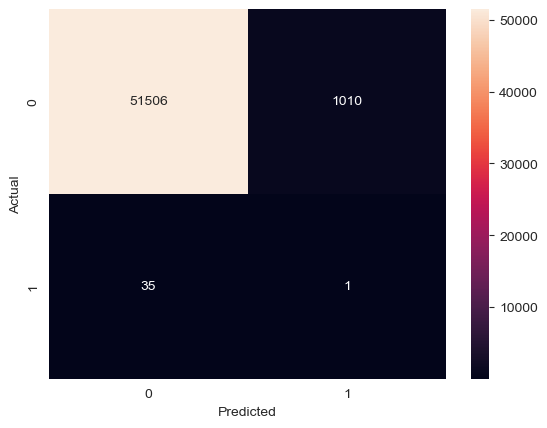

Testing AUC: 0.4758


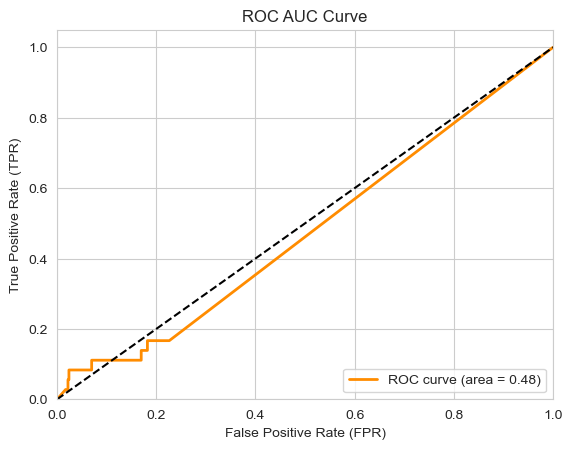

=== SD_OneHot ===
[LightGBM] [Info] Number of positive: 126, number of negative: 210082
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1651
[LightGBM] [Info] Number of data points in the train set: 210208, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000599 -> initscore=-7.418971
[LightGBM] [Info] Start training from score -7.418971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.9774033338407673
Test accuracy score: 0.9765184959659005


======== Training Set ==========
Confusion Matrix:
[[205332   4750]
 [     0    126]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    210082
           1       0.03      1.00      0.05       126

    accuracy                           0.98    210208
   macro avg       0.51      0.99      0.52    210208
weighted avg       1.00      0.98      0.99    210208



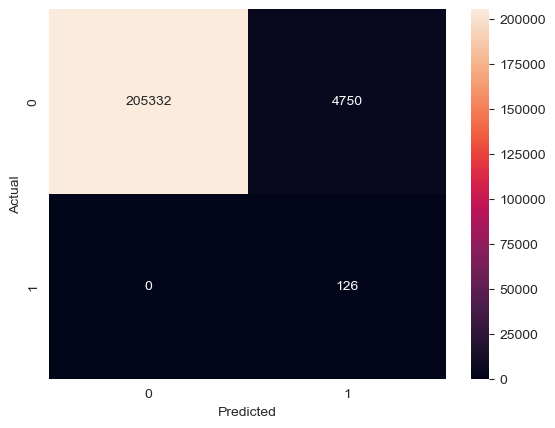

Training AUC: 0.9807


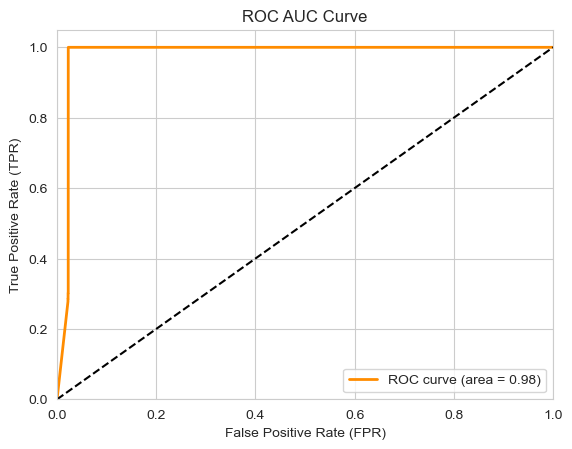

======== Test Set ==========
Confusion Matrix:
[[51313  1208]
 [   26     5]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     52521
           1       0.00      0.16      0.01        31

    accuracy                           0.98     52552
   macro avg       0.50      0.57      0.50     52552
weighted avg       1.00      0.98      0.99     52552



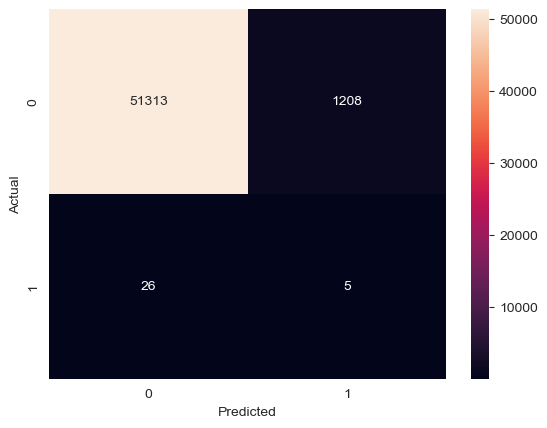

Testing AUC: 0.5731


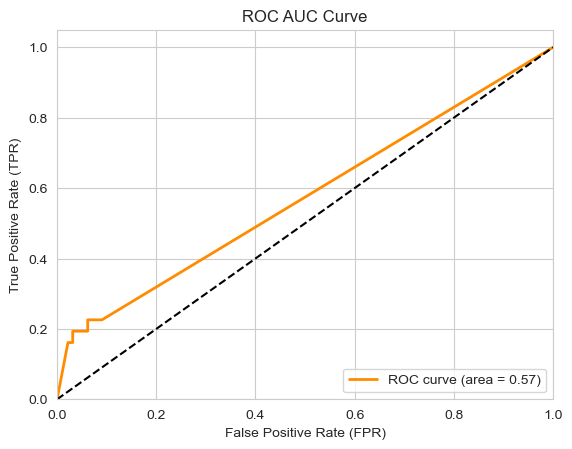

=== SUD_OneHot ===
[LightGBM] [Info] Number of positive: 6128, number of negative: 204080
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1652
[LightGBM] [Info] Number of data points in the train set: 210208, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029152 -> initscore=-3.505644
[LightGBM] [Info] Start training from score -3.505644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.858416425635561
Test accuracy score: 0.8432980666768154


======== Training Set ==========
Confusion Matrix:
[[174760  29320]
 [   442   5686]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    204080
           1       0.16      0.93      0.28      6128

    accuracy                           0.86    210208
   macro avg       0.58      0.89      0.60    210208
weighted avg       0.97      0.86      0.90    210208



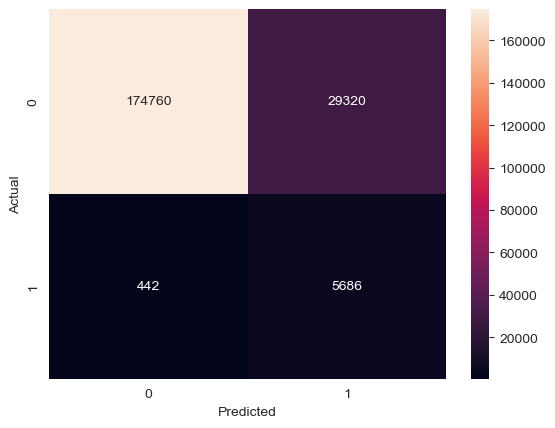

Training AUC: 0.9560


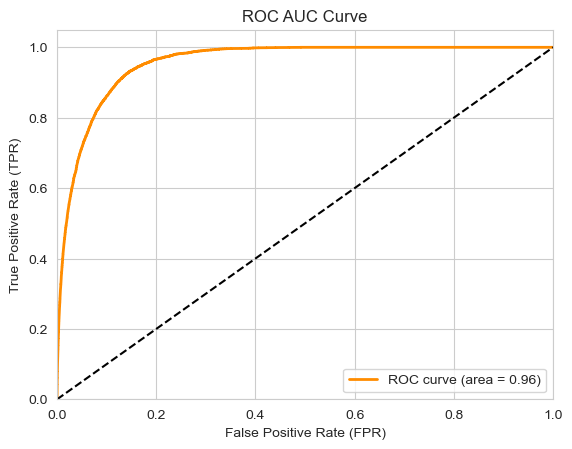

======== Test Set ==========
Confusion Matrix:
[[43271  7749]
 [  486  1046]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91     51020
           1       0.12      0.68      0.20      1532

    accuracy                           0.84     52552
   macro avg       0.55      0.77      0.56     52552
weighted avg       0.96      0.84      0.89     52552



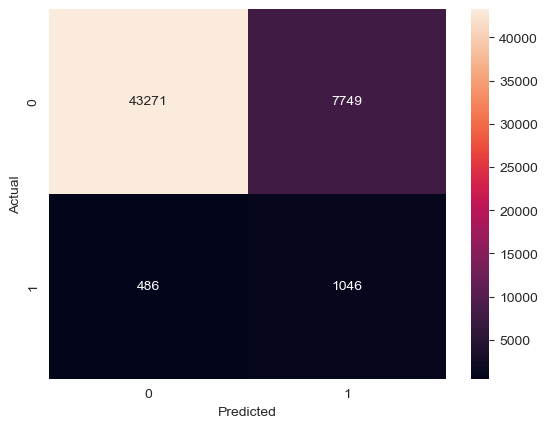

Testing AUC: 0.8589


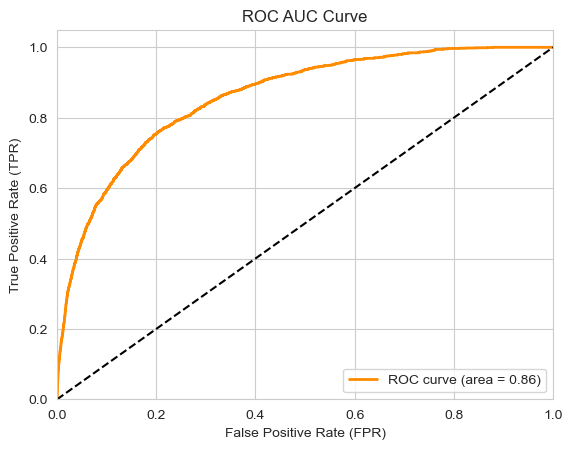

=== PD_OneHot ===
[LightGBM] [Info] Number of positive: 231, number of negative: 209977
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1657
[LightGBM] [Info] Number of data points in the train set: 210208, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001099 -> initscore=-6.812336
[LightGBM] [Info] Start training from score -6.812336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.9625418632973055
Test accuracy score: 0.9601347237022377


======== Training Set ==========
Confusion Matrix:
[[202104   7873]
 [     1    230]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    209977
           1       0.03      1.00      0.06       231

    accuracy                           0.96    210208
   macro avg       0.51      0.98      0.52    210208
weighted avg       1.00      0.96      0.98    210208



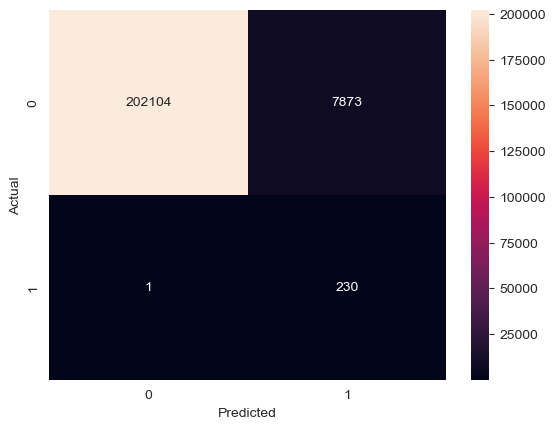

Training AUC: 0.9661


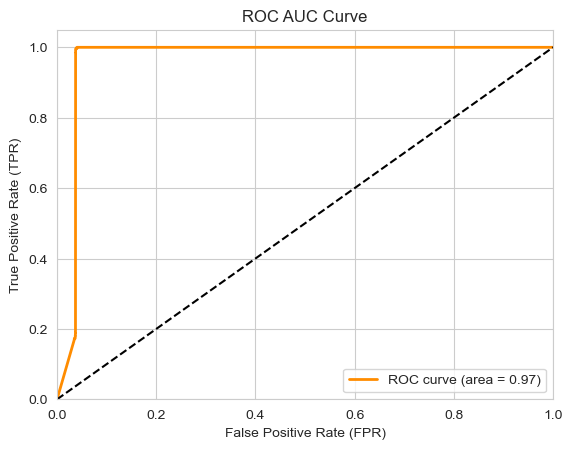

======== Test Set ==========
Confusion Matrix:
[[50451  2043]
 [   52     6]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     52494
           1       0.00      0.10      0.01        58

    accuracy                           0.96     52552
   macro avg       0.50      0.53      0.49     52552
weighted avg       1.00      0.96      0.98     52552



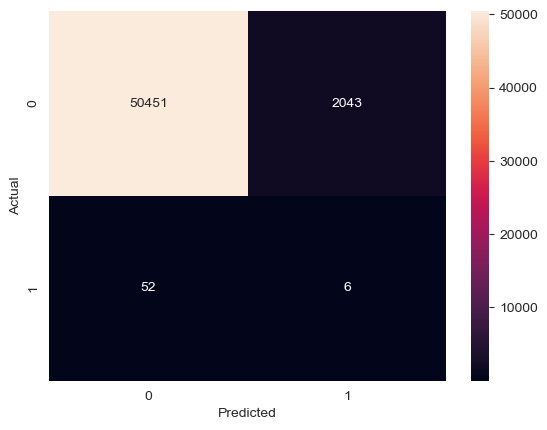

Testing AUC: 0.5580


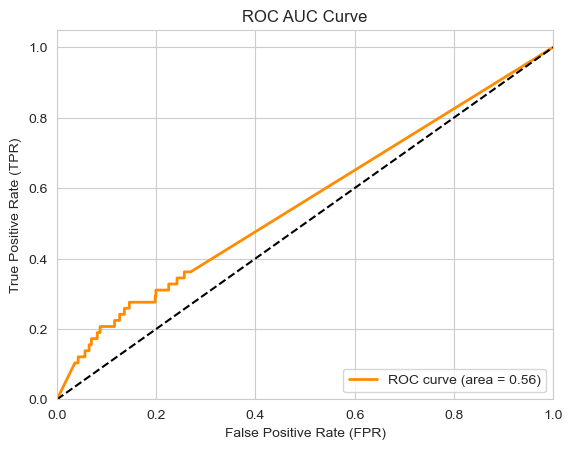

=== NCD_OneHot ===
[LightGBM] [Info] Number of positive: 2658, number of negative: 207550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1651
[LightGBM] [Info] Number of data points in the train set: 210208, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012645 -> initscore=-4.357798
[LightGBM] [Info] Start training from score -4.357798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/daisyliu/anaconda3/envs/had7001/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train accuracy score: 0.9180240523671792
Test accuracy score: 0.9070444512102299


======== Training Set ==========
Confusion Matrix:
[[190343  17207]
 [    25   2633]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    207550
           1       0.13      0.99      0.23      2658

    accuracy                           0.92    210208
   macro avg       0.57      0.95      0.60    210208
weighted avg       0.99      0.92      0.95    210208



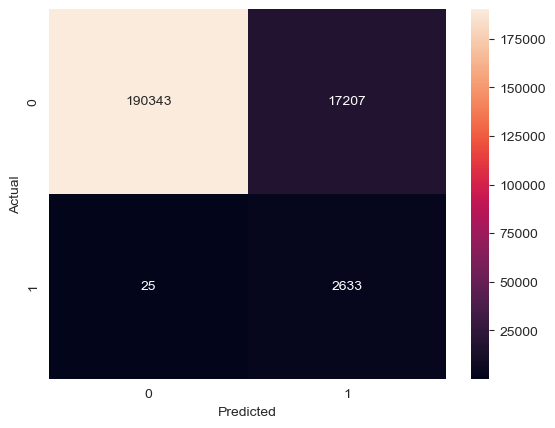

Training AUC: 0.9905


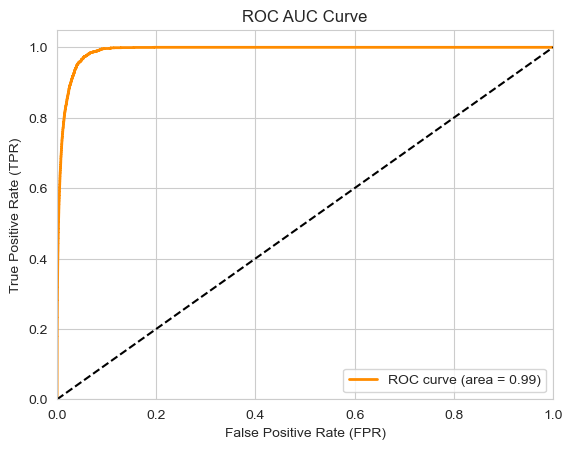

======== Test Set ==========
Confusion Matrix:
[[47275  4612]
 [  273   392]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     51887
           1       0.08      0.59      0.14       665

    accuracy                           0.91     52552
   macro avg       0.54      0.75      0.54     52552
weighted avg       0.98      0.91      0.94     52552



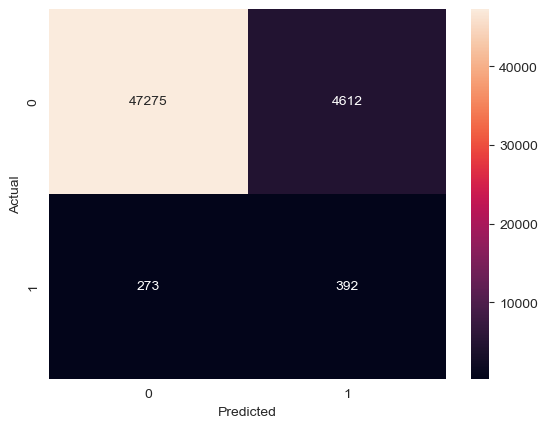

Testing AUC: 0.8769


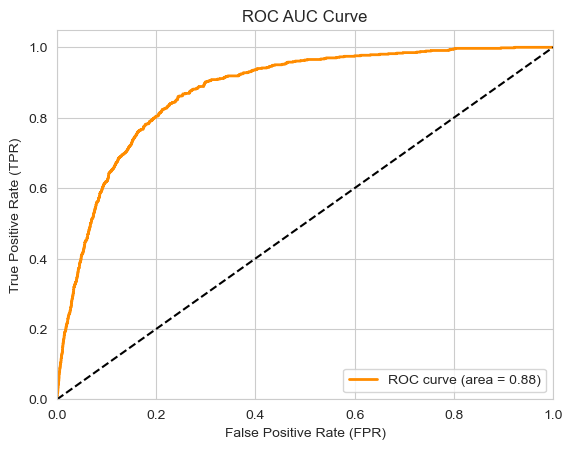

In [139]:
MHD_onehot = ['SCHIZ_OneHot', 'BPD_OneHot', 'MDD_OneHot', 'GAD_OneHot', 'TSD_OneHot',
              'SWD_OneHot', 'SD_OneHot', 'SUD_OneHot', 'PD_OneHot', 'NCD_OneHot']

ft4 = ['Sex_Bin', 'Age_2015', 'Num_Risks', 'Total_Overall_Diagnoses', 'Total_Encounters',
            'Lab_Risk_Proportion', 'Num_Chronic', 'Total_Medications', 'Total_MedProcs',
            'Status_Active', 'Status_Deceased', 'Status_Inactive', 'Status_Unknown',
            'Diabetes_OneHot', 'Essential (primary) hypertension_OneHot', 'COPD (asthma, emphysema,  bronchitis)_OneHot', 
            'Viral hepatitis_OneHot', 'Chronic pain_OneHot', 'Rheumatoid arthritis_OneHot', 'Myocardial infarction_OneHot', 
            "Parkinson's disease_OneHot", 'Stroke_OneHot', 'Angina pectoris_OneHot', 'Liver disease_OneHot', 
            'Migraine_OneHot', 'Constipation_OneHot', 'Num_PhysComorb','LongTermMeds_Num', 'ShortTermMeds_Num']

df_ft4 = df[ft4+MHD_onehot]
df_ft4.columns = [re.sub(r'[\"\'\[\]\{\}\\,()]+', '_', col) for col in df_ft4.columns]

X = df_ft4.drop(MHD_onehot, axis=1)

for mhd in MHD_onehot:
    print(f'=== {mhd} ===')
    y = df_ft4[mhd]

    X_train_scaled, y_train, X_test_scaled, y_test = preprocess_XY(X, y)
    counter = Counter(y_train)
    scale_pos_weight = counter[0] / counter[1]

    lgc = LGBMClassifier(reg_lambda=1, num_leaves=63,n_estimators=300,
                         min_child_samples=20,max_depth=7,
                         learning_rate=0.1,
                         scale_pos_weight=scale_pos_weight)

    lgc = lgc.fit(X_train_scaled, y_train)
    lgc_y_pred_train, lgc_y_pred_test, lgc_y_prob_train, lgc_y_prob_test = evaluate_model(lgc, X_train_scaled, y_train, X_test_scaled, y_test)